
# RNN Dead Layer Fit Project

## Abigail Alexander, Aobo Li


## Plan:

1) Generating MC spectrums with different [FCCD Width, Dead Layer Ratio, transfer function], normalize them to contain the same number of events -> Done

2) Randomly pull out 2 MC spectrum(MC1 and MC2) and subtract them to obtain MCdiff = (MC1-MC2)

3) Feed MCdiff into RNN and train to answer questions: is FCCD Width of MC1>MC2? is dead layer ration of MC1>MC2? etc.
    
    - RNN: https://github.com/legend-exp/gem/blob/master/NetworkPSA/NetworkPSA_RNN.ipynb

4) Use the traditional peak-fitting technology you and Valentina developed, this will give you a MC spectrum given certain dead layer parameters, let’s call it MCbest

5) Calculate a new difference by doing MC_newdiff = Data-MCbest, then feeding MC_newdiff into the trained RNN. RNN will tell you if the [FCCD width, dead layer ratio,…] in MCbest is too low/too high.

6) Looking at the attention score, this will tell you which part of the spectrum the network has used to make the decision.

7) Trying to understand why a too low/too high FCCD width would have that kind of effect on that part of the spectrum, is it because of the MC simulation? transfer function? etc.

# ---------------------------------------------
# CLASSES AND FUNCTIONS
# ---------------------------------------------

# Import general packages

In [5]:
#check env
import os
print (os.environ['CONDA_DEFAULT_ENV'])

/unix/legend/abi/ML_DL/MLenv


In [6]:
#General
import sys
import json
import yaml
import pandas as pd

#RNN imports
import numpy as np
import os
import argparse
import time
import math
import random
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn import init
import torch.nn.functional as F
import torch
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import gzip
import pickle
import numpy as np
from torch.autograd import Variable
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import torchsnooper #problem installing: !pip install torchsnooper --user #this worked for installing torchsnooper
import h5py
import re
from tqdm import tqdm
from torch.cuda.amp import autocast

torch.cuda.empty_cache()


DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cuda:0")
print(DEVICE)
torch.cuda.is_available()

cuda:0


True

# Import dataset and RNN functions

In [7]:
from src.data import *
from src.RNN import *
from src.functions import *

# Get relevant paths

In [8]:
# Data paths:
CodePath = os.path.dirname(os.path.abspath("__file__"))
FCCD_DLF_list_path = CodePath+"/data/V05268A_data/1000random_FCCDs_DLFs.json"
DATA_PATH = CodePath+"/data/V05268A_data/data_hist_Ba_V05268A.h5"
MC_PATH = CodePath+"/data/V05268A_data/training_data_V05268A/"


print(MC_PATH)

/unix/legend/abi/ML_DL/RNN_DeadLayerFit/data/V05268A_data/training_data_V05268A/


# -------------------------------------------------------
# WORKFLOW
# -------------------------------------------------------

# TRAINING 1: full dataset

In [20]:
NUM_EPOCHS = 20 #can try increasing
LEARNING_RATE = 0.005 #0.01 #try modifying learning rate #0.001 too low for 30 epochs, 0.01 may be too high
dataset_size = 10000
RNN_ID = "RNN_"+str(NUM_EPOCHS)+"epochs_LR"+str(LEARNING_RATE)+"_fulldataset_"+str(dataset_size)+"trials"

#initialise directories to save
if not os.path.exists(CodePath+"/saved_models/"+RNN_ID+"/plots/"):
    os.makedirs(CodePath+"/saved_models/"+RNN_ID+"/plots/")

## Training  (DO NOT RERUN UNLESS NECESSARY)

In [16]:
#load dataset
BATCH_SIZE = 4 
train_loader, test_loader, dataset = load_data(BATCH_SIZE, size=dataset_size)

#run training
FCCD_accuracy_values, DLF_accuracy_values, loss_values = train_RNN(dataset, train_loader, test_loader, NUM_EPOCHS, LEARNING_RATE, saveRNN=True, plot_training_results = True, RNN_ID = RNN_ID)


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 201.62it/s]

(1000, 900)


In [ ]:
#Training Results
training_results(NUM_EPOCHS, loss_values, FCCD_accuracy_values, DLF_accuracy_values, save_plots = False, RNN_ID = RNN_ID)


## Testing

In [21]:
#load dataset again
BATCH_SIZE = 4 
train_loader, test_loader, dataset = load_data(BATCH_SIZE, size=dataset_size)

100%|████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 211.79it/s]

(1000, 900)


In [22]:
# Load saved model
RNNclassifier_fulldataset = RNN(dataset.get_histlen(),2)
model_path = CodePath+"/saved_models/"+RNN_ID+"/"+RNN_ID+".pkl"
RNNclassifier_fulldataset.load_state_dict(torch.load(model_path))
RNNclassifier_fulldataset.eval()

RNN(
  (RNNLayer): GRU(1, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fcnet): FCNet(
    (fcnet): Sequential(
      (0): Linear(in_features=1024, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=256, out_features=2, bias=True)
    )
  )
  (attention_weight): Linear(in_features=512, out_features=512, bias=False)
)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 750/750 [01:33<00:00,  7.99it/s]


FCCD accuracies: 
total:  3000
TP:  1476
FP:  17
TN:  1497
FN:  10
accuracy:  0.991
precision:  0.9886135298057602
recall:  0.9932705248990579

DLF accuracies: 
total:  3000
TP:  1447
FP:  54
TN:  1444
FN:  55
accuracy:  0.9636666666666667
precision:  0.9640239840106596
recall:  0.9633821571238349
Total # misclassified trials FCCD:  27  / 3000
Total # misclassified trials DLF:  109  / 3000


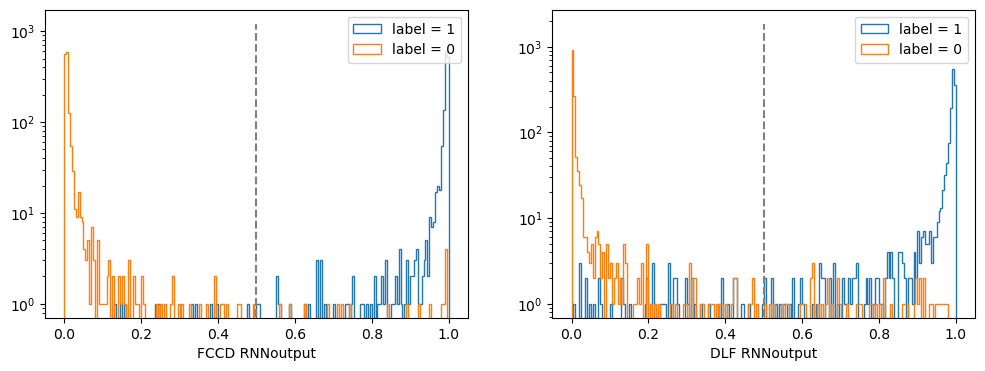

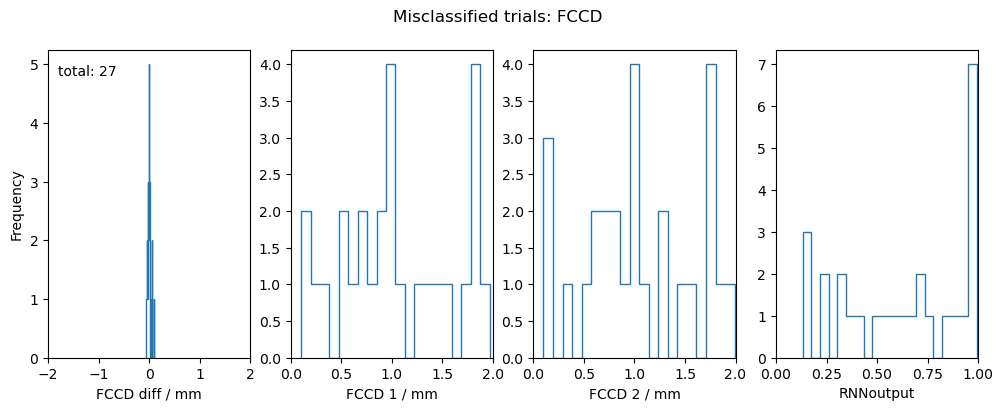

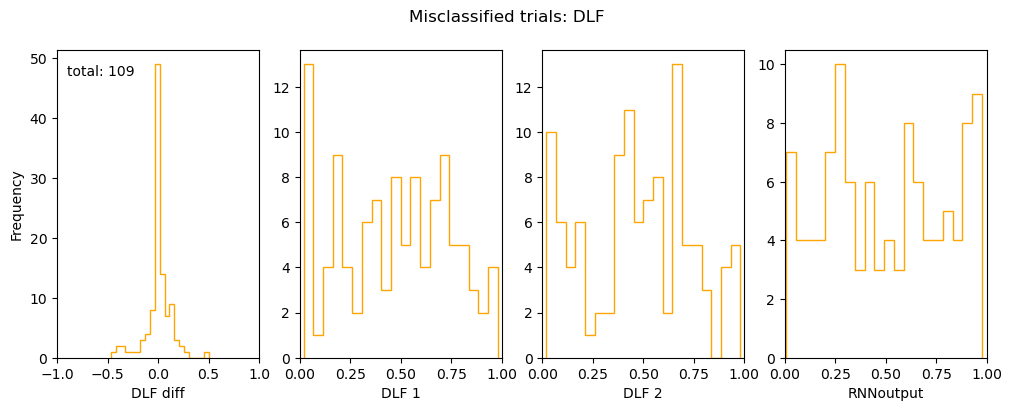

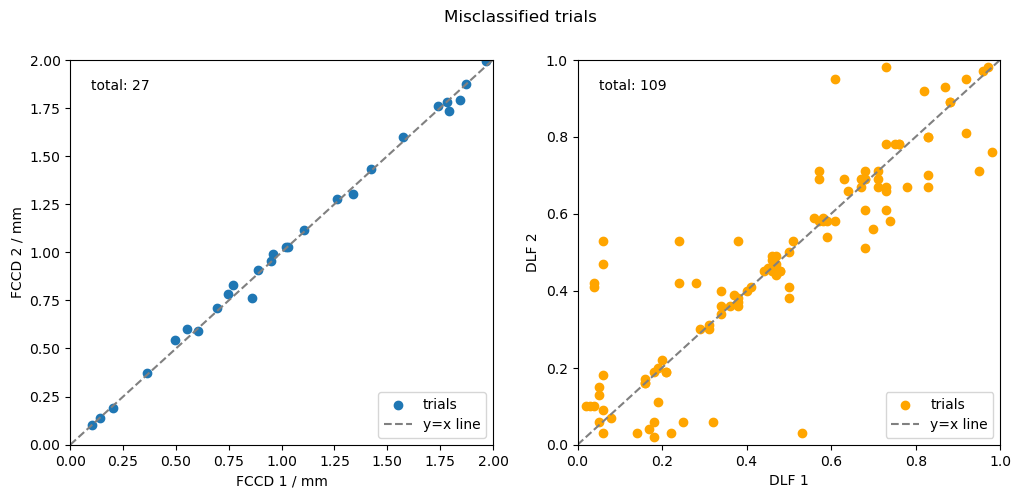

In [23]:
#testing
accuracies_fulldataset = test_RNN(RNNclassifier_fulldataset, test_loader, RNN_ID=RNN_ID, performance_plots = True, misclassified_trials_plots = True, save_results = True)


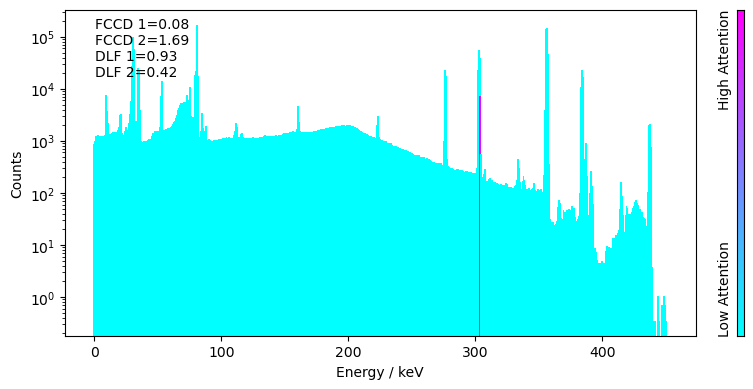

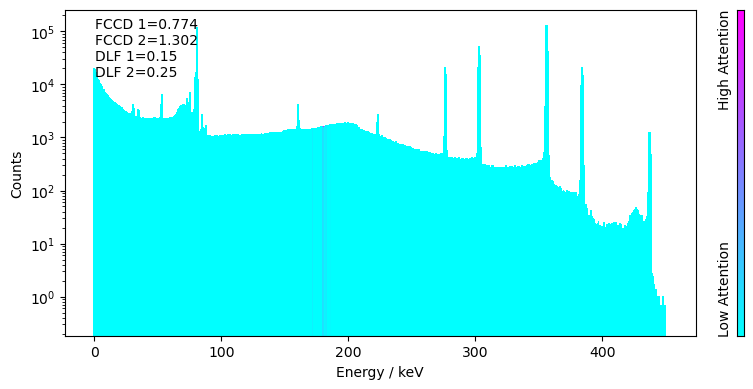

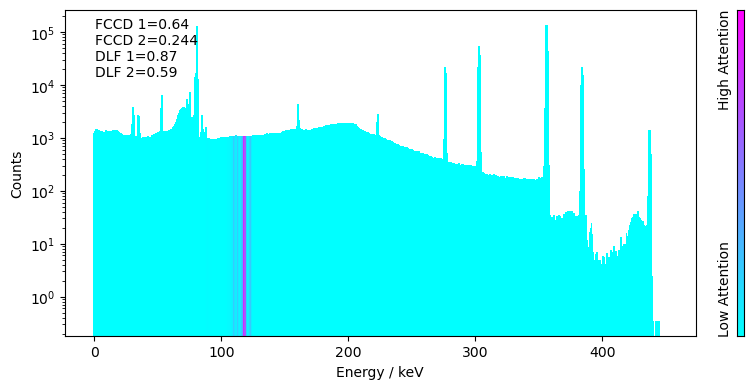

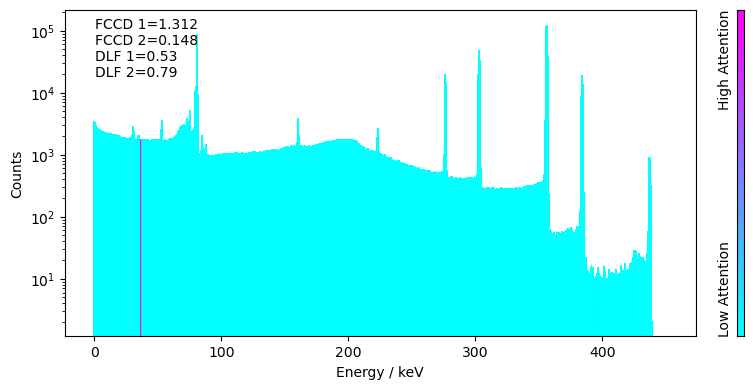

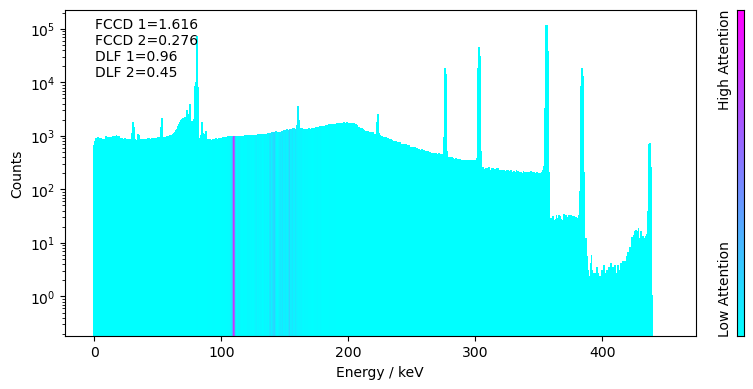

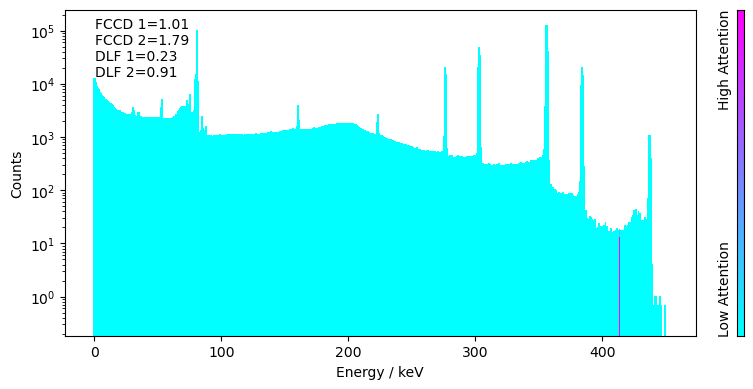

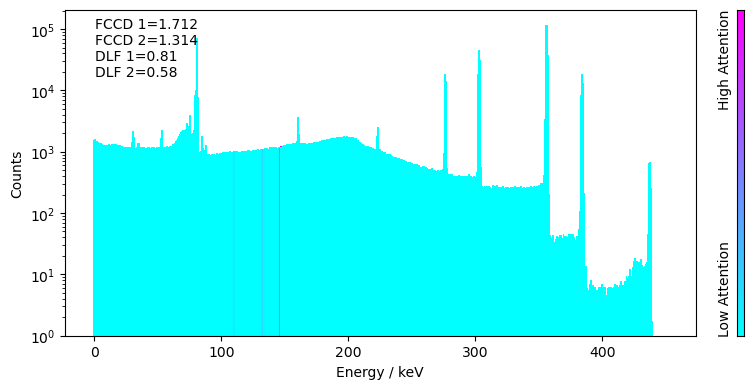

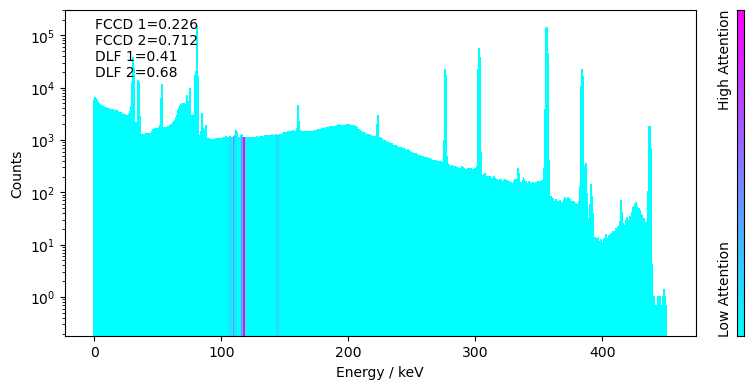

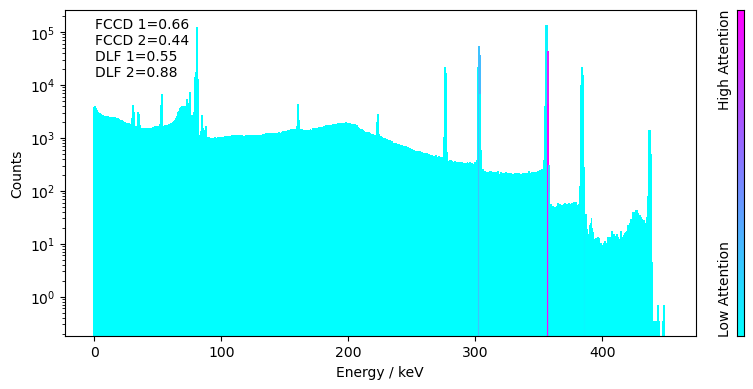

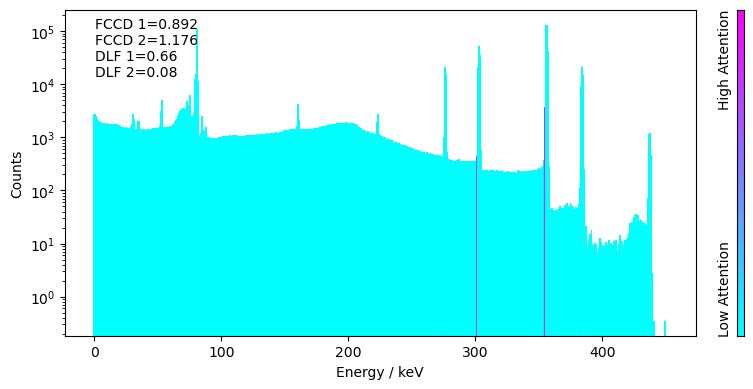

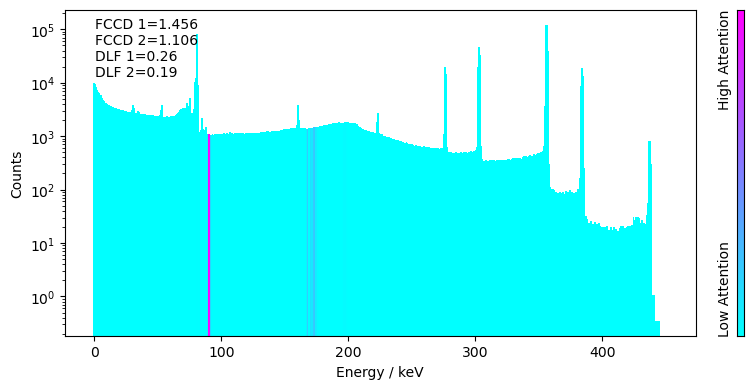

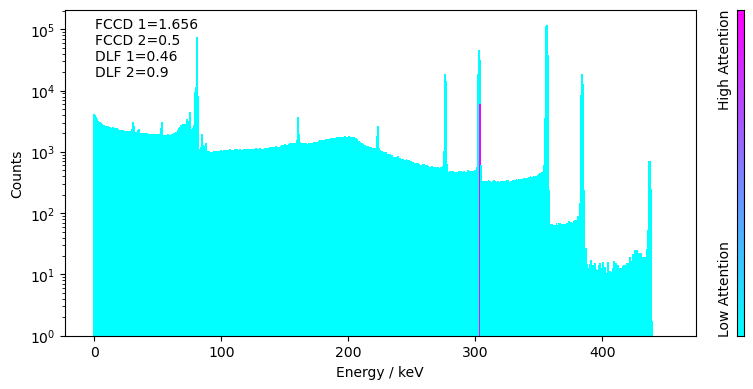

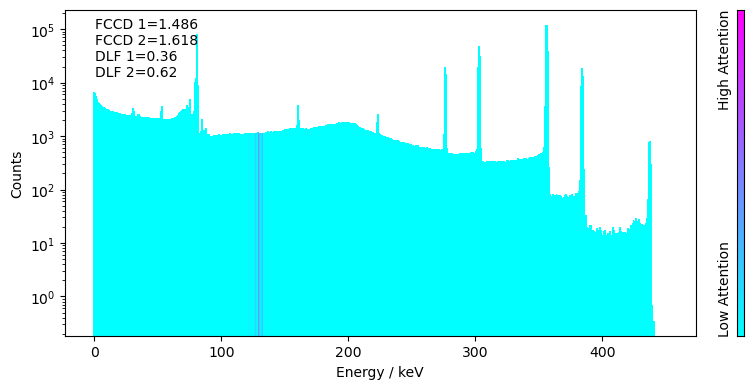

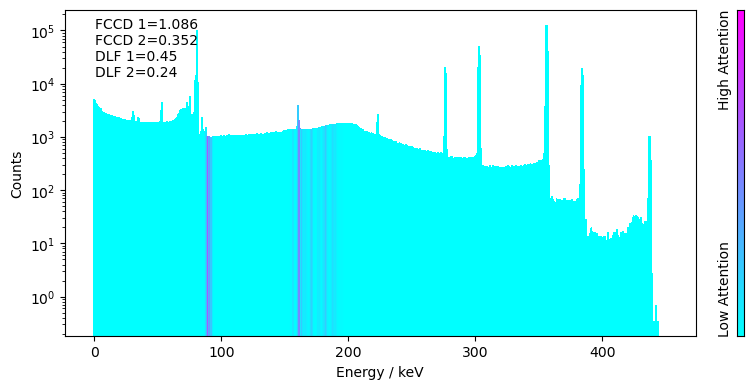

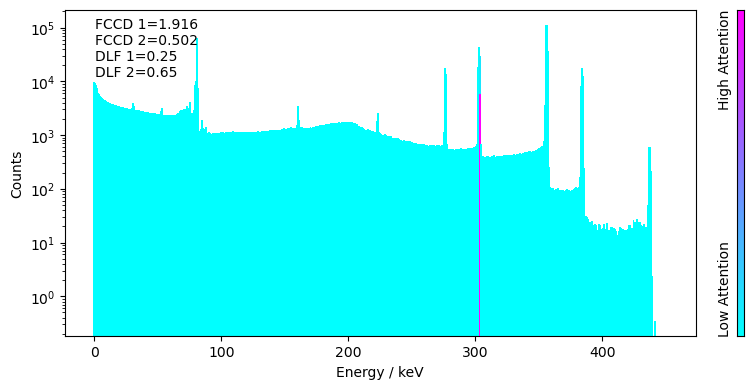

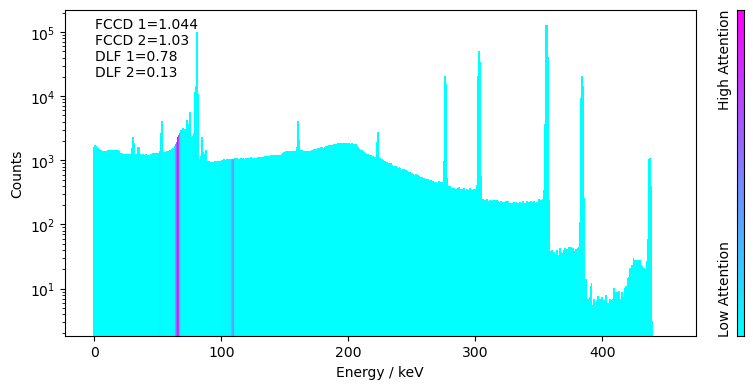

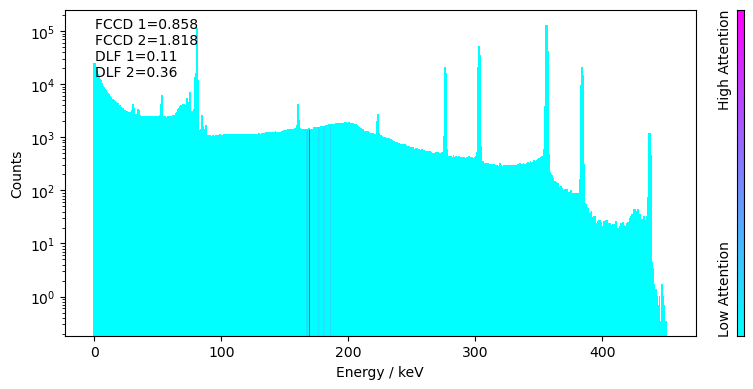

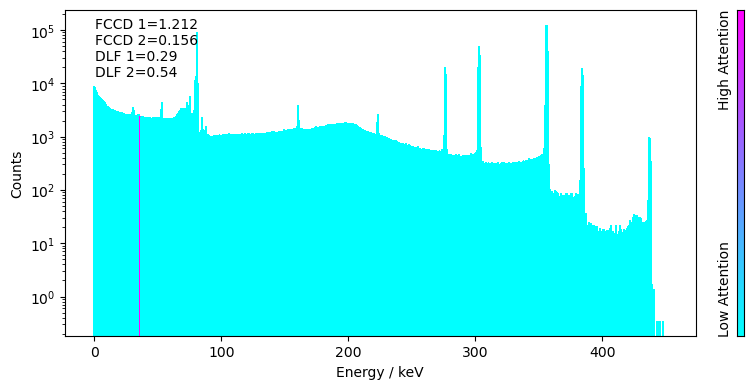

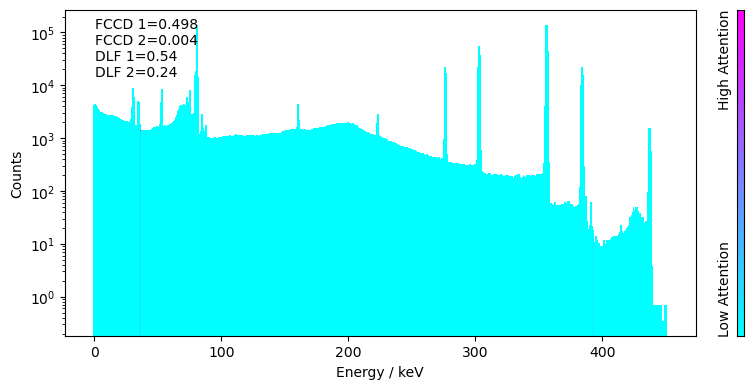

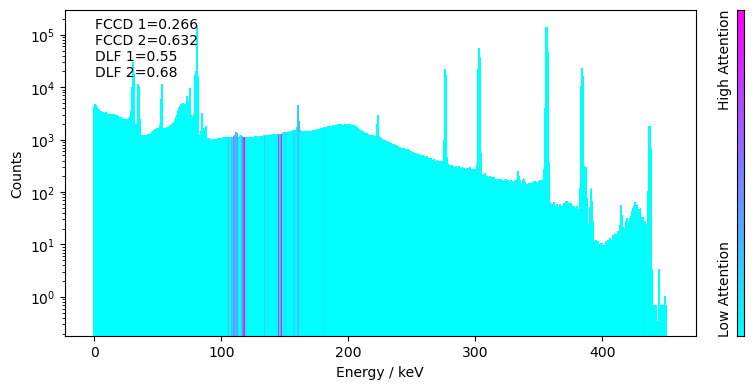

In [24]:
#Investigate Attention

#Make RNNinterpretor object and set get_attention to true
RNNinterpretor = RNN(dataset.get_histlen(),2)
RNNinterpretor.get_attention = True

#Load trained RNN dict to this
RNNinterpretor.load_state_dict(torch.load(model_path))
RNNinterpretor.eval()
RNNinterpretor.to(DEVICE)

import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages(CodePath+"/saved_models/"+RNN_ID+"/plots/test_attention.pdf")

for a in range(5): 
    
    #Load a test event through interpretor
    test_spectrum_diff, test_FCCDLabel, test_DLFLabel, test_extras, test_spectrum = next(iter(test_loader))
    test_spectrum_diff = test_spectrum_diff.to(DEVICE).float()

    attention_score = RNNinterpretor(test_spectrum_diff)


    for i in range(BATCH_SIZE):
        attention = attention_score[i].cpu().detach().numpy()
        labels = {"FCCD1": test_extras["FCCD1"][i].item(), "FCCD2": test_extras["FCCD2"][i].item(), "DLF1": test_extras["DLF1"][i].item(), "DLF2": test_extras["DLF2"][i].item()}

        #plot attention score on spectrum
        fig = plot_attention(test_spectrum[i], attention, labels)

    #     pdf.savefig(fig)
        fig.savefig(pdf, format='pdf') 

pdf.close()
    

# TRAINING 2: restircted dataset - Max FCCD diff = 0.5 mm

Only train on FCCDs with a max diff of 0.5 mm

In [9]:
NUM_EPOCHS = 20 #can try increasing
LEARNING_RATE = 0.005 #0.01 #try modifying learning rate #0.001 too low for 30 epochs, 0.01 may be too high
dataset_size = 10000

maxFCCDdiff = 0.5
maxDLFdiff = 1.0 #i.e. no restriction
RNN_ID ="RNN_"+str(NUM_EPOCHS)+"epochs_LR"+str(LEARNING_RATE)+"_maxFCCDdiff"+str(maxFCCDdiff)+"mm_"+str(dataset_size)+"trials"

#initialise directories to save
if not os.path.exists(CodePath+"/saved_models/"+RNN_ID+"/plots/"):
    os.makedirs(CodePath+"/saved_models/"+RNN_ID+"/plots/")

## Training - DO NOT RERUN UNLESS NECESARRY

In [ ]:
#Load dataset
BATCH_SIZE = 4 
restrict_dict = {"maxFCCDdiff": maxFCCDdiff, "maxDLFdiff": maxDLFdiff}
train_loader, test_loader, dataset = load_data(BATCH_SIZE, restrict_dataset=True, restrict_dict = restrict_dict, size=dataset_size)

#train RNN
FCCD_accuracy_values, DLF_accuracy_values, loss_values = train_RNN(dataset, train_loader, test_loader, NUM_EPOCHS, LEARNING_RATE, saveRNN=True, plot_training_results = True, RNN_ID = RNN_ID)

In [ ]:
#Training Results
training_results(NUM_EPOCHS, loss_values, FCCD_accuracy_values, DLF_accuracy_values, save_plots = False, RNN_ID = RNN_ID)


## Testing - on maxFCCDdiff=0.5mm

In [10]:
#Load restricted dataset
BATCH_SIZE = 4 
restrict_dict = {"maxFCCDdiff": maxFCCDdiff, "maxDLFdiff": maxDLFdiff}
train_loader, test_loader, dataset = load_data(BATCH_SIZE, restrict_dataset=True, restrict_dict = restrict_dict, size=dataset_size)


100%|████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 204.03it/s]

(1000, 900)


In [11]:
# Load saved model
RNNclassifier_maxFCCDdiff0_5mm = RNN(dataset.get_histlen(),2)
model_path = CodePath+"/saved_models/"+RNN_ID+"/"+RNN_ID+".pkl"
RNNclassifier_maxFCCDdiff0_5mm.load_state_dict(torch.load(model_path))
RNNclassifier_maxFCCDdiff0_5mm.eval()

RNN(
  (RNNLayer): GRU(1, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fcnet): FCNet(
    (fcnet): Sequential(
      (0): Linear(in_features=1024, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=256, out_features=2, bias=True)
    )
  )
  (attention_weight): Linear(in_features=512, out_features=512, bias=False)
)

 80%|████████████████████████████████████████████████████████████████████████▍                  | 597/750 [01:33<00:23,  6.62it/s]

DLF and FCCD misclassified for same trial:
j:  595 , i:  3
FCCD1:  1.868 , FCCD2:  1.866 , FCCD_diff:  0.0020000000000000018 , RNNoutput:  0.3108079
DLF1:  0.59 , DLF2:  0.6 , DLF_diff:  -0.010000000000000009 , RNNoutput:  0.83174086


100%|███████████████████████████████████████████████████████████████████████████████████████████| 750/750 [01:58<00:00,  6.34it/s]


FCCD accuracies: 
total:  3000
TP:  1459
FP:  45
TN:  1478
FN:  18
accuracy:  0.979
precision:  0.9700797872340425
recall:  0.987813134732566

DLF accuracies: 
total:  3000
TP:  1439
FP:  91
TN:  1441
FN:  29
accuracy:  0.96
precision:  0.9405228758169935
recall:  0.9802452316076294
Total # misclassified trials FCCD:  63  / 3000
Total # misclassified trials DLF:  120  / 3000


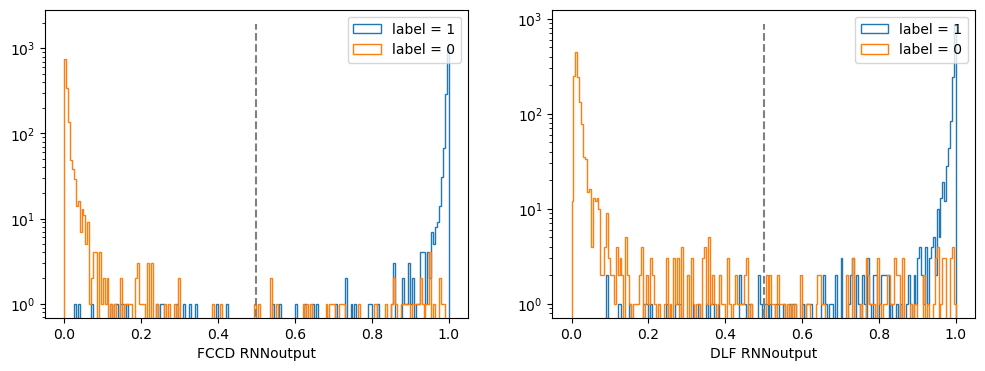

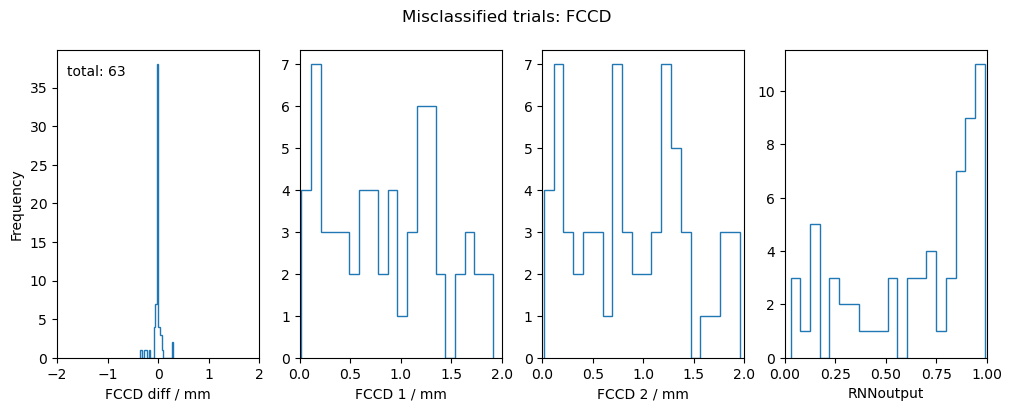

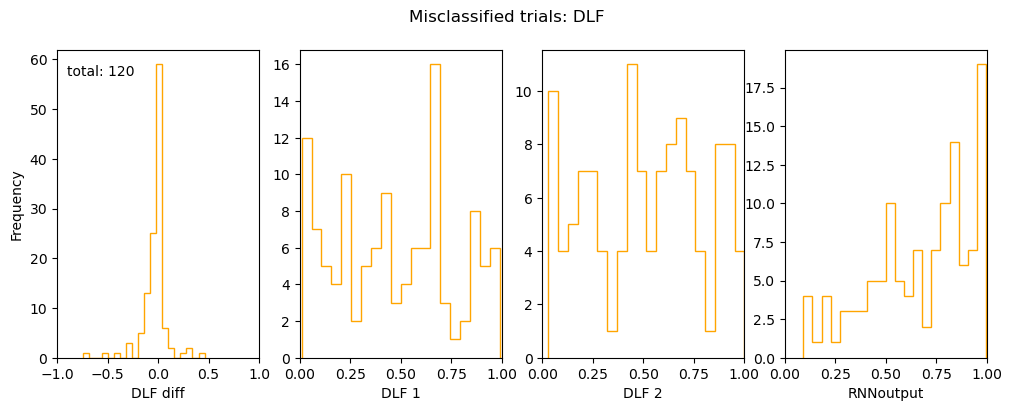

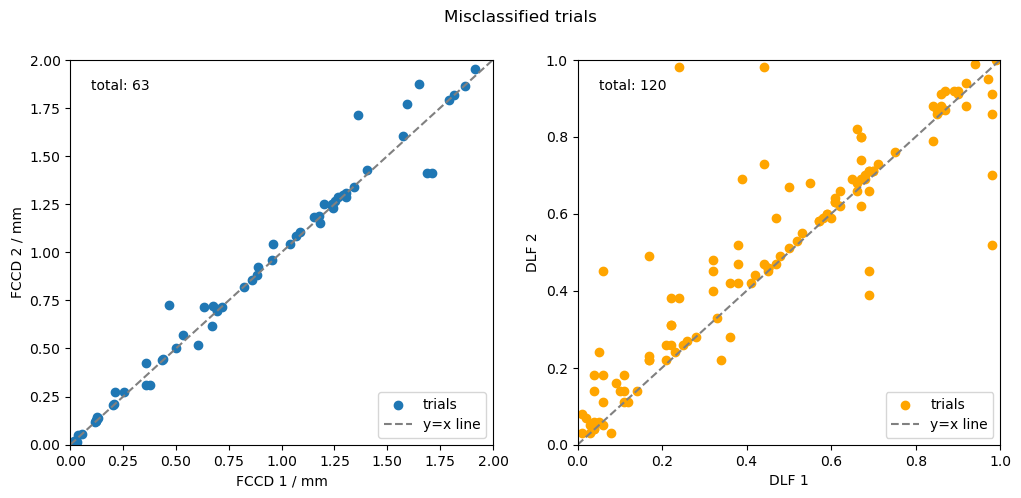

In [12]:
#testing
accuracies_maxFCCDdiff0_5mm = test_RNN(RNNclassifier_maxFCCDdiff0_5mm, test_loader, RNN_ID=RNN_ID, performance_plots = True, misclassified_trials_plots = True, save_results = True)


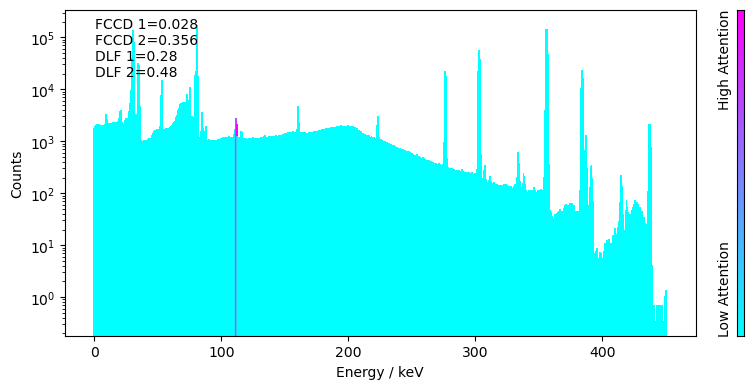

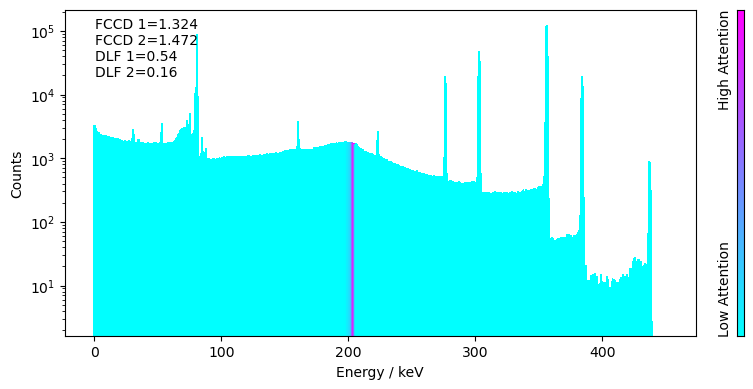

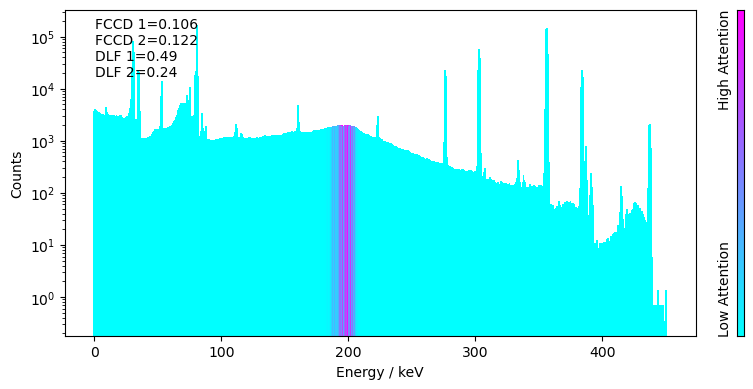

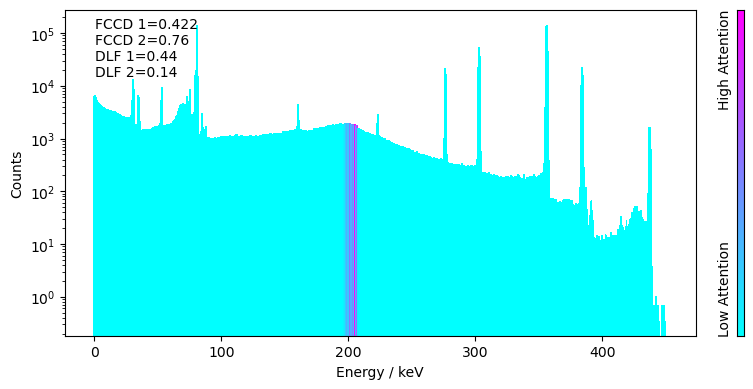

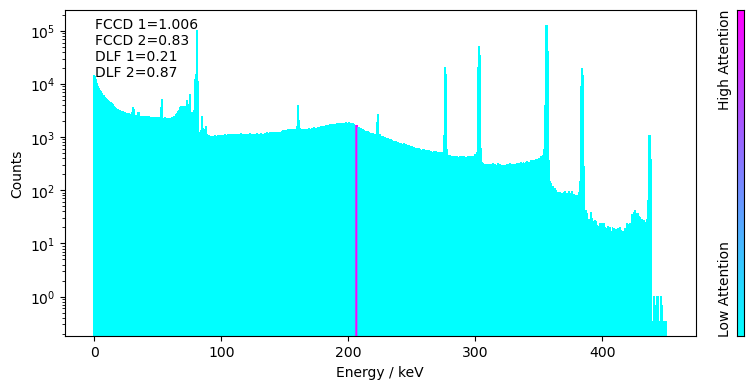

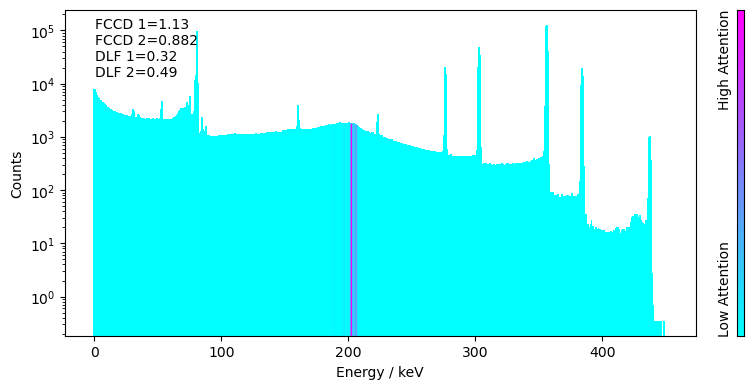

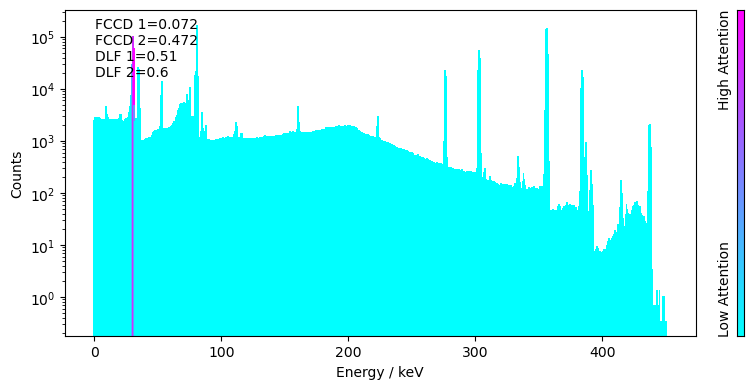

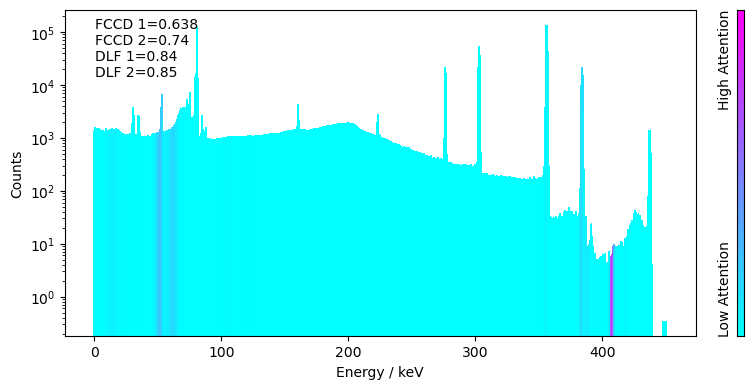

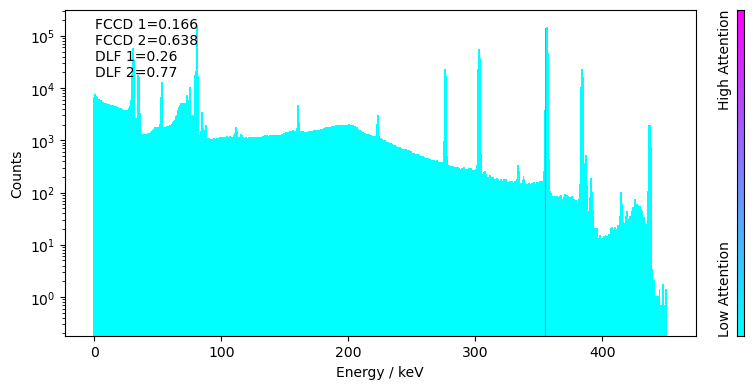

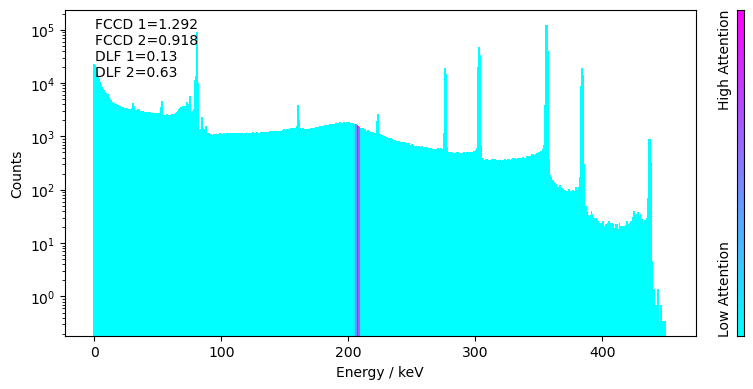

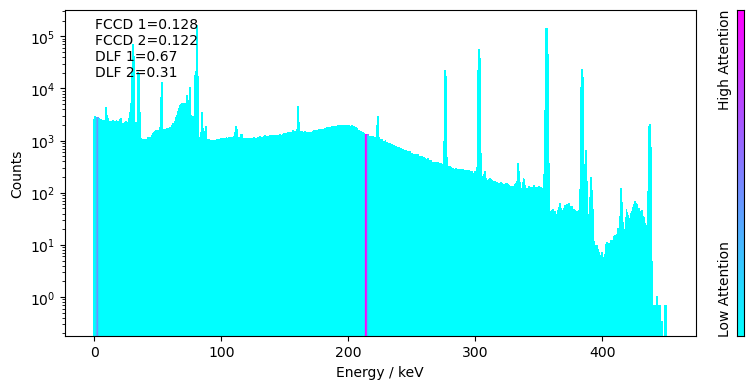

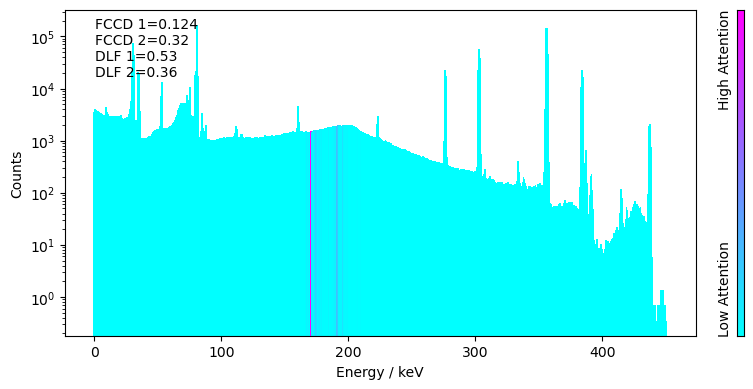

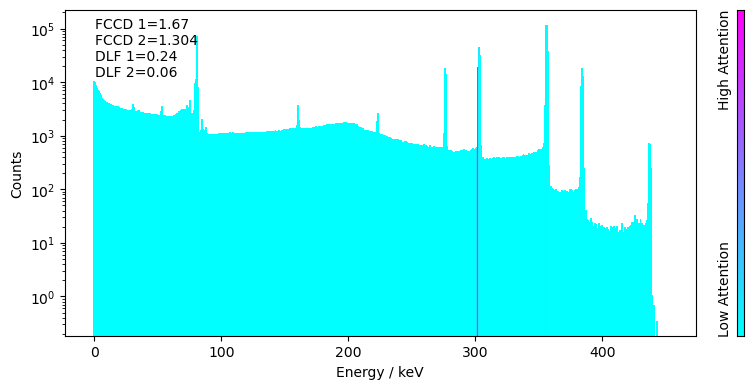

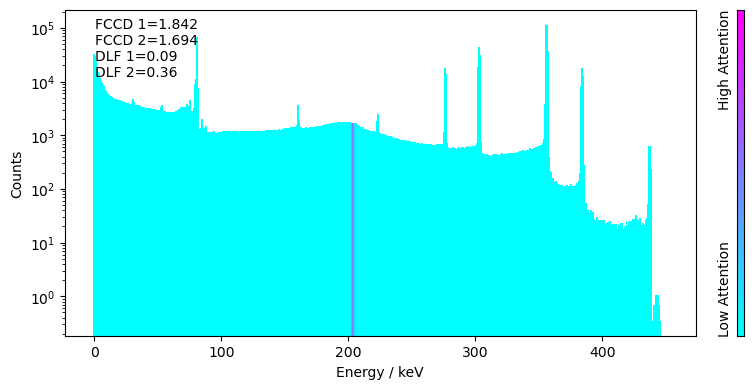

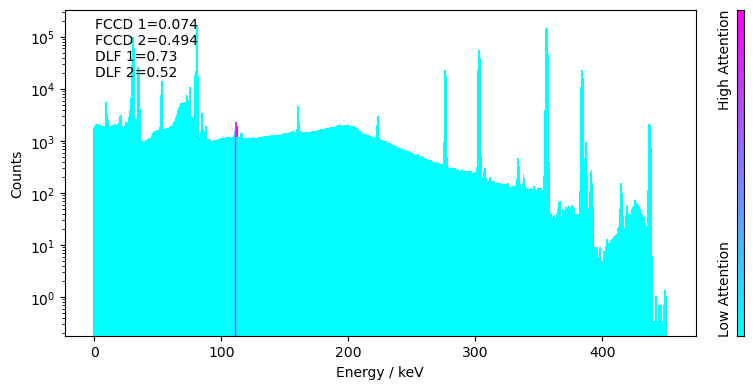

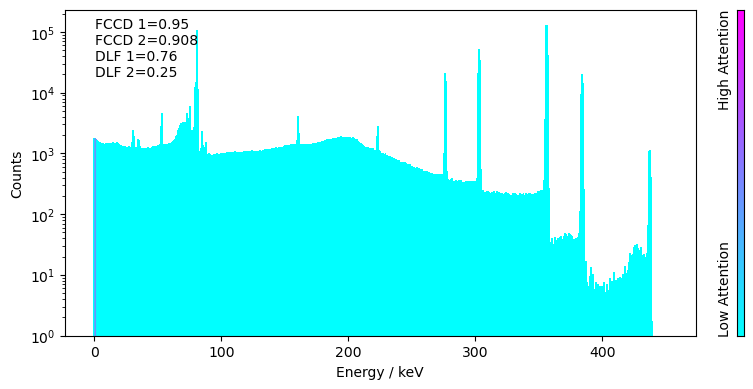

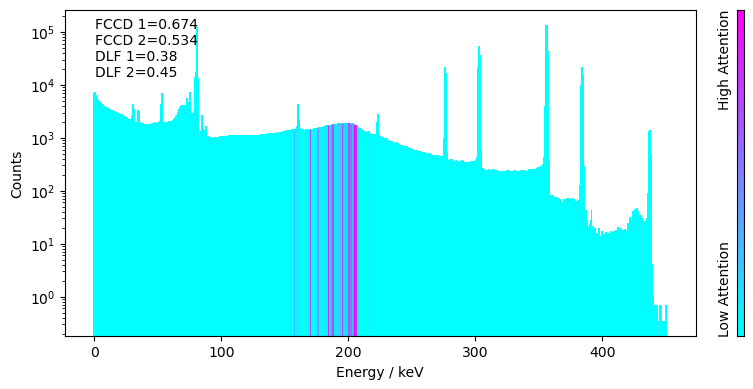

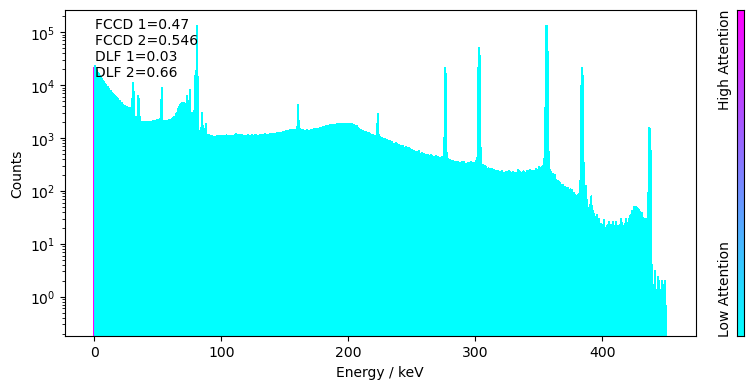

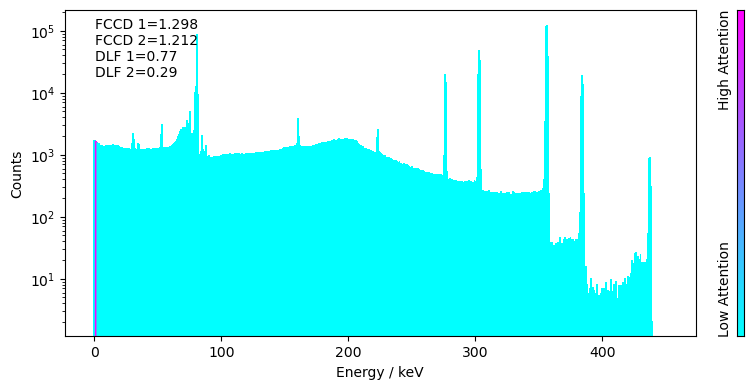

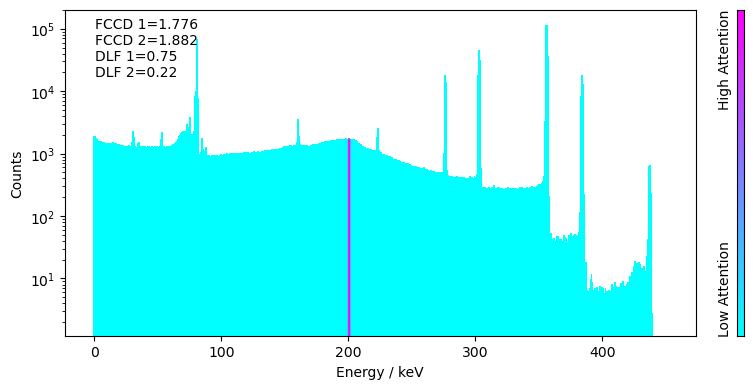

In [13]:
#Investigate Attention

#Make RNNinterpretor object and set get_attention to true
RNNinterpretor = RNN(dataset.get_histlen(),2)
RNNinterpretor.get_attention = True

#Load trained RNN dict to this
RNNinterpretor.load_state_dict(torch.load(model_path))
RNNinterpretor.eval()
RNNinterpretor.to(DEVICE)

import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages(CodePath+"/saved_models/"+RNN_ID+"/plots/test_attention.pdf")
   
for a in range (5):
    #Load a test events through interpretor
    test_spectrum_diff, test_FCCDLabel, test_DLFLabel, test_extras, test_spectrum = next(iter(test_loader))
    test_spectrum_diff = test_spectrum_diff.to(DEVICE).float()

    attention_score = RNNinterpretor(test_spectrum_diff)

    for i in range(BATCH_SIZE):
        attention = attention_score[i].cpu().detach().numpy()
        labels = {"FCCD1": test_extras["FCCD1"][i].item(), "FCCD2": test_extras["FCCD2"][i].item(), "DLF1": test_extras["DLF1"][i].item(), "DLF2": test_extras["DLF2"][i].item()}

        #plot attention score on spectrum
        fig = plot_attention(test_spectrum[i], attention, labels)
        pdf.savefig(fig)

pdf.close()

## Testing - on full dataset

In [14]:
#load full dataset
BATCH_SIZE = 4 
train_loader, test_loader, dataset = load_data(BATCH_SIZE, size=dataset_size)

100%|████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 172.78it/s]

(1000, 900)


100%|███████████████████████████████████████████████████████████████████████████████████████████| 750/750 [01:56<00:00,  6.44it/s]


FCCD accuracies: 
total:  3000
TP:  1461
FP:  28
TN:  1486
FN:  25
accuracy:  0.9823333333333333
precision:  0.9811954331766286
recall:  0.9831763122476447

DLF accuracies: 
total:  3000
TP:  1414
FP:  155
TN:  1343
FN:  88
accuracy:  0.919
precision:  0.9012109623964308
recall:  0.9414114513981359
Total # misclassified trials FCCD:  53  / 3000
Total # misclassified trials DLF:  243  / 3000


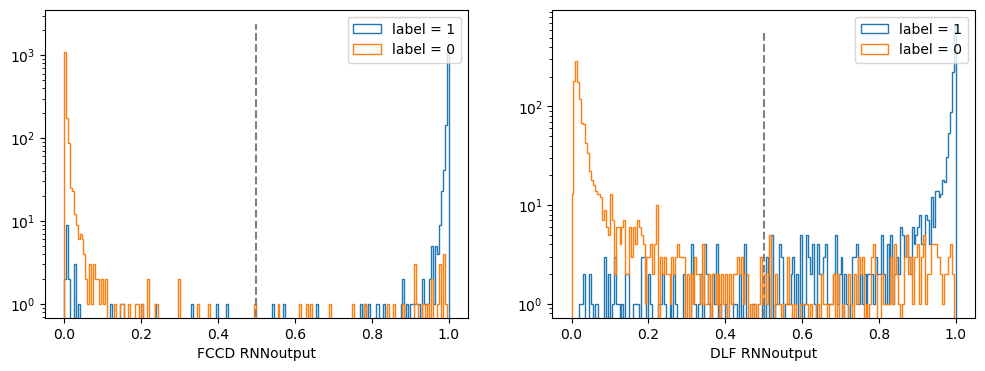

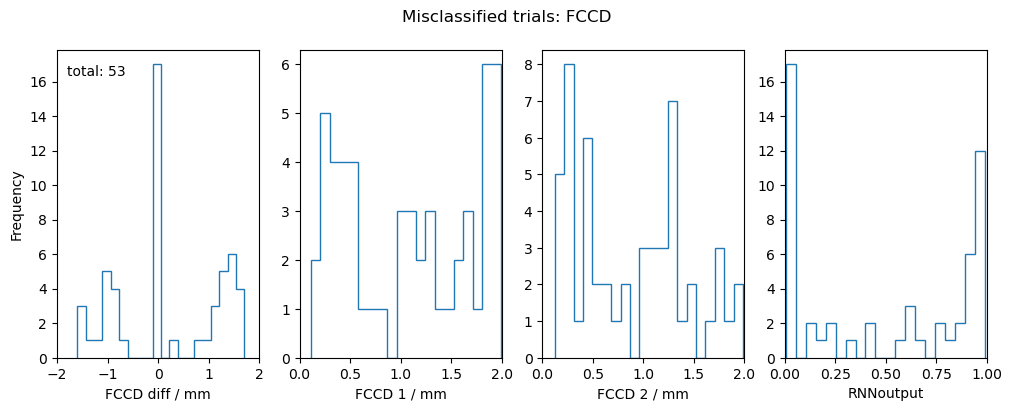

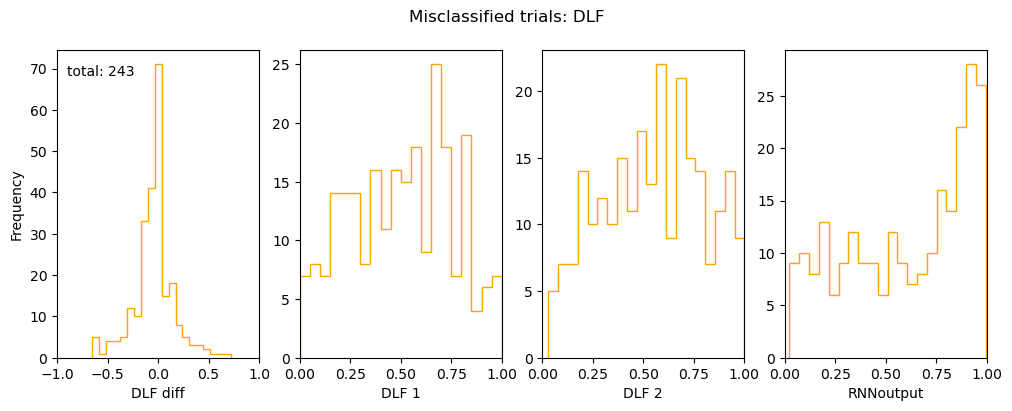

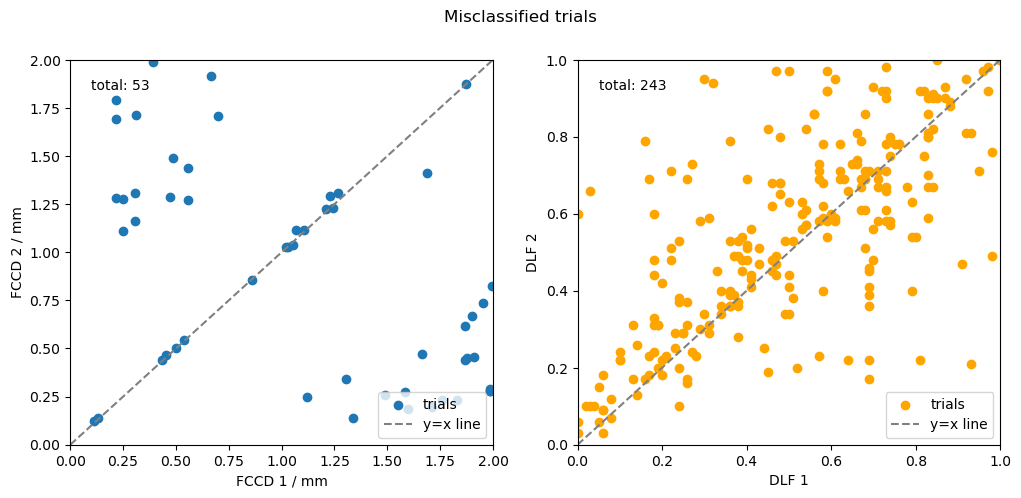

In [15]:
#testing
accuracies_maxFCCDdiff0_5mm = test_RNN(RNNclassifier_maxFCCDdiff0_5mm, test_loader, RNN_ID=RNN_ID, performance_plots = True, misclassified_trials_plots = True, save_results = True, train_restricted_test_fulldataset = True)


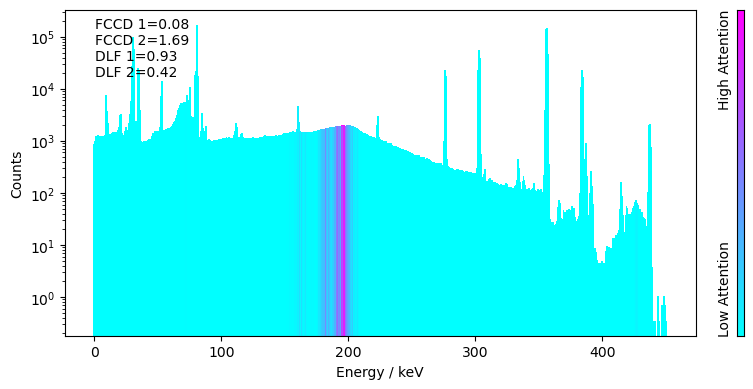

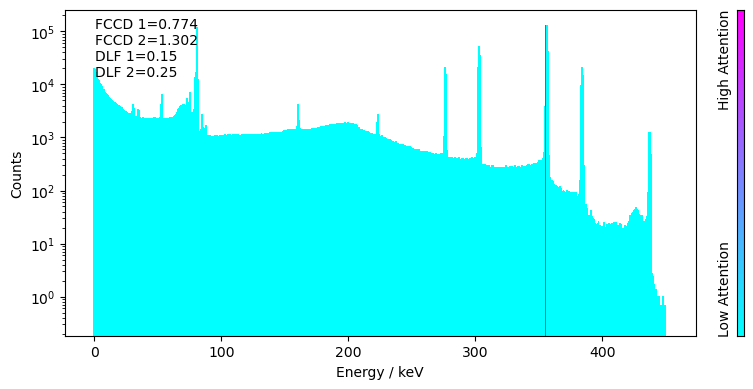

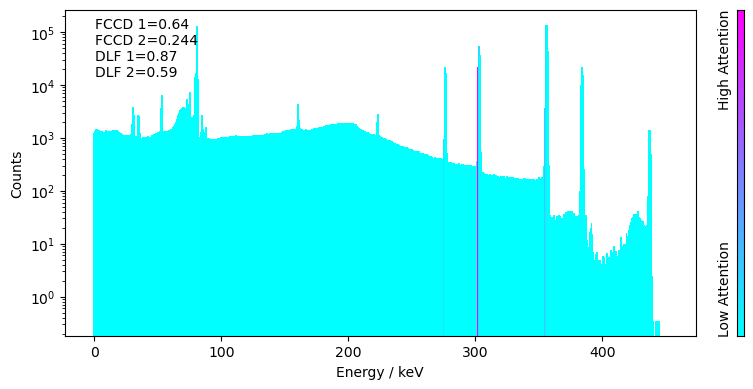

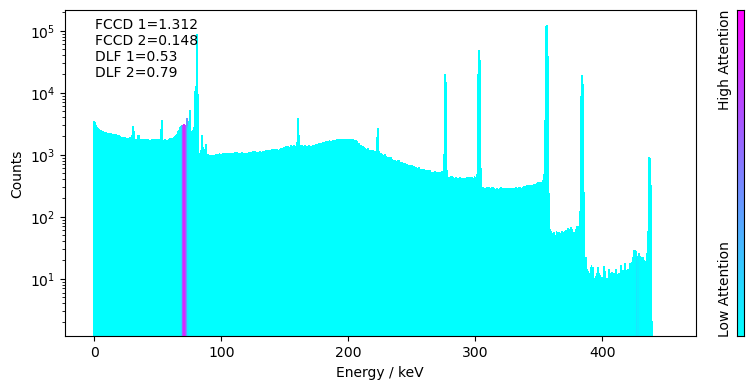

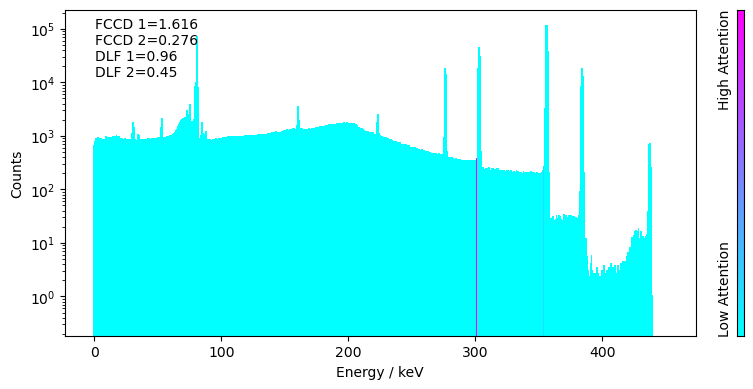

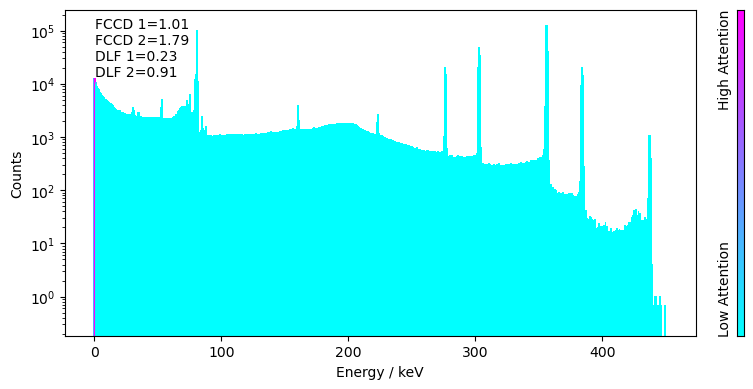

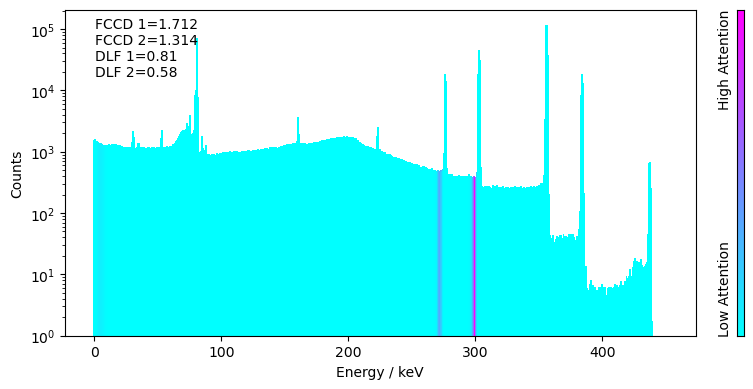

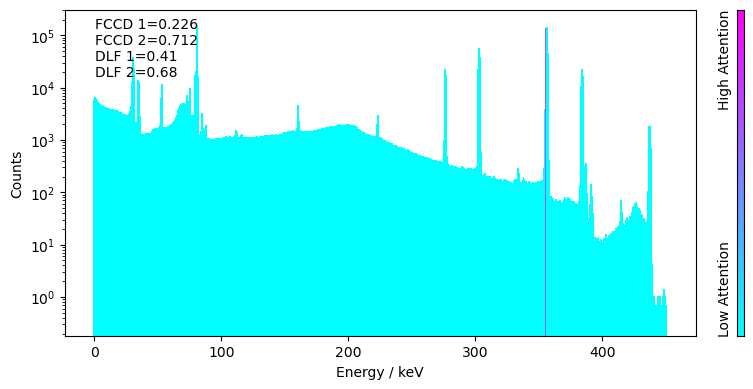

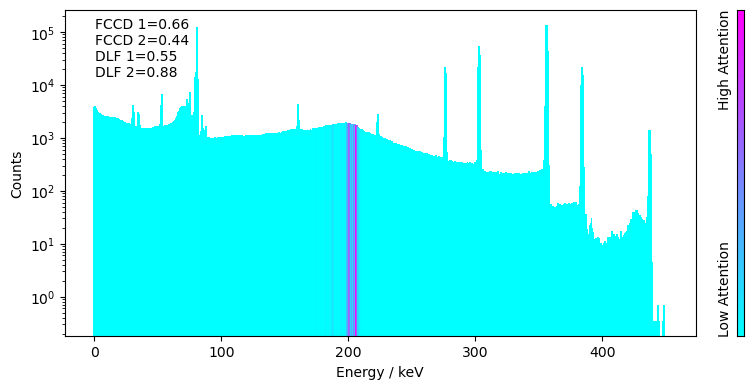

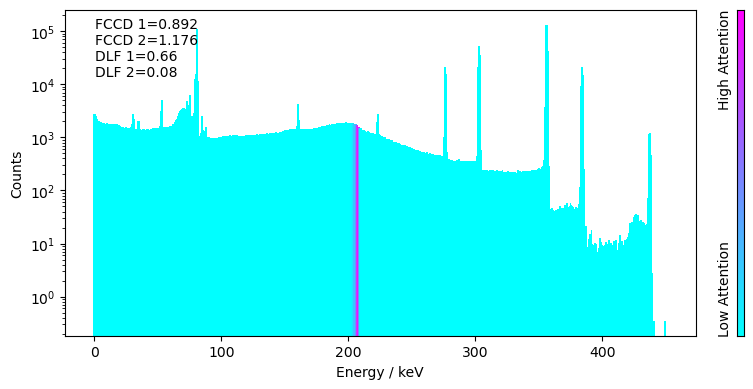

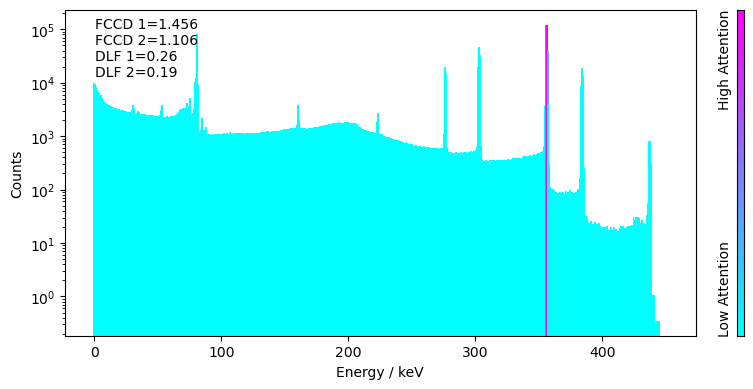

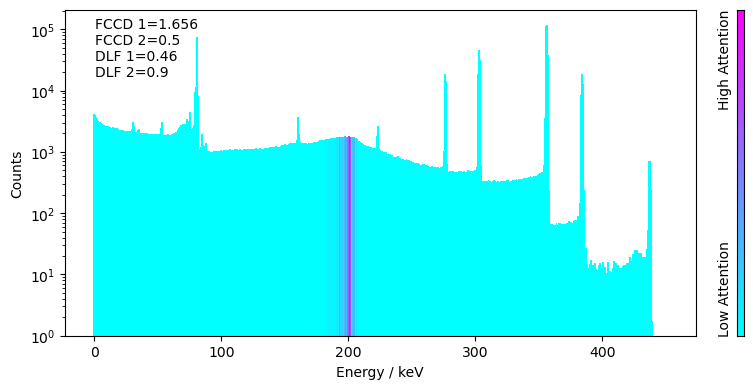

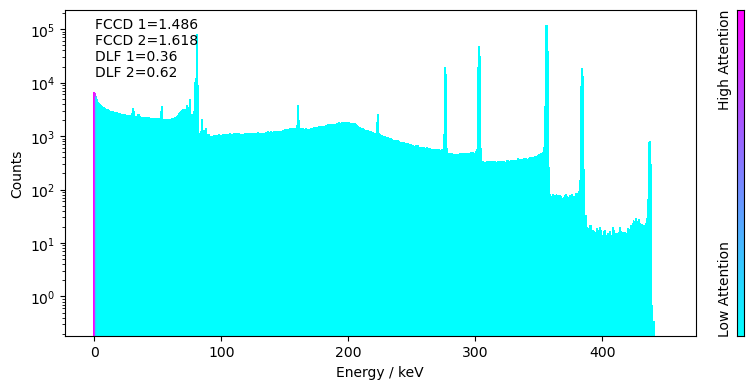

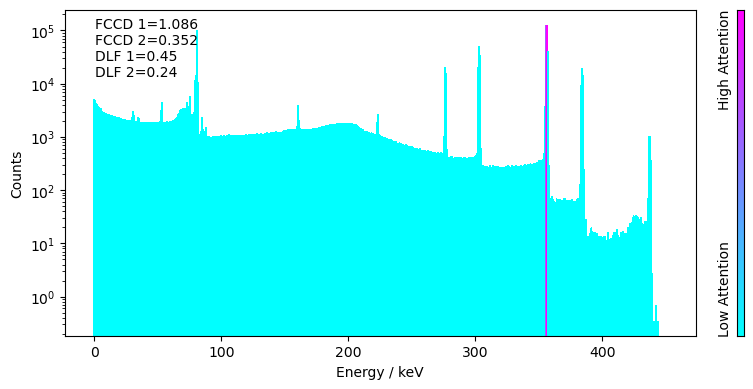

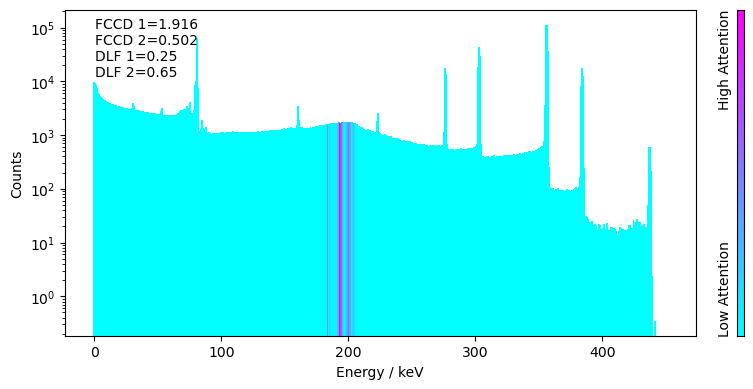

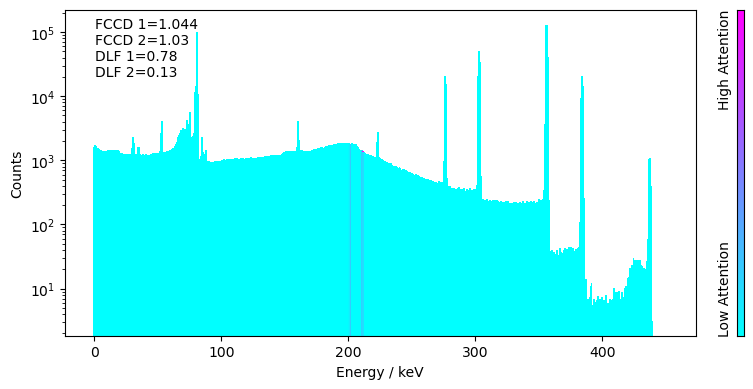

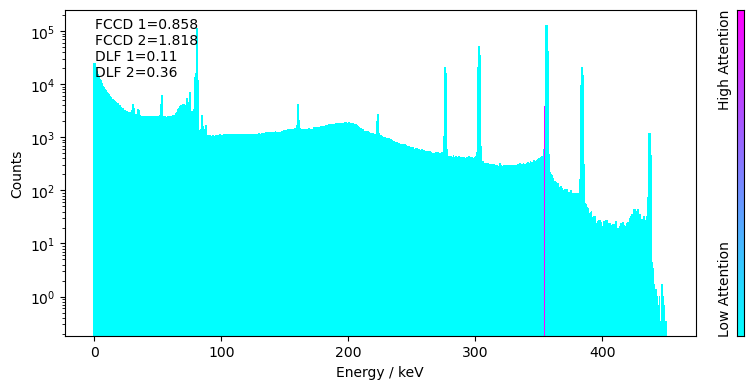

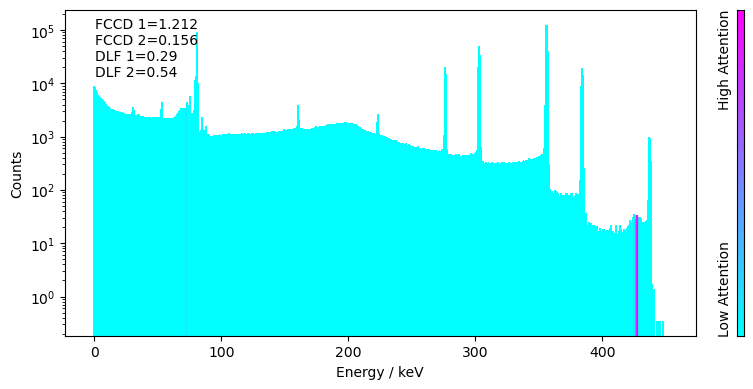

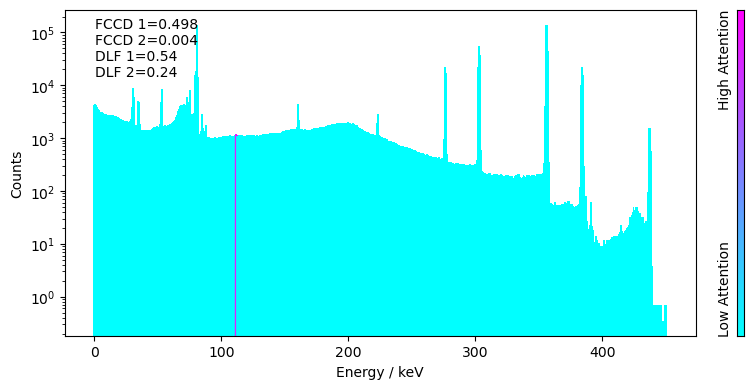

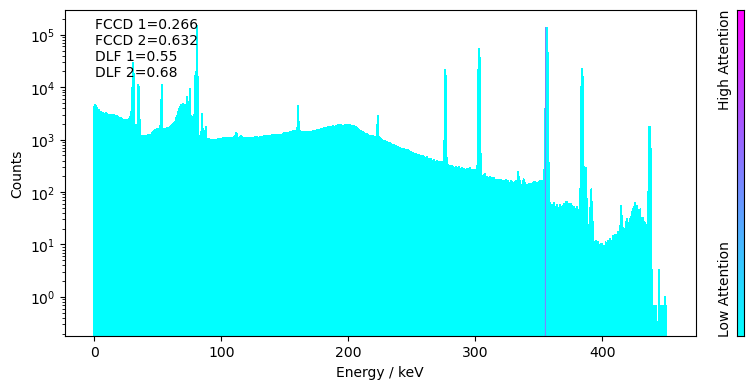

In [16]:
#Investigate Attention

#Make RNNinterpretor object and set get_attention to true
RNNinterpretor = RNN(dataset.get_histlen(),2)
RNNinterpretor.get_attention = True

#Load trained RNN dict to this
RNNinterpretor.load_state_dict(torch.load(model_path))
RNNinterpretor.eval()
RNNinterpretor.to(DEVICE)

import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages(CodePath+"/saved_models/"+RNN_ID+"/plots/test_attention_fulldataset.pdf")
   
for a in range (5):
    #Load a test events through interpretor
    test_spectrum_diff, test_FCCDLabel, test_DLFLabel, test_extras, test_spectrum = next(iter(test_loader))
    test_spectrum_diff = test_spectrum_diff.to(DEVICE).float()

    attention_score = RNNinterpretor(test_spectrum_diff)

    for i in range(BATCH_SIZE):
        attention = attention_score[i].cpu().detach().numpy()
        labels = {"FCCD1": test_extras["FCCD1"][i].item(), "FCCD2": test_extras["FCCD2"][i].item(), "DLF1": test_extras["DLF1"][i].item(), "DLF2": test_extras["DLF2"][i].item()}

        #plot attention score on spectrum
        fig = plot_attention(test_spectrum[i], attention, labels)
        pdf.savefig(fig)

pdf.close()

# TRAINING 3: restircted dataset - Max FCCD diff = 0.25 mm

Only train on FCCDs with a max diff of 0.25 mm

In [25]:
NUM_EPOCHS = 20 #can try increasing
LEARNING_RATE = 0.005 #0.01 #try modifying learning rate #0.001 too low for 30 epochs, 0.01 may be too high
dataset_size = 10000

maxFCCDdiff = 0.25
maxDLFdiff = 1.0 #i.e. no restriction
RNN_ID ="RNN_"+str(NUM_EPOCHS)+"epochs_LR"+str(LEARNING_RATE)+"_maxFCCDdiff"+str(maxFCCDdiff)+"mm_"+str(dataset_size)+"trials"

#initialise directories to save
if not os.path.exists(CodePath+"/saved_models/"+RNN_ID+"/plots/"):
    os.makedirs(CodePath+"/saved_models/"+RNN_ID+"/plots/")

## Training - DO NOT RERUN UNLESS NECESARRY

In [ ]:
#Load dataset
BATCH_SIZE = 4 
restrict_dict = {"maxFCCDdiff": maxFCCDdiff, "maxDLFdiff": maxDLFdiff}
train_loader, test_loader, dataset = load_data(BATCH_SIZE, restrict_dataset=True, restrict_dict = restrict_dict, size=dataset_size)

#train RNN
FCCD_accuracy_values, DLF_accuracy_values, loss_values = train_RNN(dataset, train_loader, test_loader, NUM_EPOCHS, LEARNING_RATE, saveRNN=True, plot_training_results = True, RNN_ID = RNN_ID)


In [ ]:
#Training Results
training_results(NUM_EPOCHS, loss_values, FCCD_accuracy_values, DLF_accuracy_values, save_plots = False, RNN_ID = RNN_ID)


## Testing - on maxFCCDdiff=0.25mm

In [26]:
#Load restricted dataset
BATCH_SIZE = 4 
restrict_dict = {"maxFCCDdiff": maxFCCDdiff, "maxDLFdiff": maxDLFdiff}
train_loader, test_loader, dataset = load_data(BATCH_SIZE, restrict_dataset=True, restrict_dict = restrict_dict, size=dataset_size)


100%|████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 199.70it/s]

(1000, 900)


In [27]:
# Load saved model
RNNclassifier_maxFCCDdiff0_25mm = RNN(dataset.get_histlen(),2)
model_path = CodePath+"/saved_models/"+RNN_ID+"/"+RNN_ID+".pkl"
RNNclassifier_maxFCCDdiff0_25mm.load_state_dict(torch.load(model_path))
RNNclassifier_maxFCCDdiff0_25mm.eval()

RNN(
  (RNNLayer): GRU(1, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fcnet): FCNet(
    (fcnet): Sequential(
      (0): Linear(in_features=1024, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=256, out_features=2, bias=True)
    )
  )
  (attention_weight): Linear(in_features=512, out_features=512, bias=False)
)

 63%|████████████████████████████████████████████████████████▉                                  | 469/750 [00:40<00:26, 10.56it/s]

DLF and FCCD misclassified for same trial:
j:  467 , i:  3
FCCD1:  0.958 , FCCD2:  0.908 , FCCD_diff:  0.04999999999999993 , RNNoutput:  0.12765498
DLF1:  0.41 , DLF2:  0.42 , DLF_diff:  -0.010000000000000009 , RNNoutput:  0.5049818


 79%|███████████████████████████████████████████████████████████████████████▋                   | 591/750 [00:50<00:12, 12.61it/s]

DLF and FCCD misclassified for same trial:
j:  588 , i:  2
FCCD1:  1.114 , FCCD2:  1.036 , FCCD_diff:  0.07800000000000007 , RNNoutput:  0.045080587
DLF1:  0.47 , DLF2:  0.48 , DLF_diff:  -0.010000000000000009 , RNNoutput:  0.6388019


100%|███████████████████████████████████████████████████████████████████████████████████████████| 750/750 [01:04<00:00, 11.56it/s]


FCCD accuracies: 
total:  3000
TP:  1449
FP:  63
TN:  1439
FN:  49
accuracy:  0.9626666666666667
precision:  0.9583333333333334
recall:  0.9672897196261683

DLF accuracies: 
total:  3000
TP:  1419
FP:  38
TN:  1507
FN:  36
accuracy:  0.9753333333333334
precision:  0.9739190116678106
recall:  0.9752577319587629
Total # misclassified trials FCCD:  112  / 3000
Total # misclassified trials DLF:  74  / 3000


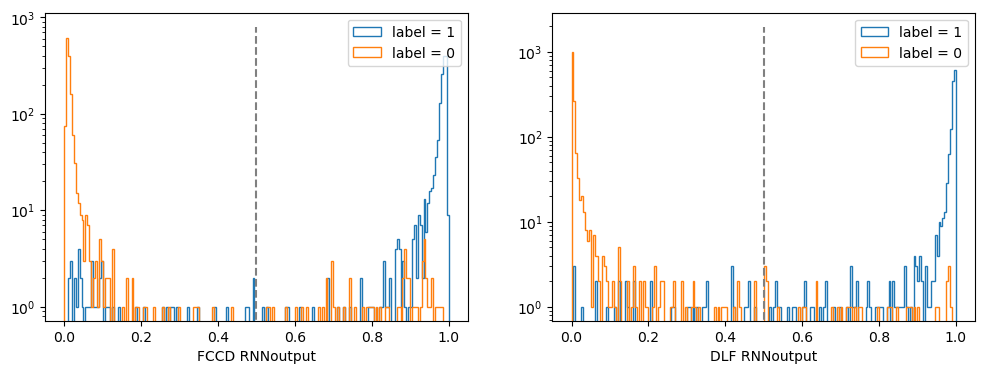

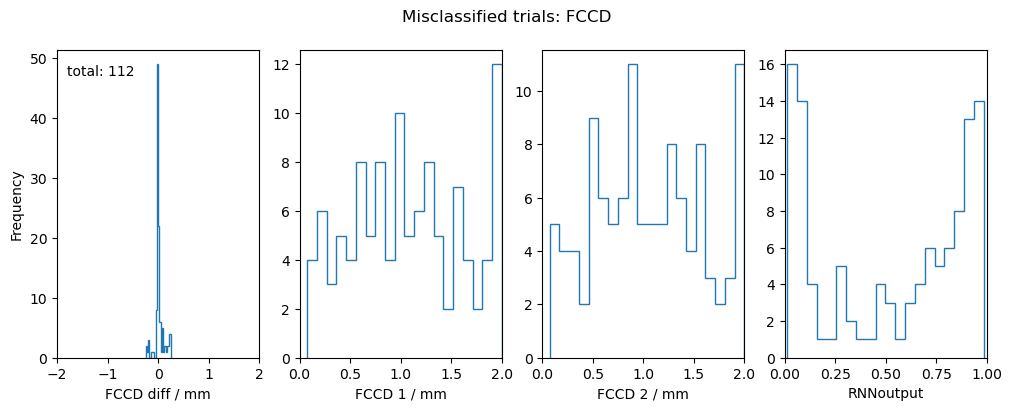

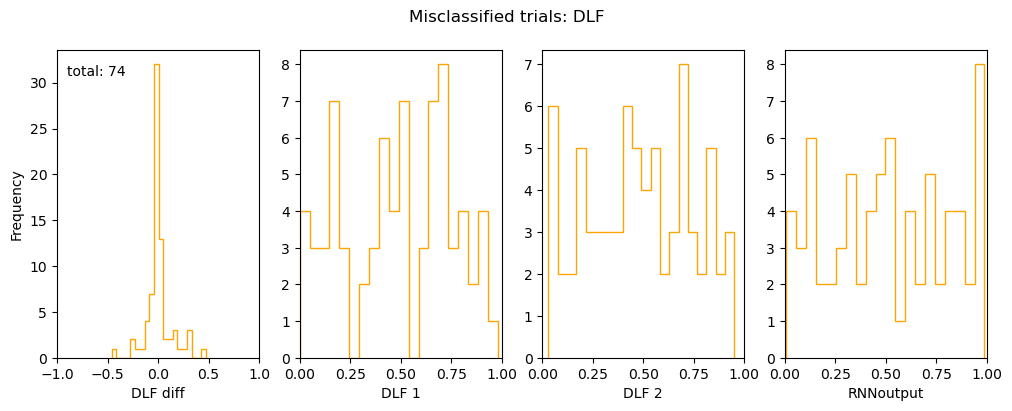

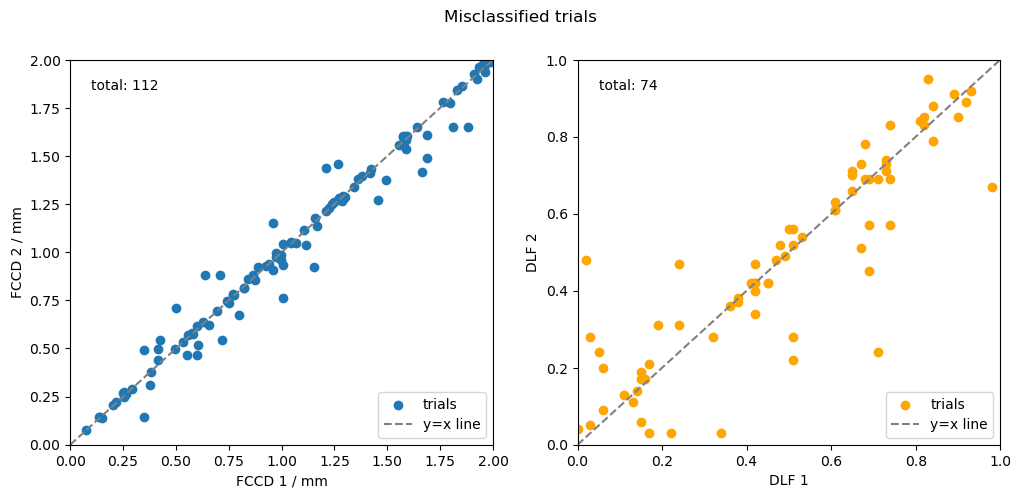

In [28]:
#testing
accuracies_maxFCCDdiff0_25mm = test_RNN(RNNclassifier_maxFCCDdiff0_25mm, test_loader, RNN_ID=RNN_ID, performance_plots = True, misclassified_trials_plots = True, save_results = True)


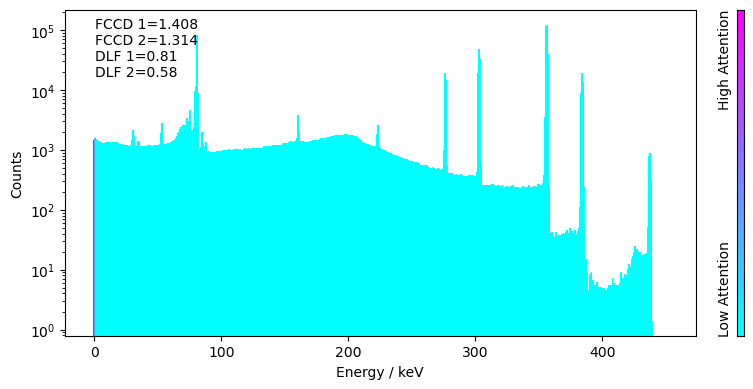

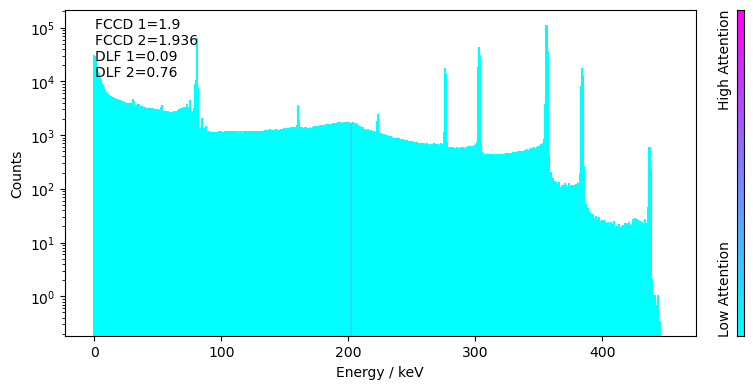

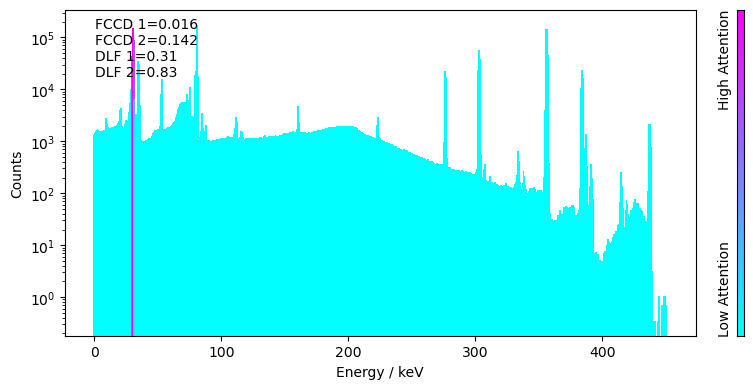

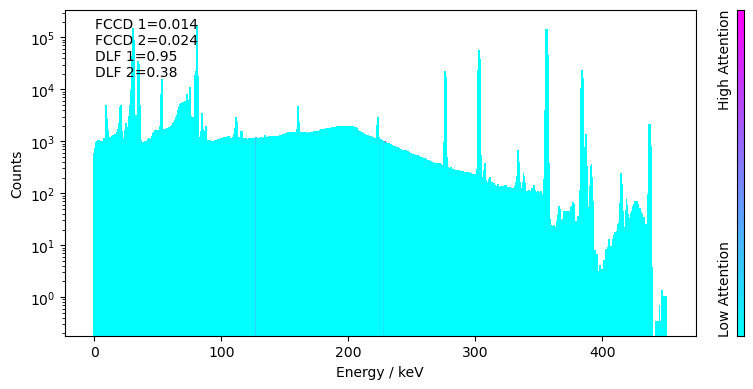

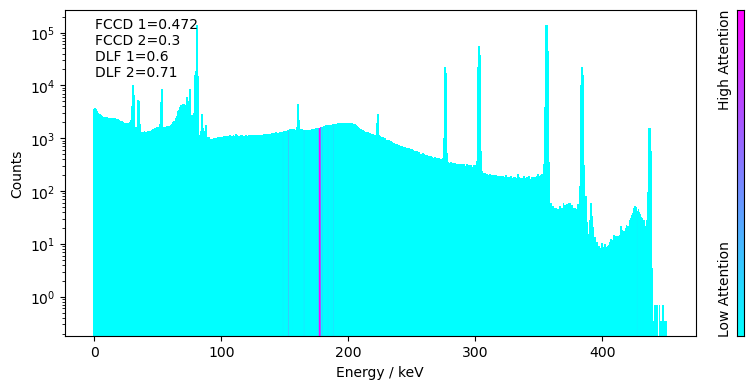

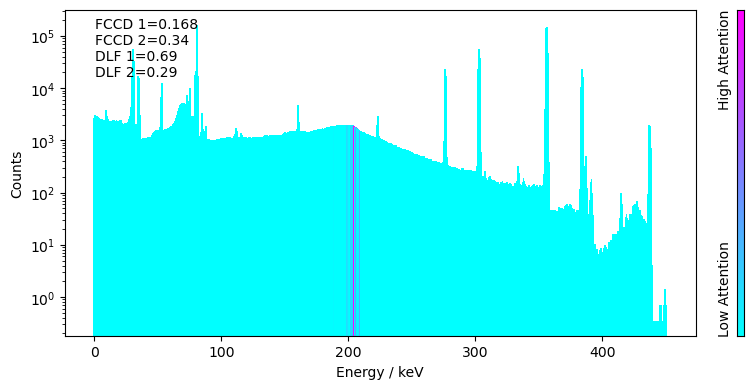

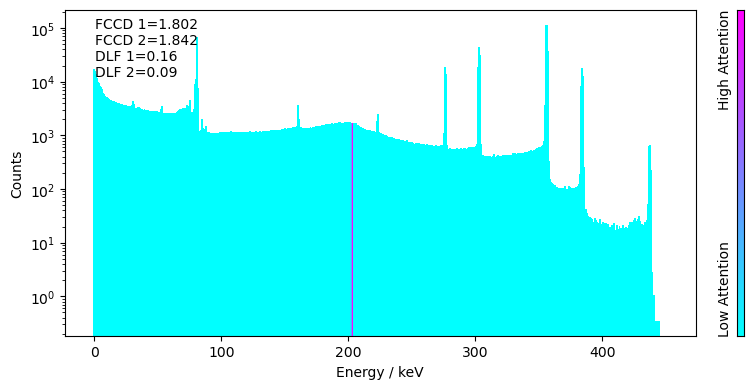

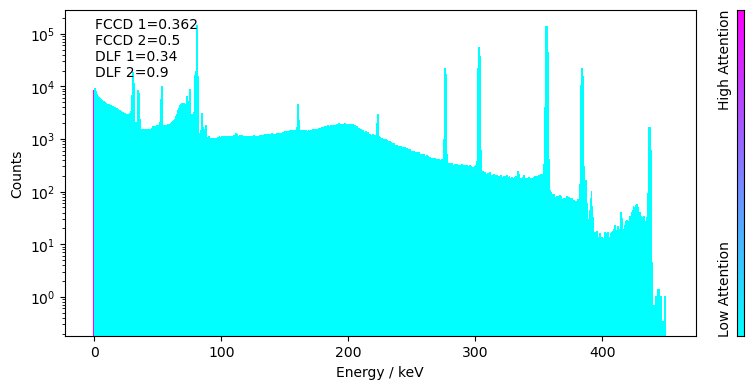

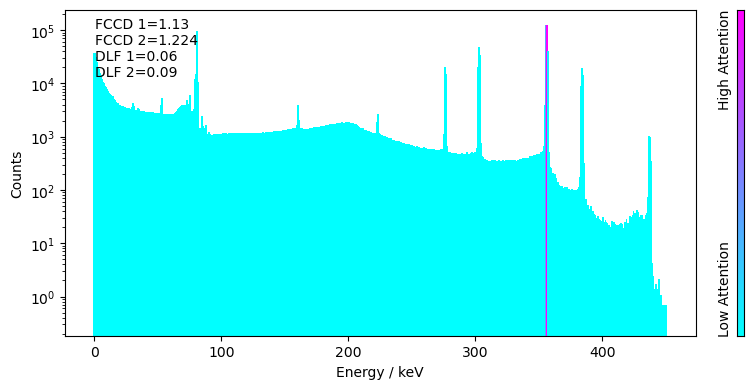

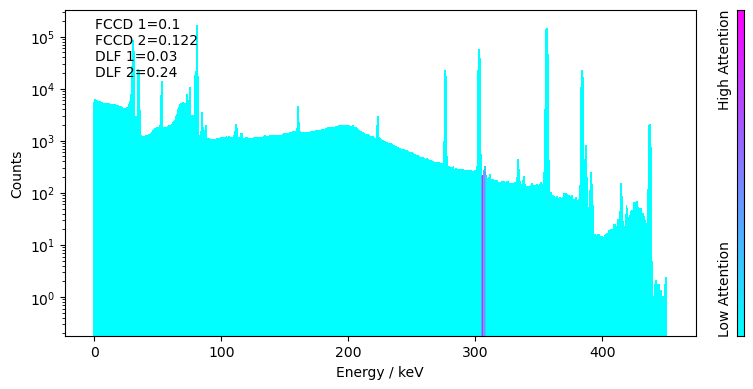

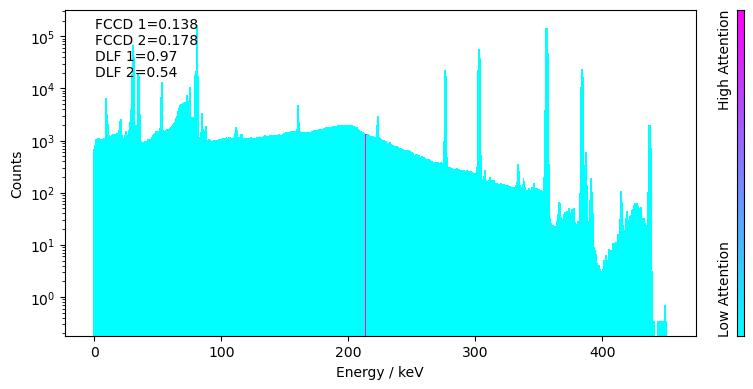

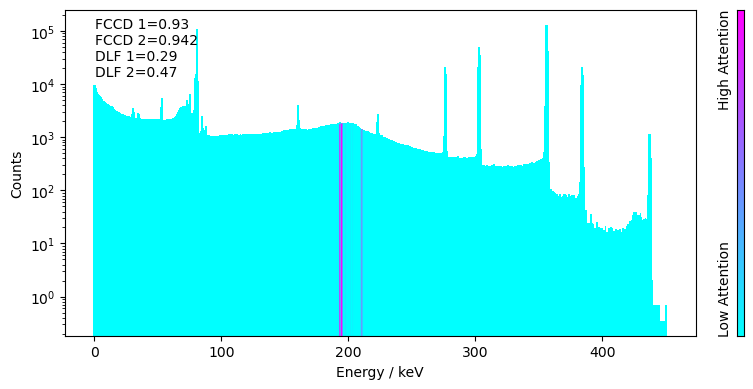

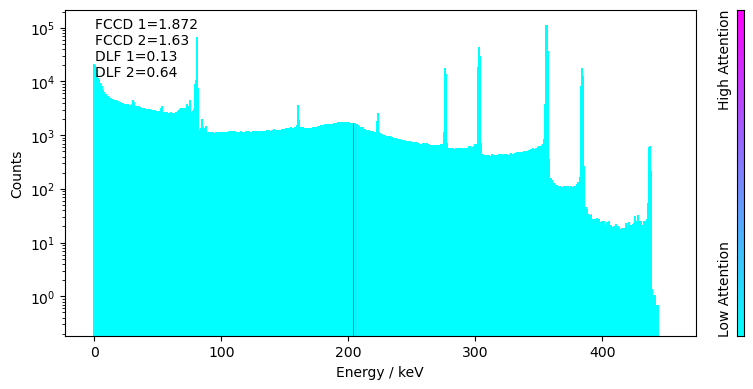

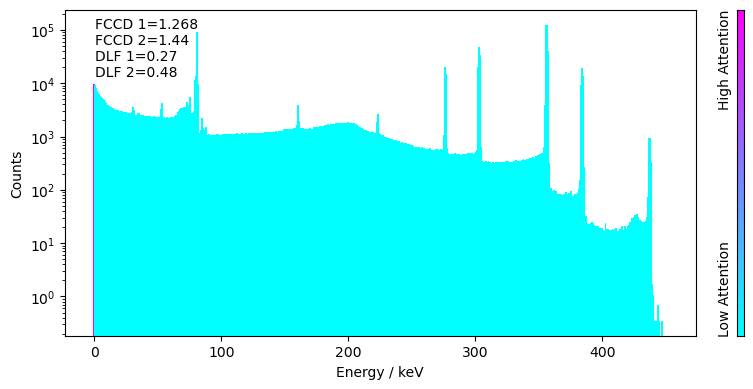

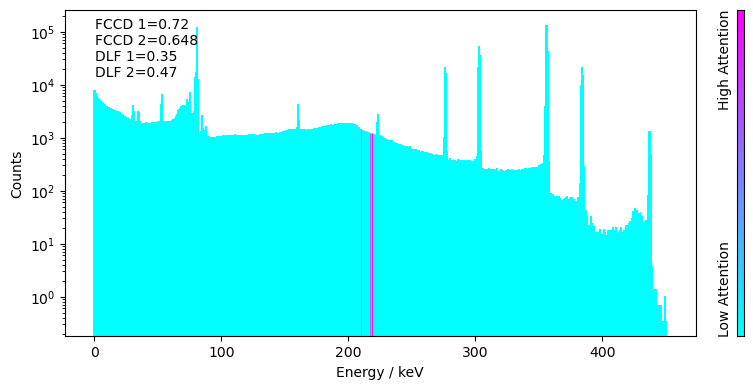

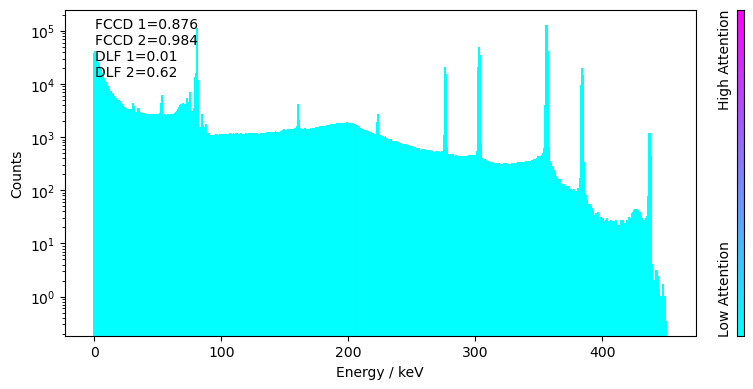

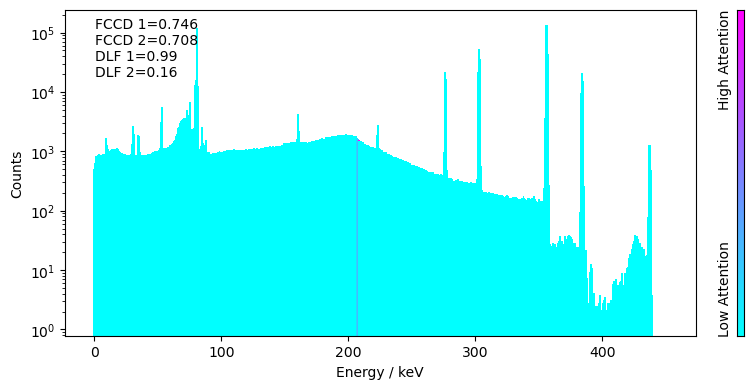

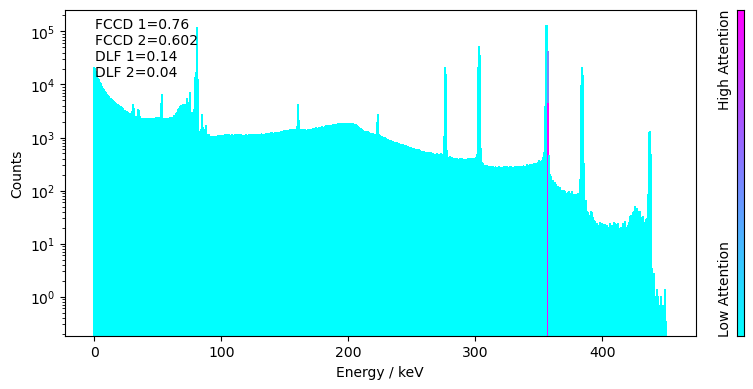

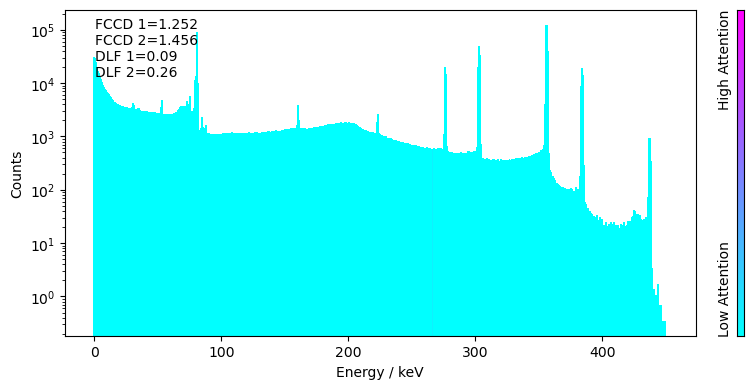

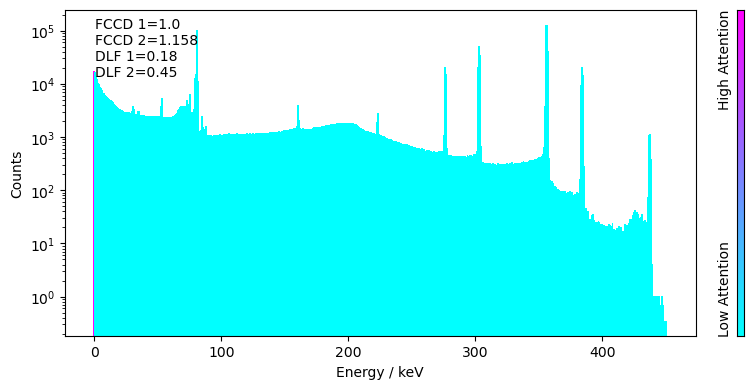

In [29]:
#Investigate Attention

#Make RNNinterpretor object and set get_attention to true
RNNinterpretor = RNN(dataset.get_histlen(),2)
RNNinterpretor.get_attention = True

#Load trained RNN dict to this
RNNinterpretor.load_state_dict(torch.load(model_path))
RNNinterpretor.eval()
RNNinterpretor.to(DEVICE)

import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages(CodePath+"/saved_models/"+RNN_ID+"/plots/test_attention.pdf")
   
for a in range (5):
    #Load a test events through interpretor
    test_spectrum_diff, test_FCCDLabel, test_DLFLabel, test_extras, test_spectrum = next(iter(test_loader))
    test_spectrum_diff = test_spectrum_diff.to(DEVICE).float()

    attention_score = RNNinterpretor(test_spectrum_diff)

    for i in range(BATCH_SIZE):
        attention = attention_score[i].cpu().detach().numpy()
        labels = {"FCCD1": test_extras["FCCD1"][i].item(), "FCCD2": test_extras["FCCD2"][i].item(), "DLF1": test_extras["DLF1"][i].item(), "DLF2": test_extras["DLF2"][i].item()}

        #plot attention score on spectrum
        fig = plot_attention(test_spectrum[i], attention, labels)
        pdf.savefig(fig)

pdf.close()

## Testing - on full dataset

In [30]:
#load full dataset
BATCH_SIZE = 4 
train_loader, test_loader, dataset = load_data(BATCH_SIZE, size=dataset_size)

100%|████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.21it/s]

(1000, 900)


  1%|▍                                                                                            | 4/750 [00:00<01:19,  9.41it/s]

DLF and FCCD misclassified for same trial:
j:  1 , i:  3
FCCD1:  1.992 , FCCD2:  0.212 , FCCD_diff:  1.78 , RNNoutput:  0.01308044
DLF1:  0.32 , DLF2:  0.29 , DLF_diff:  0.030000000000000027 , RNNoutput:  0.10669709


  8%|███████▌                                                                                    | 62/750 [00:06<01:11,  9.63it/s]

DLF and FCCD misclassified for same trial:
j:  60 , i:  2
FCCD1:  0.106 , FCCD2:  1.794 , FCCD_diff:  -1.688 , RNNoutput:  0.9106068
DLF1:  0.49 , DLF2:  0.59 , DLF_diff:  -0.09999999999999998 , RNNoutput:  0.572039


 30%|██████████████████████████▉                                                                | 222/750 [00:21<00:47, 11.13it/s]

DLF and FCCD misclassified for same trial:
j:  220 , i:  1
FCCD1:  1.526 , FCCD2:  0.308 , FCCD_diff:  1.218 , RNNoutput:  0.01252697
DLF1:  0.3 , DLF2:  0.29 , DLF_diff:  0.010000000000000009 , RNNoutput:  0.21233512


 42%|█████████████████████████████████████▉                                                     | 313/750 [00:29<00:39, 11.17it/s]

DLF and FCCD misclassified for same trial:
j:  310 , i:  1
FCCD1:  0.178 , FCCD2:  1.996 , FCCD_diff:  -1.818 , RNNoutput:  0.9078939
DLF1:  0.54 , DLF2:  0.62 , DLF_diff:  -0.07999999999999996 , RNNoutput:  0.56862557


 47%|██████████████████████████████████████████▎                                                | 349/750 [00:32<00:36, 11.10it/s]

DLF and FCCD misclassified for same trial:
j:  347 , i:  1
FCCD1:  0.264 , FCCD2:  1.704 , FCCD_diff:  -1.44 , RNNoutput:  0.90257746
DLF1:  0.53 , DLF2:  0.55 , DLF_diff:  -0.020000000000000018 , RNNoutput:  0.515644


 87%|███████████████████████████████████████████████████████████████████████████████▎           | 654/750 [01:00<00:08, 11.18it/s]

DLF and FCCD misclassified for same trial:
j:  652 , i:  2
FCCD1:  1.91 , FCCD2:  0.146 , FCCD_diff:  1.764 , RNNoutput:  0.017832035
DLF1:  0.64 , DLF2:  0.61 , DLF_diff:  0.030000000000000027 , RNNoutput:  0.42897755


 88%|███████████████████████████████████████████████████████████████████████████████▊           | 658/750 [01:00<00:08, 11.21it/s]

DLF and FCCD misclassified for same trial:
j:  656 , i:  0
FCCD1:  0.308 , FCCD2:  1.344 , FCCD_diff:  -1.036 , RNNoutput:  0.8801547
DLF1:  0.74 , DLF2:  0.67 , DLF_diff:  0.06999999999999995 , RNNoutput:  0.48131853


100%|███████████████████████████████████████████████████████████████████████████████████████████| 750/750 [01:09<00:00, 10.87it/s]


DLF and FCCD misclassified for same trial:
j:  749 , i:  3
FCCD1:  0.368 , FCCD2:  1.986 , FCCD_diff:  -1.6179999999999999 , RNNoutput:  0.92839473
DLF1:  0.39 , DLF2:  0.51 , DLF_diff:  -0.12 , RNNoutput:  0.5589907
FCCD accuracies: 
total:  3000
TP:  1277
FP:  213
TN:  1301
FN:  209
accuracy:  0.8593333333333333
precision:  0.8570469798657718
recall:  0.8593539703903096

DLF accuracies: 
total:  3000
TP:  1236
FP:  120
TN:  1378
FN:  266
accuracy:  0.8713333333333333
precision:  0.911504424778761
recall:  0.8229027962716379
Total # misclassified trials FCCD:  422  / 3000
Total # misclassified trials DLF:  386  / 3000


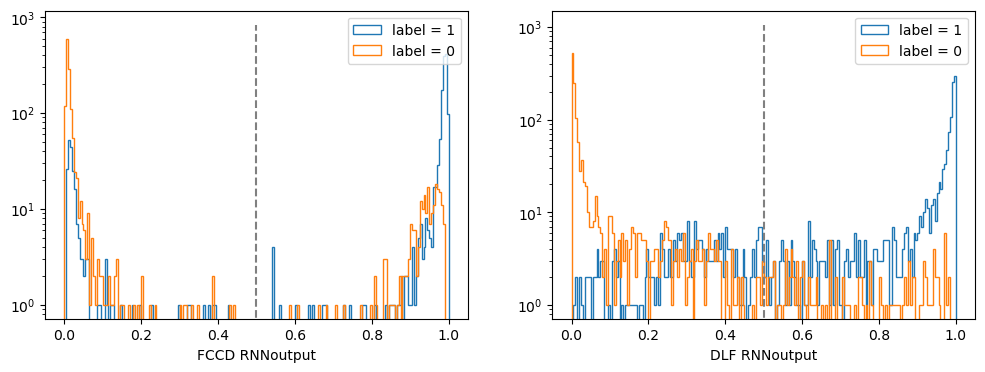

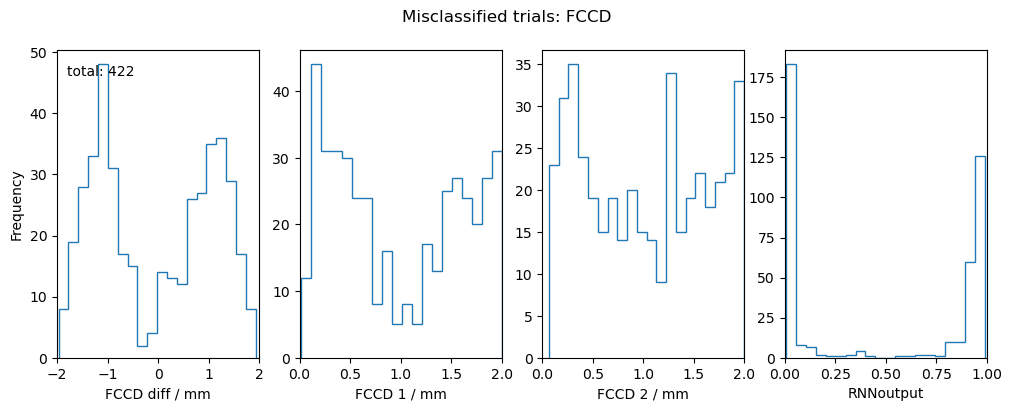

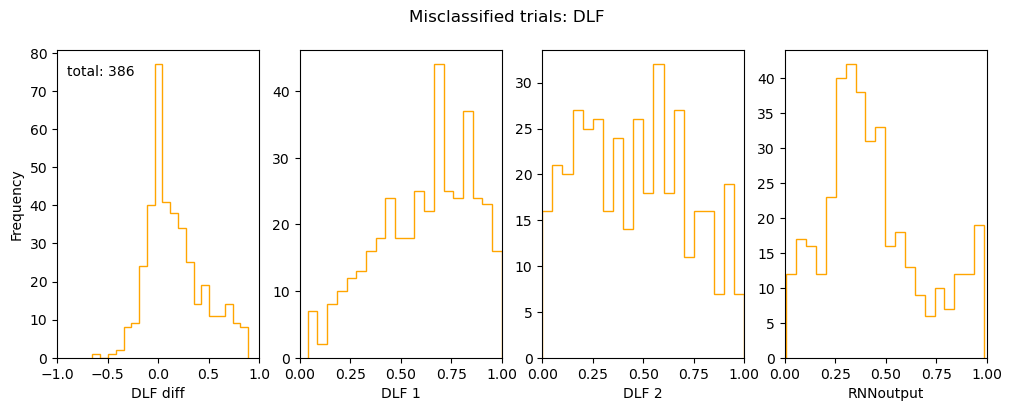

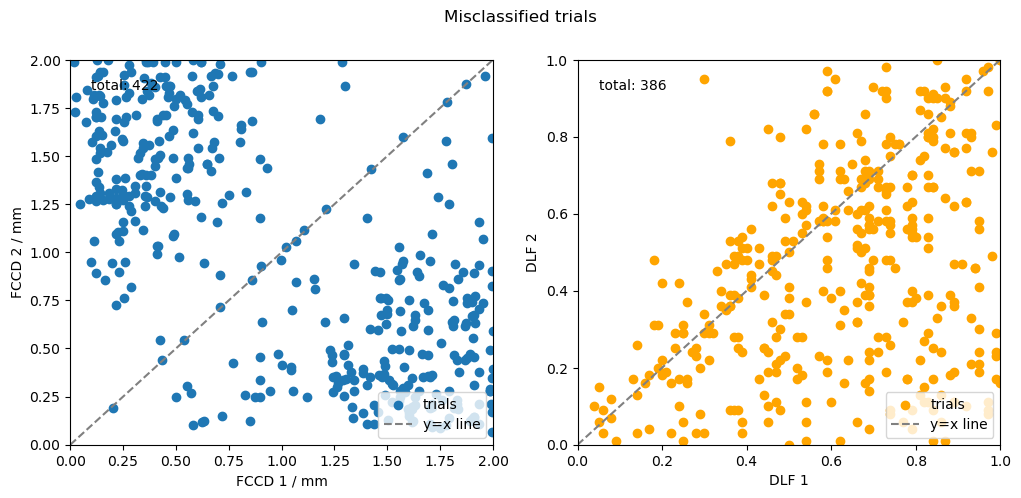

In [31]:
#testing
accuracies_maxFCCDdiff0_25mm = test_RNN(RNNclassifier_maxFCCDdiff0_25mm, test_loader, RNN_ID=RNN_ID, performance_plots = True, misclassified_trials_plots = True, save_results = True, train_restricted_test_fulldataset = True)


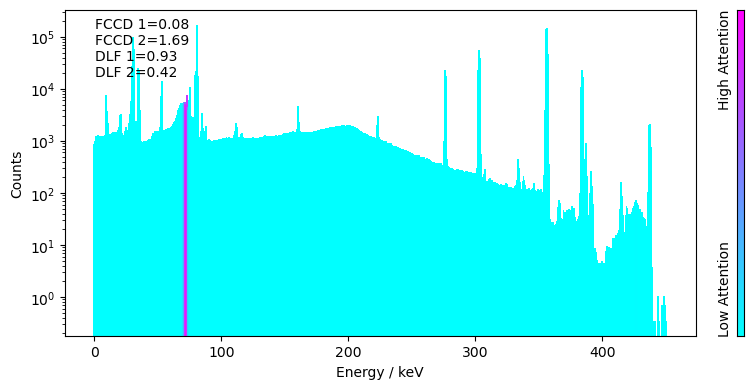

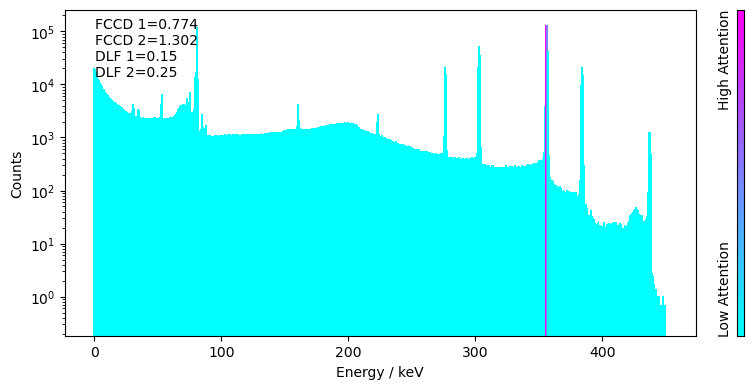

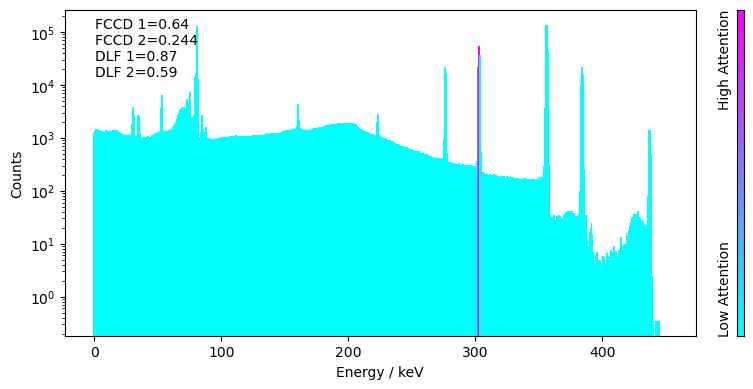

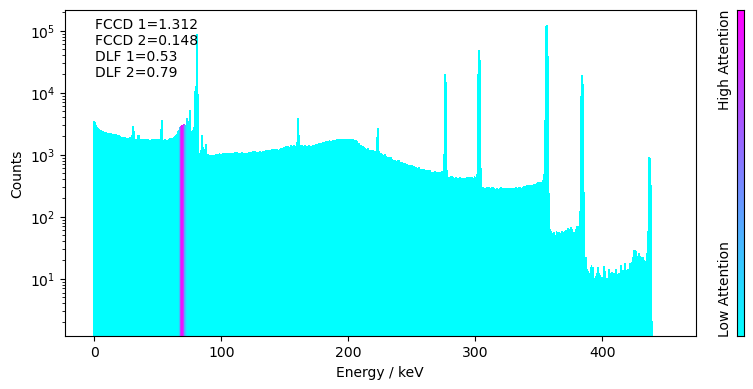

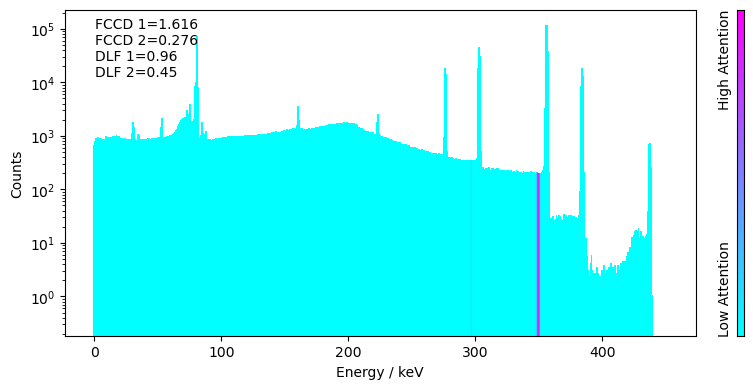

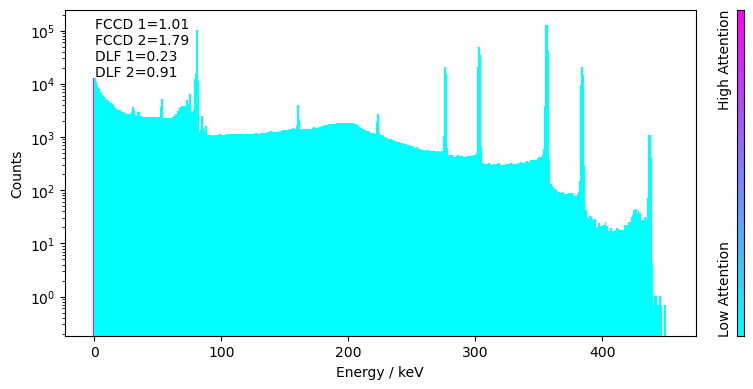

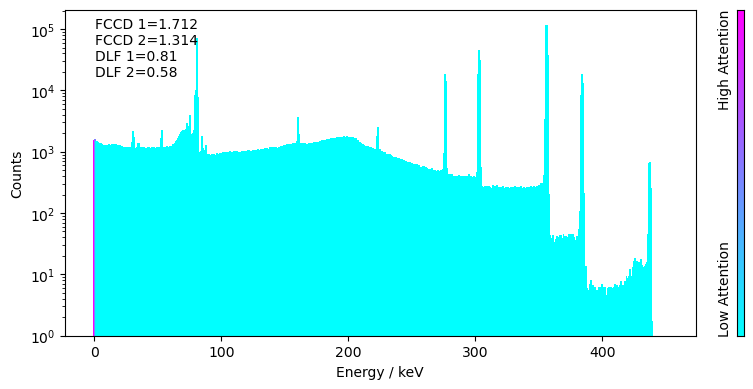

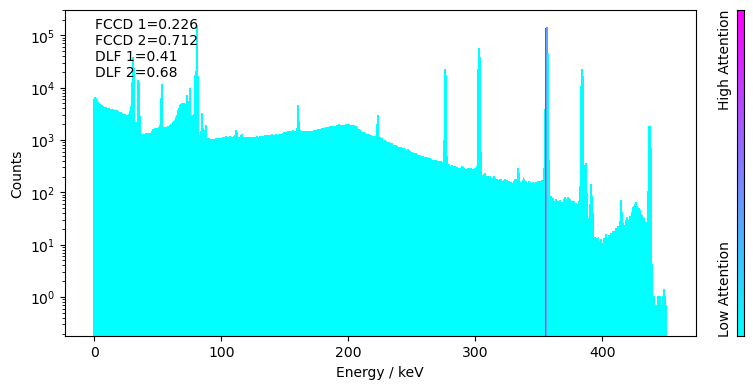

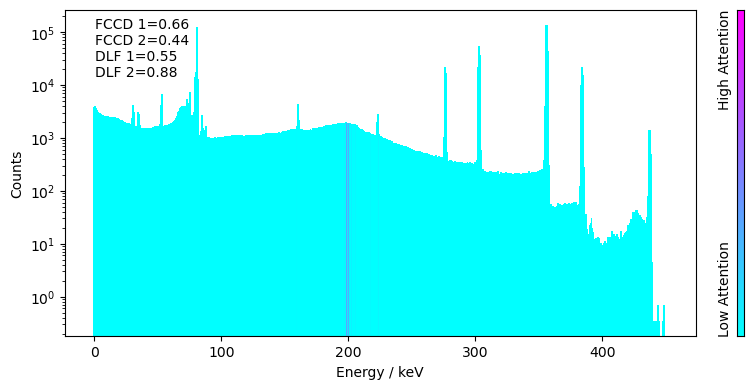

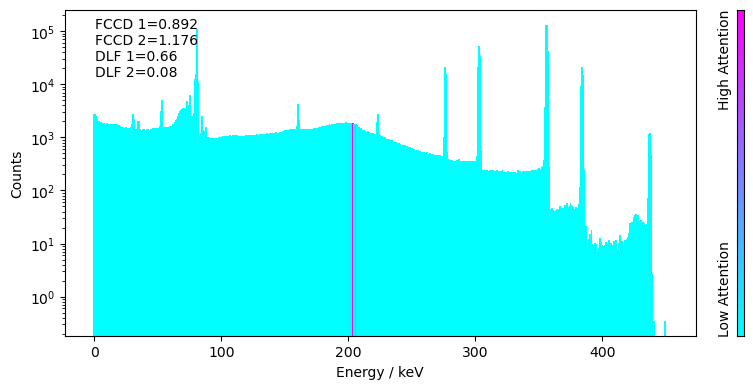

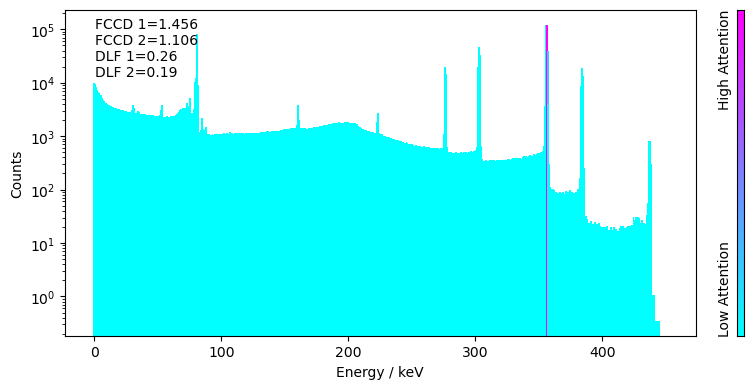

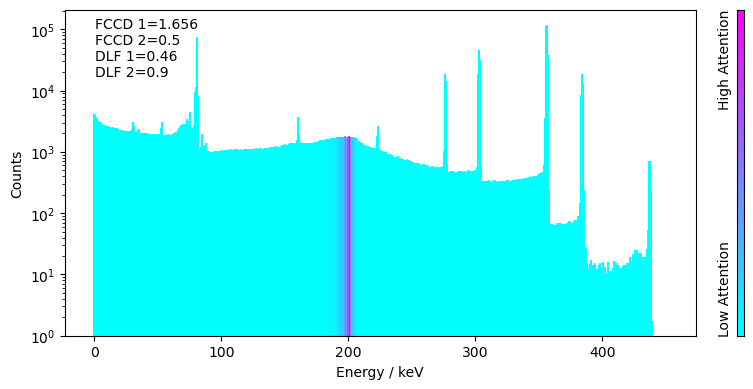

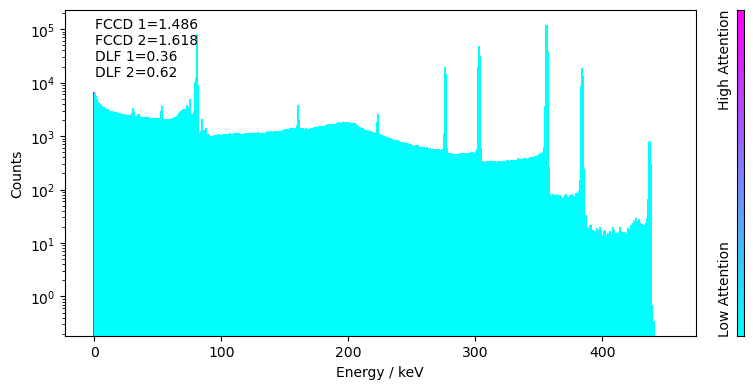

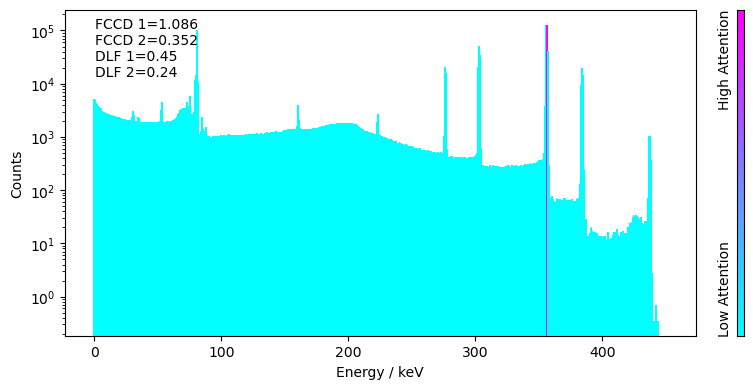

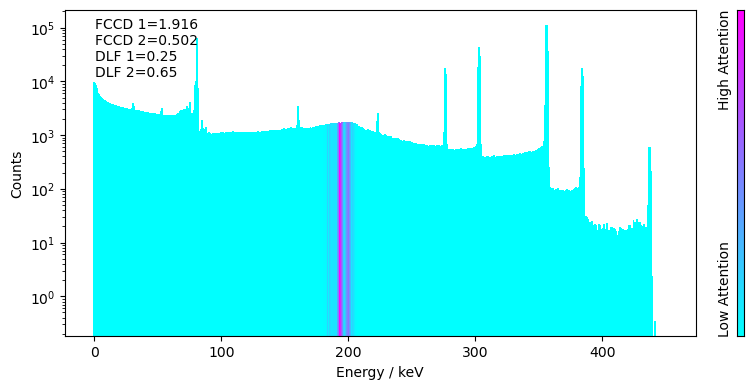

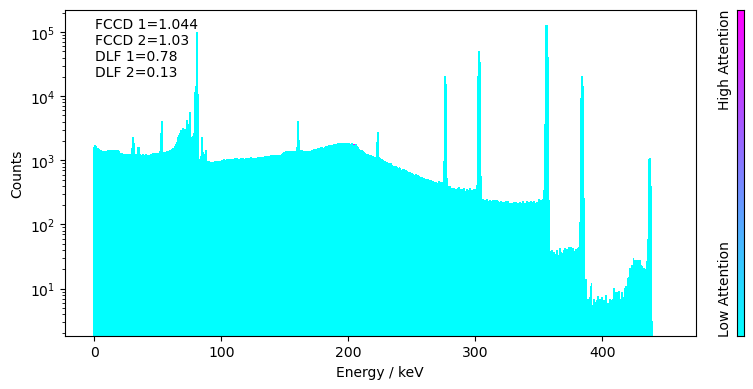

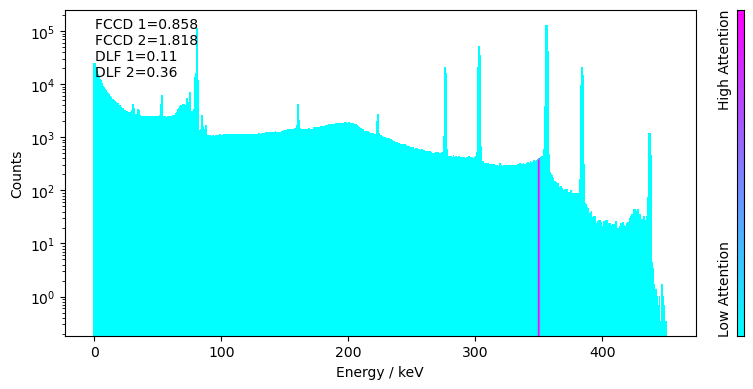

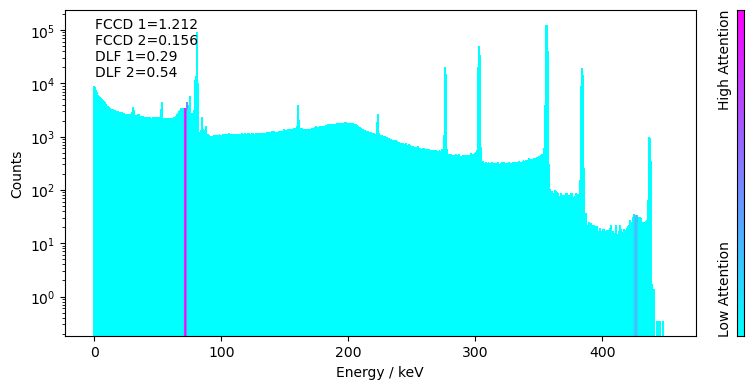

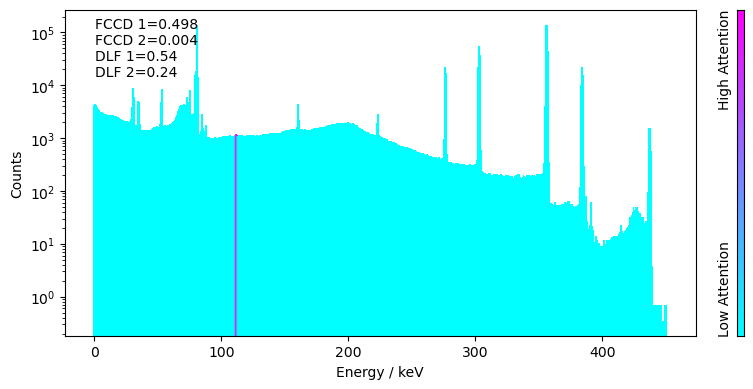

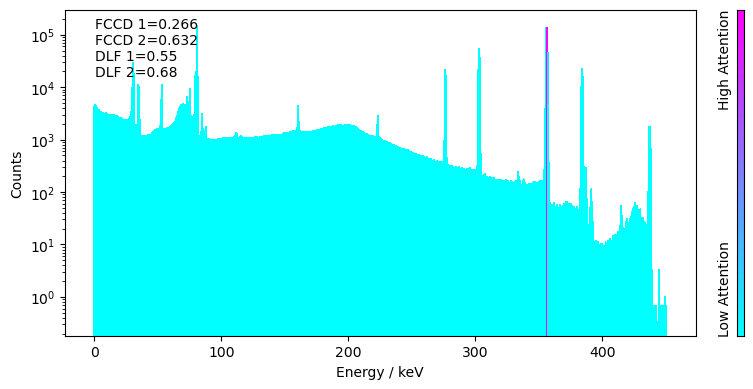

In [32]:
#Investigate Attention

#Make RNNinterpretor object and set get_attention to true
RNNinterpretor = RNN(dataset.get_histlen(),2)
RNNinterpretor.get_attention = True

#Load trained RNN dict to this
RNNinterpretor.load_state_dict(torch.load(model_path))
RNNinterpretor.eval()
RNNinterpretor.to(DEVICE)

import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages(CodePath+"/saved_models/"+RNN_ID+"/plots/test_attention_fulldataset.pdf")
   
for a in range (5):
    #Load a test events through interpretor
    test_spectrum_diff, test_FCCDLabel, test_DLFLabel, test_extras, test_spectrum = next(iter(test_loader))
    test_spectrum_diff = test_spectrum_diff.to(DEVICE).float()

    attention_score = RNNinterpretor(test_spectrum_diff)

    for i in range(BATCH_SIZE):
        attention = attention_score[i].cpu().detach().numpy()
        labels = {"FCCD1": test_extras["FCCD1"][i].item(), "FCCD2": test_extras["FCCD2"][i].item(), "DLF1": test_extras["DLF1"][i].item(), "DLF2": test_extras["DLF2"][i].item()}

        #plot attention score on spectrum
        fig = plot_attention(test_spectrum[i], attention, labels)
        pdf.savefig(fig)

pdf.close()

# TRAINING 4: restircted dataset - Max FCCD diff = 0.25 mm AND Max DLF diff = 0.25

In [33]:
NUM_EPOCHS = 20 #can try increasing
LEARNING_RATE = 0.005 #0.01 #try modifying learning rate #0.001 too low for 30 epochs, 0.01 may be too high
dataset_size = 10000

maxFCCDdiff = 0.25
maxDLFdiff = 0.25 
RNN_ID ="RNN_"+str(NUM_EPOCHS)+"epochs_LR"+str(LEARNING_RATE)+"_maxFCCDdiff"+str(maxFCCDdiff)+"mm_maxDLFdiff"+str(maxDLFdiff)+"_"+str(dataset_size)+"trials"

#initialise directories to save
if not os.path.exists(CodePath+"/saved_models/"+RNN_ID+"/plots/"):
    os.makedirs(CodePath+"/saved_models/"+RNN_ID+"/plots/")

## Training - DO NOT RERUN UNLESS NECESARRY

In [34]:
#Load dataset
BATCH_SIZE = 4 
restrict_dict = {"maxFCCDdiff": maxFCCDdiff, "maxDLFdiff": maxDLFdiff}
train_loader, test_loader, dataset = load_data(BATCH_SIZE, restrict_dataset=True, restrict_dict = restrict_dict, size=dataset_size)

#train RNN
FCCD_accuracy_values, DLF_accuracy_values, loss_values = train_RNN(dataset, train_loader, test_loader, NUM_EPOCHS, LEARNING_RATE, saveRNN=True, plot_training_results = True, RNN_ID = RNN_ID)


100%|████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.15it/s]


(1000, 900)
RNN_20epochs_LR0.005_maxFCCDdiff0.25mm_maxDLFdiff0.25_10000trials
#params 2106114
Warmup Size: 400
- - - - - - - - - - -

EPOCH:  1 / 20
Training network...
Epoch [1/20], Iter [49/1750] Loss: 0.5398

KeyboardInterrupt: 

In [ ]:
#Training Results
training_results(NUM_EPOCHS, loss_values, FCCD_accuracy_values, DLF_accuracy_values, save_plots = False, RNN_ID = RNN_ID)


## Testing - on maxFCCDdiff=0.25mm and maxDLFdiff=0.25

In [35]:
#load restricted dataset
BATCH_SIZE = 4 
restrict_dict = {"maxFCCDdiff": maxFCCDdiff, "maxDLFdiff": maxDLFdiff}
train_loader, test_loader, dataset = load_data(BATCH_SIZE, restrict_dataset=True, restrict_dict = restrict_dict, size=dataset_size)

100%|████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 174.52it/s]

(1000, 900)


In [36]:
# Load saved model
RNNclassifier_maxFCCDdiff0_25mm_maxDLFdiff0_25 = RNN(dataset.get_histlen(),2)
model_path = CodePath+"/saved_models/"+RNN_ID+"/"+RNN_ID+".pkl"
RNNclassifier_maxFCCDdiff0_25mm_maxDLFdiff0_25.load_state_dict(torch.load(model_path))
RNNclassifier_maxFCCDdiff0_25mm_maxDLFdiff0_25.eval()

RNN(
  (RNNLayer): GRU(1, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fcnet): FCNet(
    (fcnet): Sequential(
      (0): Linear(in_features=1024, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=256, out_features=2, bias=True)
    )
  )
  (attention_weight): Linear(in_features=512, out_features=512, bias=False)
)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 750/750 [01:09<00:00, 10.75it/s]


FCCD accuracies: 
total:  3000
TP:  1447
FP:  26
TN:  1491
FN:  36
accuracy:  0.9793333333333333
precision:  0.9823489477257298
recall:  0.9757248819959542

DLF accuracies: 
total:  3000
TP:  1439
FP:  62
TN:  1423
FN:  76
accuracy:  0.954
precision:  0.9586942038640907
recall:  0.9498349834983498
Total # misclassified trials FCCD:  62  / 3000
Total # misclassified trials DLF:  138  / 3000


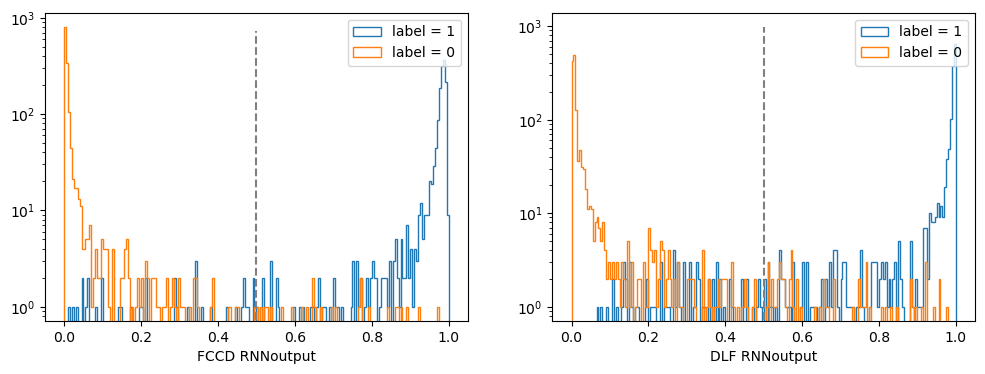

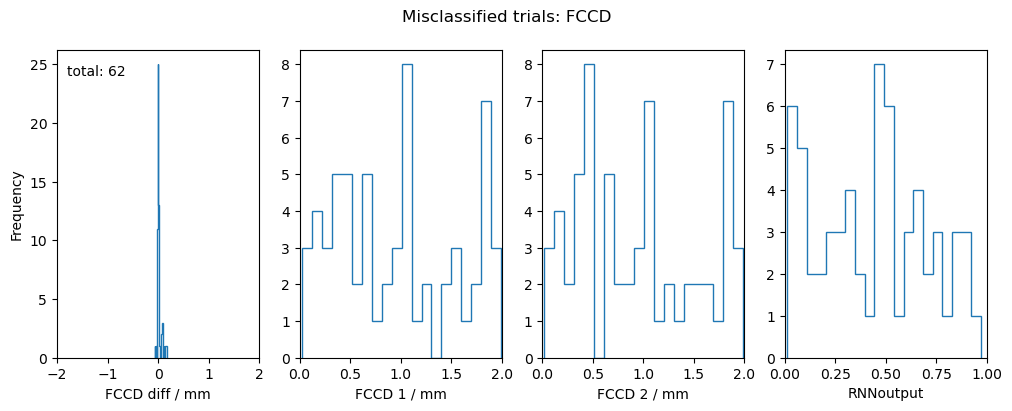

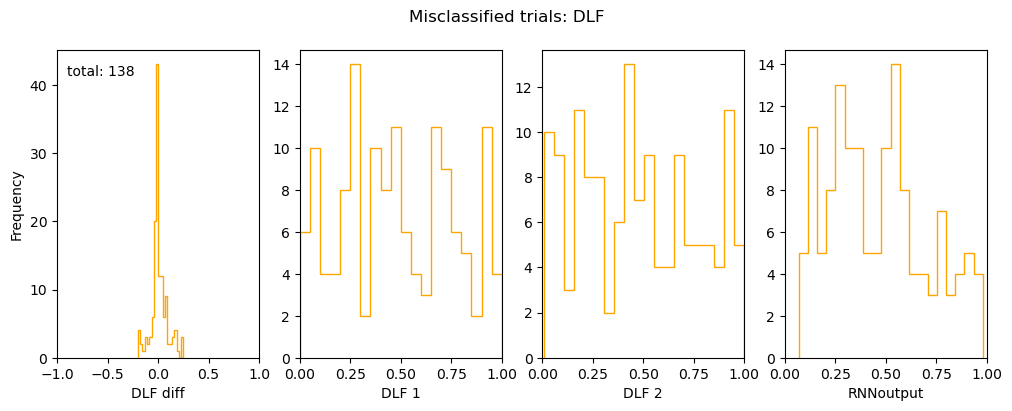

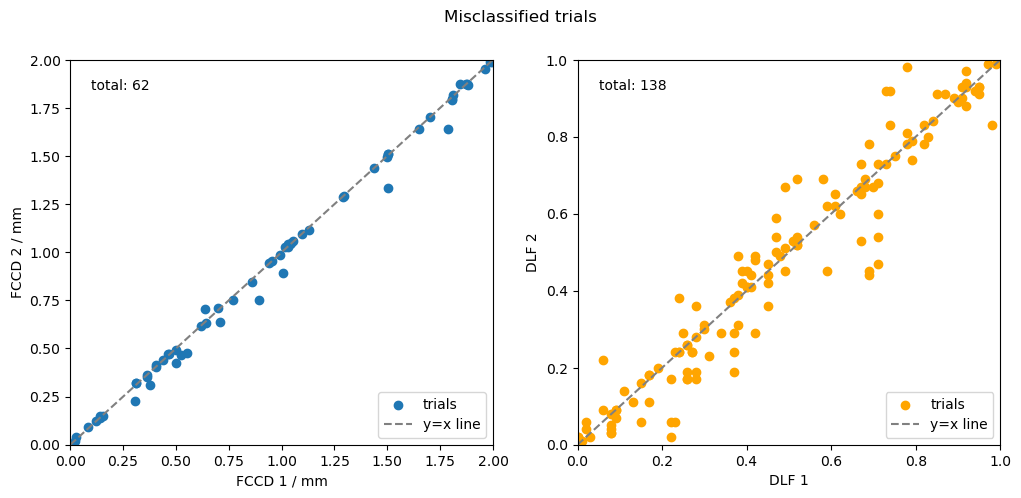

In [37]:
#testing
accuracies_maxFCCDdiff0_25mm_maxDLFdiff0_25 = test_RNN(RNNclassifier_maxFCCDdiff0_25mm_maxDLFdiff0_25, test_loader, RNN_ID=RNN_ID, performance_plots = True, misclassified_trials_plots = True, save_results = True)


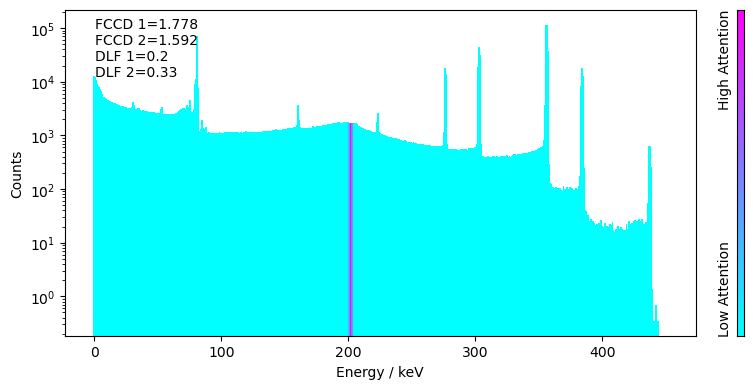

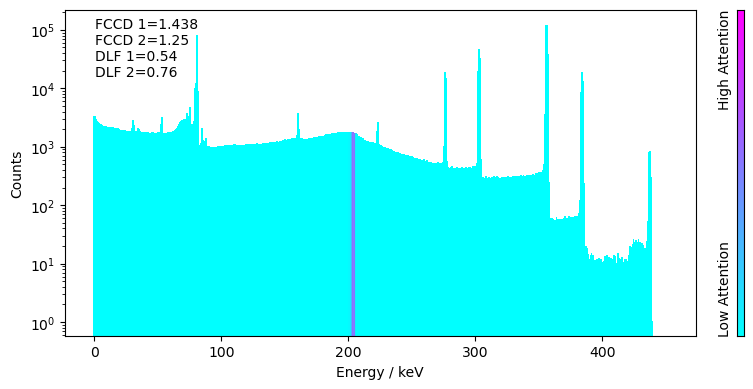

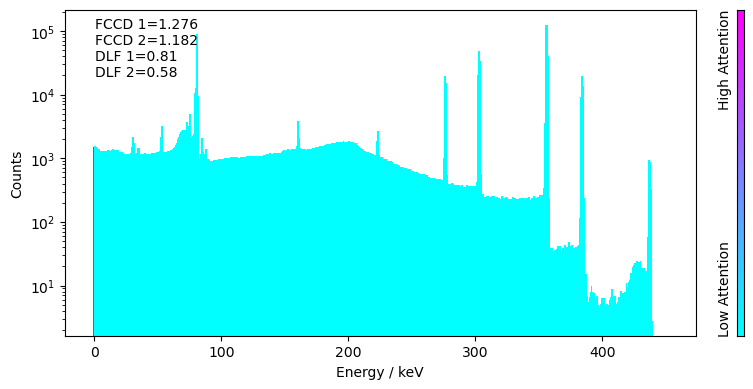

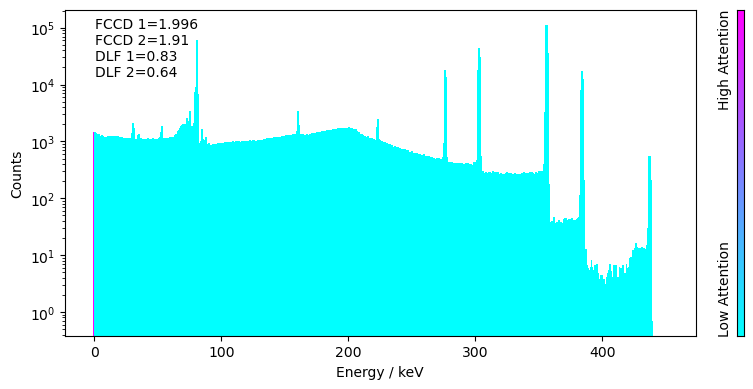

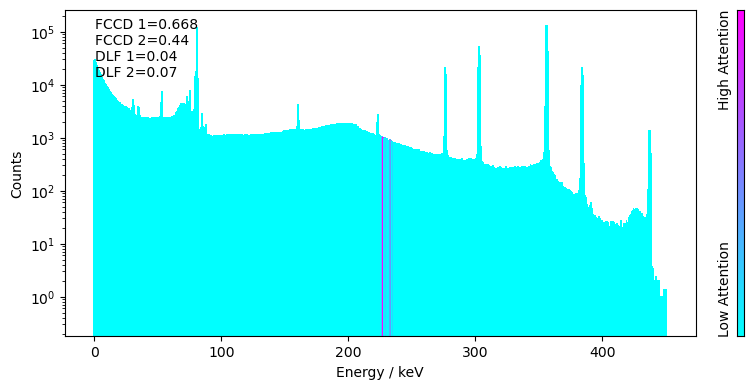

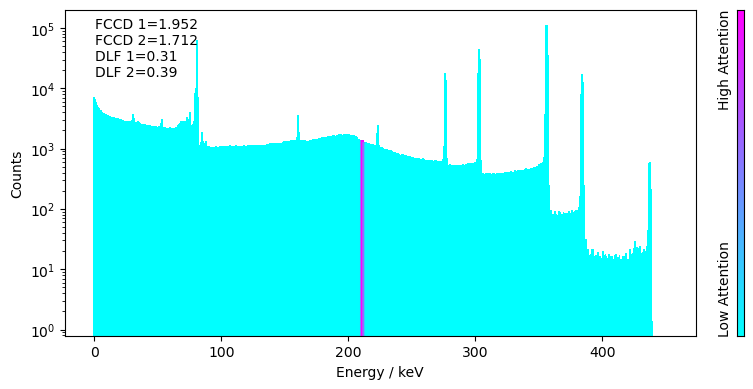

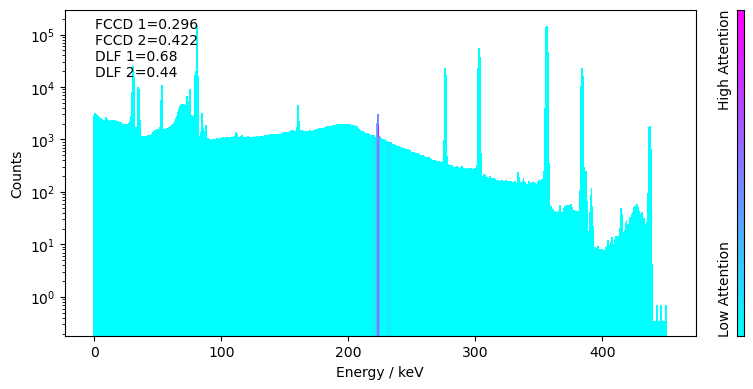

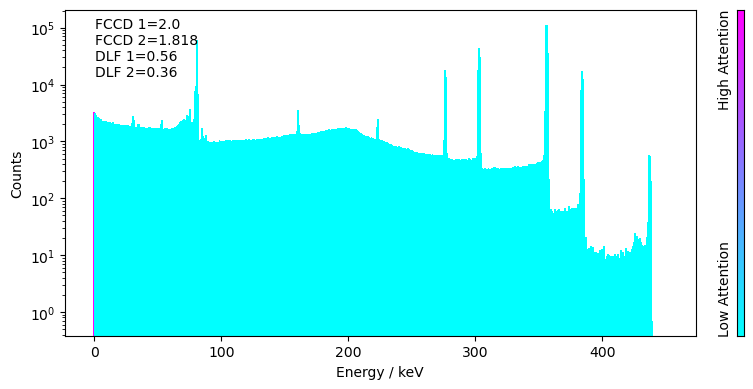

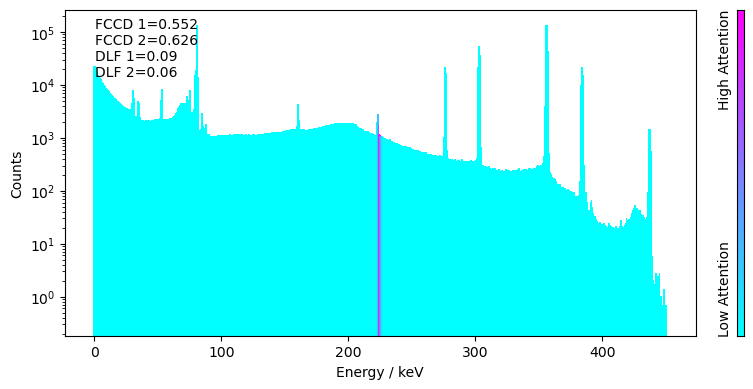

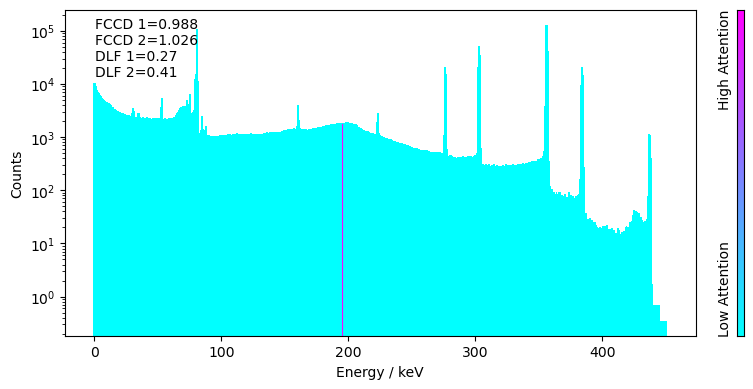

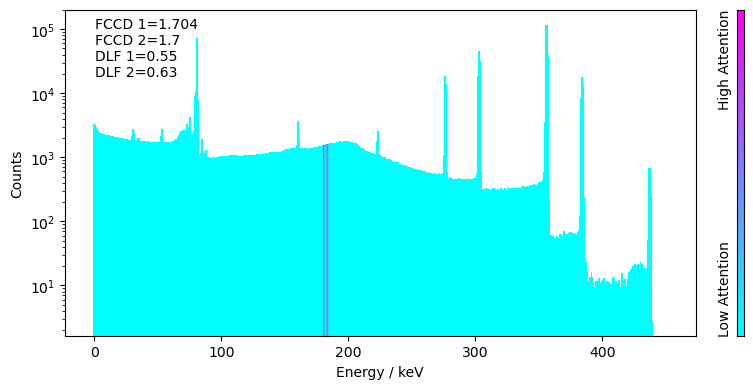

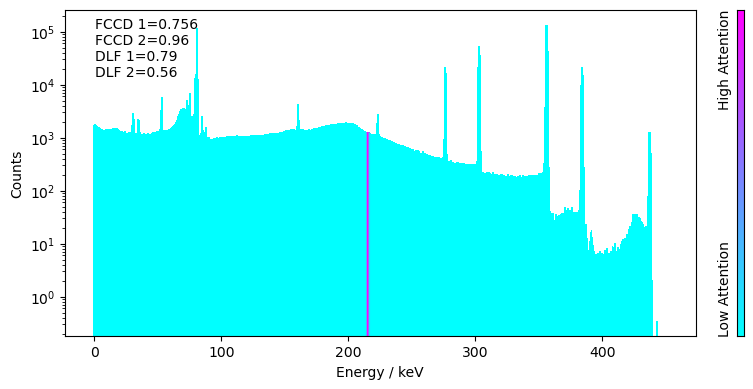

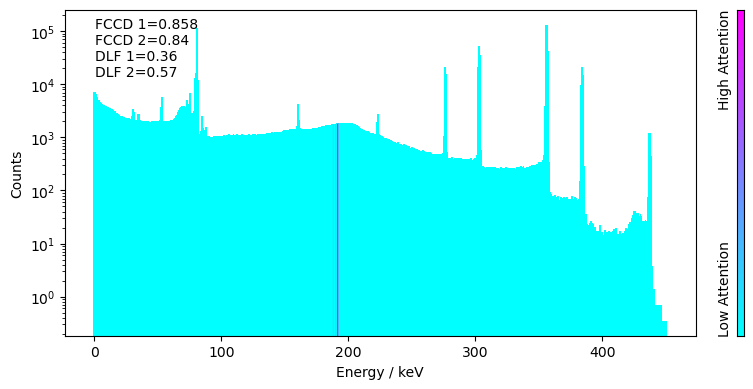

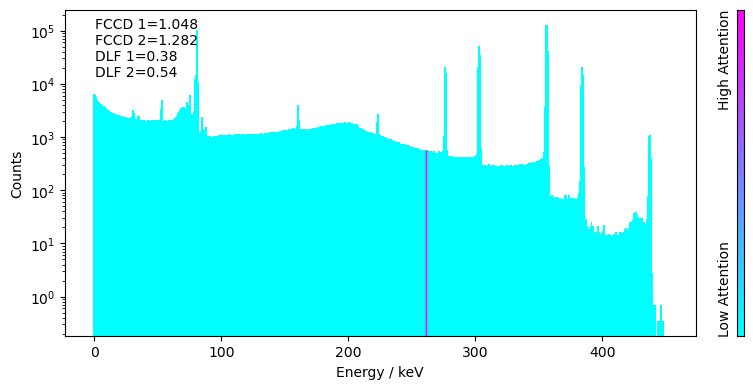

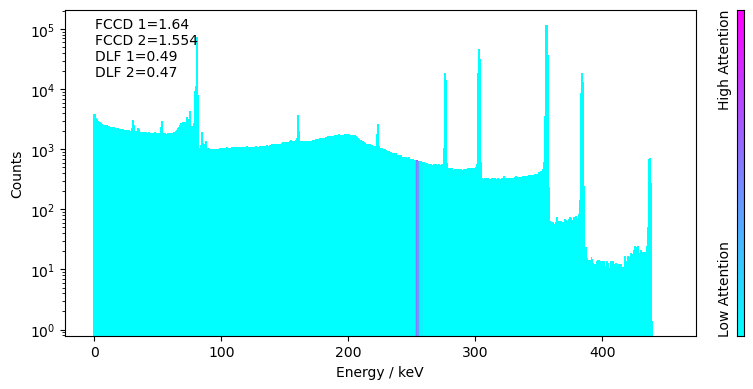

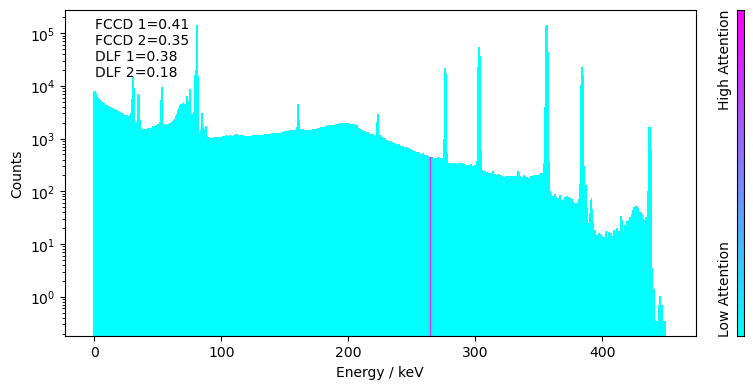

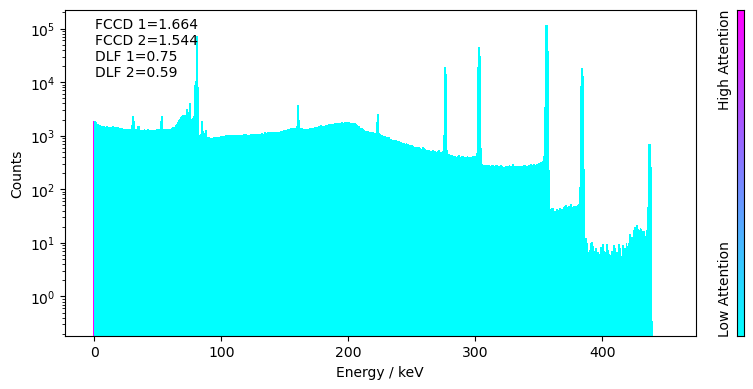

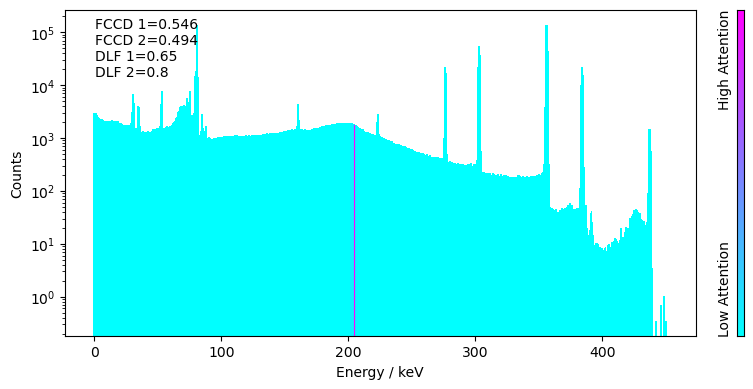

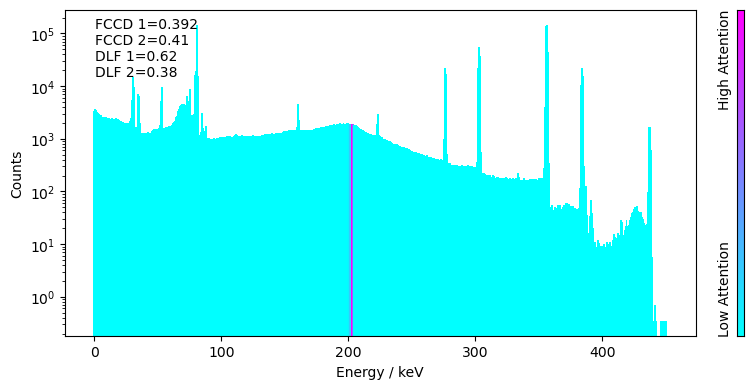

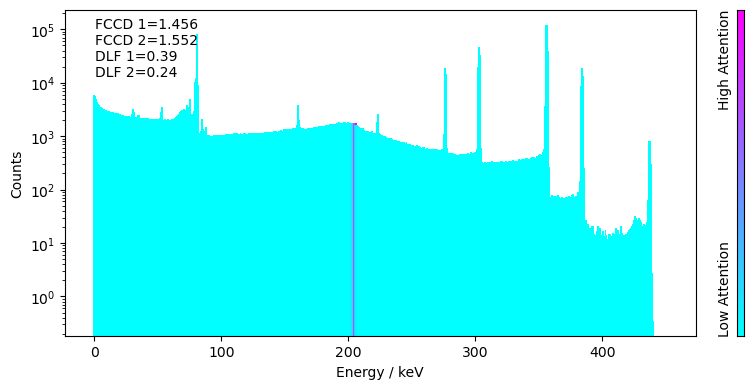

In [38]:
#Investigate Attention

#Make RNNinterpretor object and set get_attention to true
RNNinterpretor = RNN(dataset.get_histlen(),2)
RNNinterpretor.get_attention = True

#Load trained RNN dict to this
RNNinterpretor.load_state_dict(torch.load(model_path))
RNNinterpretor.eval()
RNNinterpretor.to(DEVICE)

import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages(CodePath+"/saved_models/"+RNN_ID+"/plots/test_attention.pdf")
   
for a in range (5):
    #Load a test events through interpretor
    test_spectrum_diff, test_FCCDLabel, test_DLFLabel, test_extras, test_spectrum = next(iter(test_loader))
    test_spectrum_diff = test_spectrum_diff.to(DEVICE).float()

    attention_score = RNNinterpretor(test_spectrum_diff)

    for i in range(BATCH_SIZE):
        attention = attention_score[i].cpu().detach().numpy()
        labels = {"FCCD1": test_extras["FCCD1"][i].item(), "FCCD2": test_extras["FCCD2"][i].item(), "DLF1": test_extras["DLF1"][i].item(), "DLF2": test_extras["DLF2"][i].item()}

        #plot attention score on spectrum
        fig = plot_attention(test_spectrum[i], attention, labels)
        pdf.savefig(fig)

pdf.close()

## Testing - on full dataset

In [40]:
#load full dataset
BATCH_SIZE = 4 
train_loader, test_loader, dataset = load_data(BATCH_SIZE, size=dataset_size)

100%|████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 186.27it/s]

(1000, 900)


  8%|███████▏                                                                                  | 6/75 [00:00<00:06, 10.66it/s]

DLF and FCCD misclassified for same trial:
j:  4 , i:  3
FCCD1:  1.556 , FCCD2:  0.438 , FCCD_diff:  1.118 , RNNoutput:  0.35529226
DLF1:  0.39 , DLF2:  0.41 , DLF_diff:  -0.019999999999999962 , RNNoutput:  0.78853446


 29%|██████████████████████████                                                               | 22/75 [00:02<00:04, 10.98it/s]

DLF and FCCD misclassified for same trial:
j:  19 , i:  1
FCCD1:  1.494 , FCCD2:  0.156 , FCCD_diff:  1.338 , RNNoutput:  0.4678221
DLF1:  0.41 , DLF2:  0.54 , DLF_diff:  -0.13000000000000006 , RNNoutput:  0.8301491


100%|█████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 10.99it/s]


FCCD accuracies: 
total:  300
TP:  113
FP:  8
TN:  146
FN:  33
accuracy:  0.8633333333333333
precision:  0.9338842975206612
recall:  0.773972602739726

DLF accuracies: 
total:  300
TP:  135
FP:  13
TN:  145
FN:  7
accuracy:  0.9333333333333333
precision:  0.9121621621621622
recall:  0.9507042253521126
Total # misclassified trials FCCD:  41  / 300
Total # misclassified trials DLF:  20  / 300


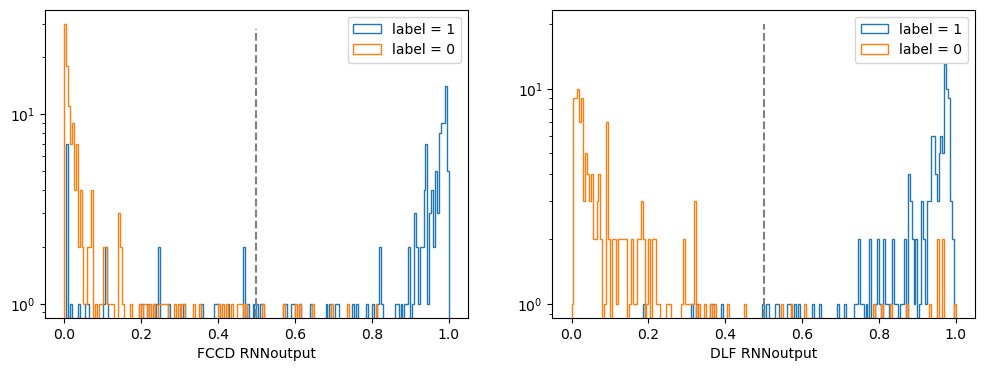

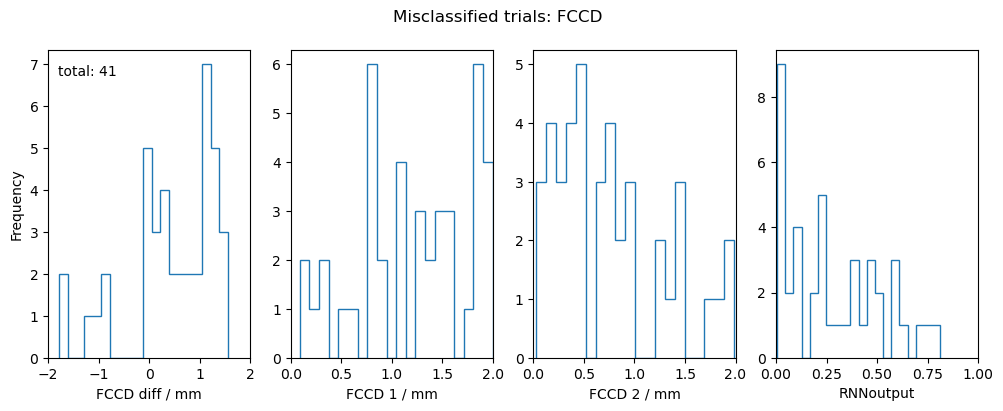

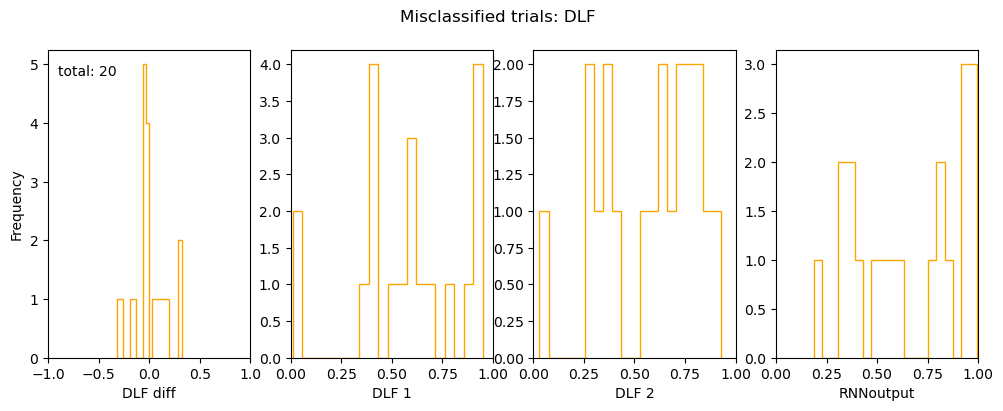

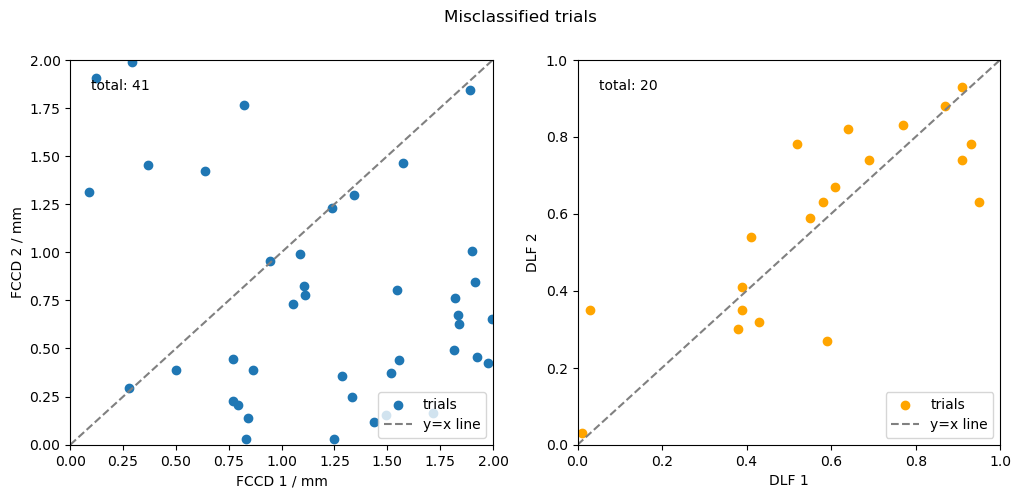

In [41]:
#testing
accuracies_maxFCCDdiff0_25mm_maxDLFdiff0_25 = test_RNN(RNNclassifier_maxFCCDdiff0_25mm_maxDLFdiff0_25, test_loader, RNN_ID=RNN_ID, performance_plots = True, misclassified_trials_plots = True, save_results = True, train_restricted_test_fulldataset = True)


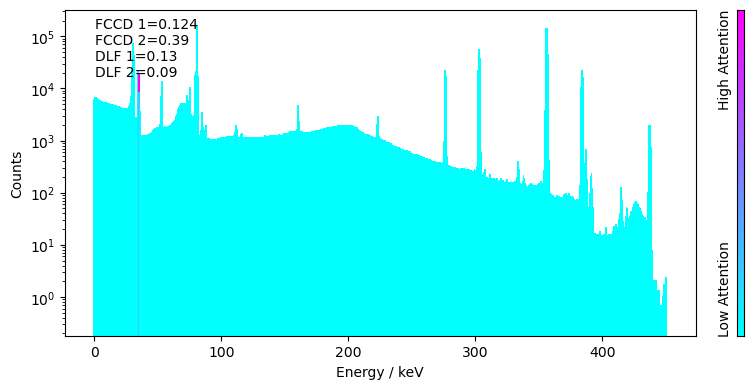

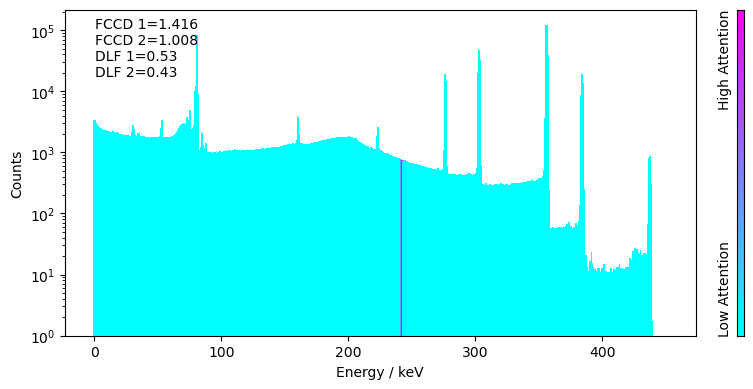

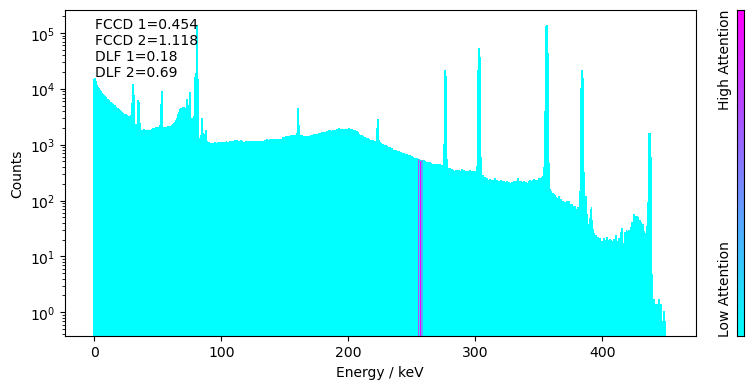

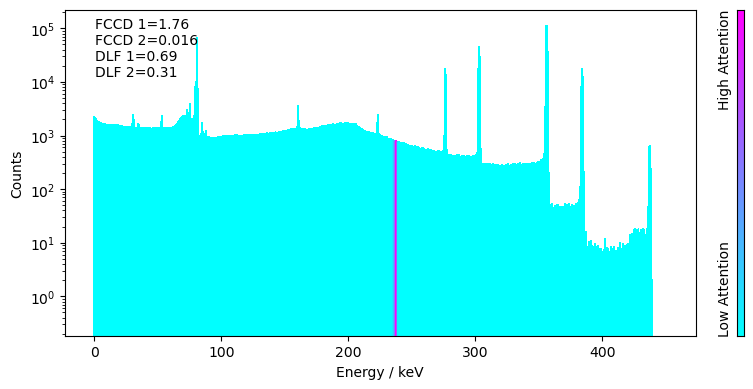

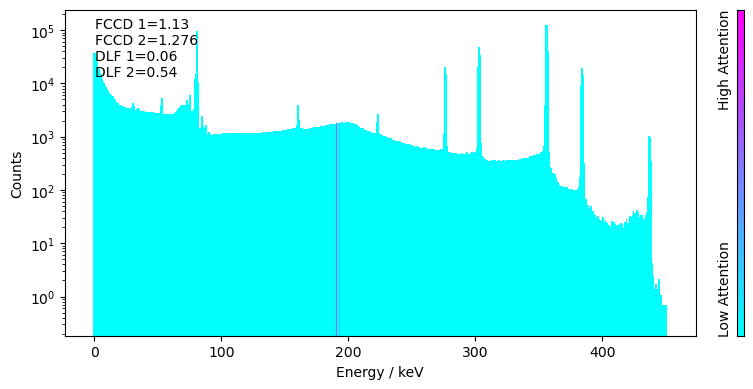

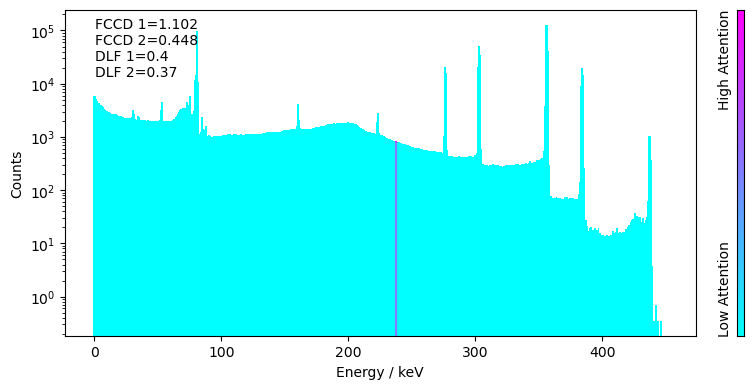

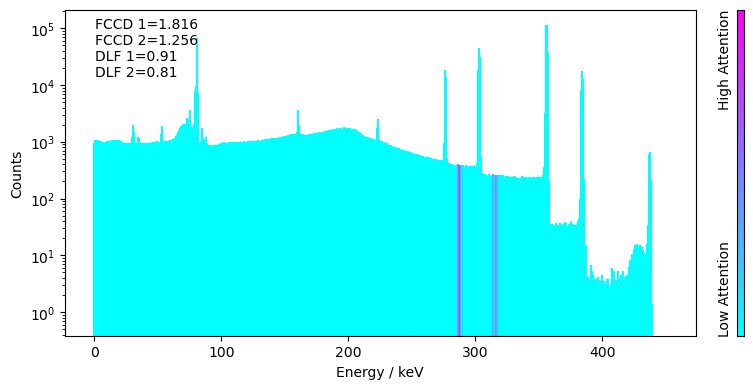

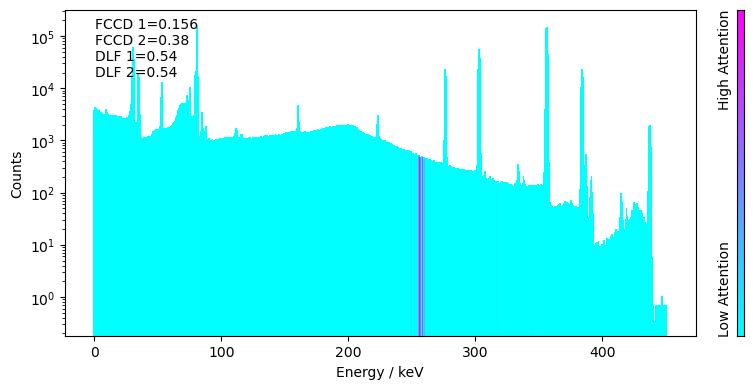

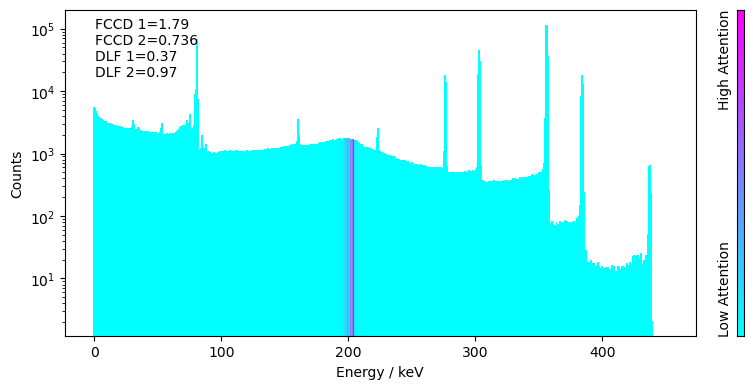

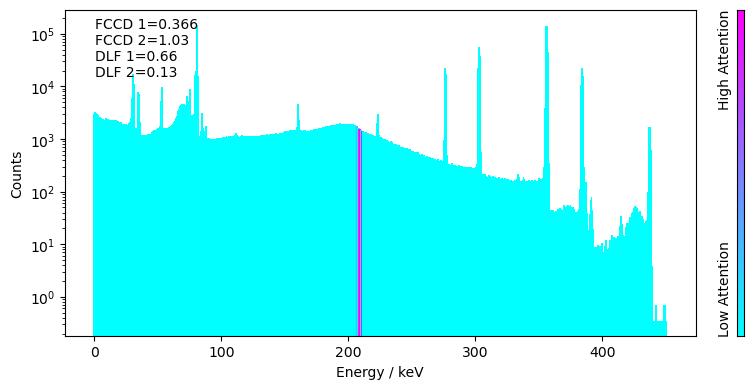

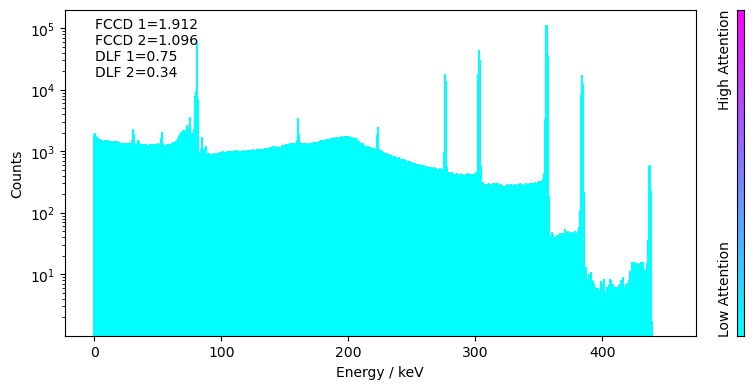

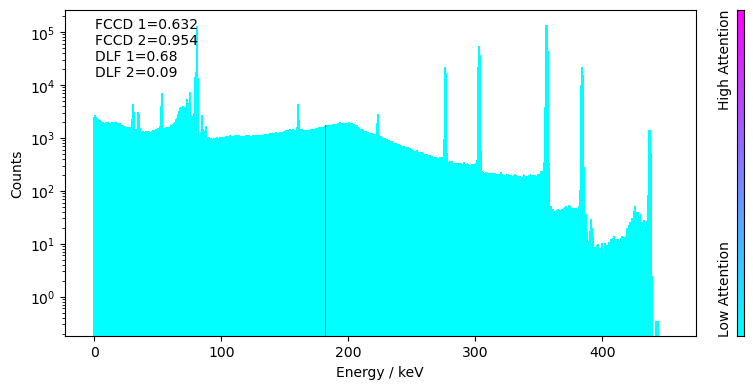

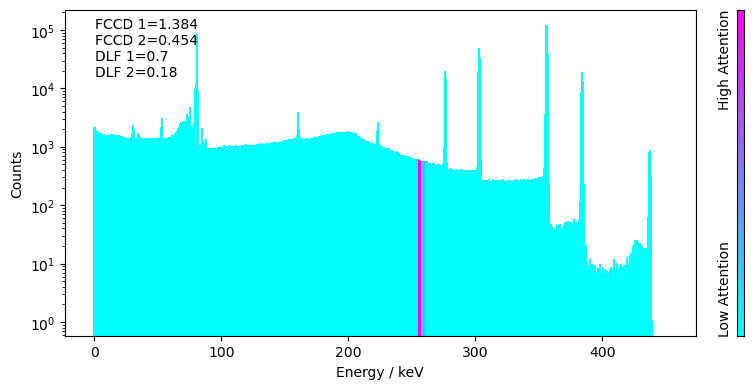

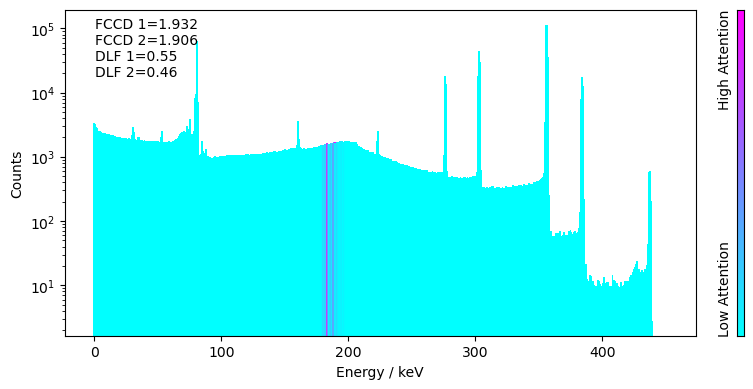

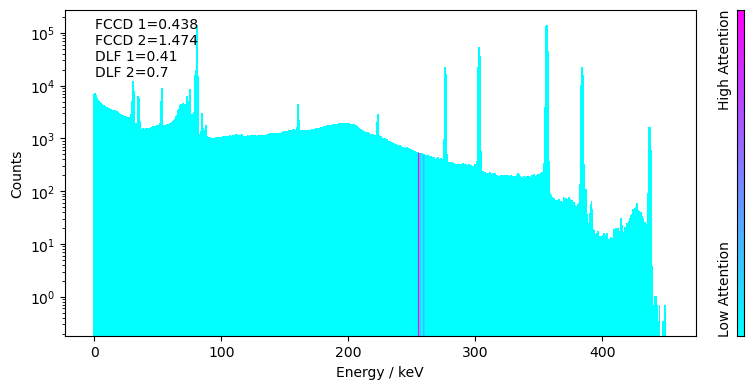

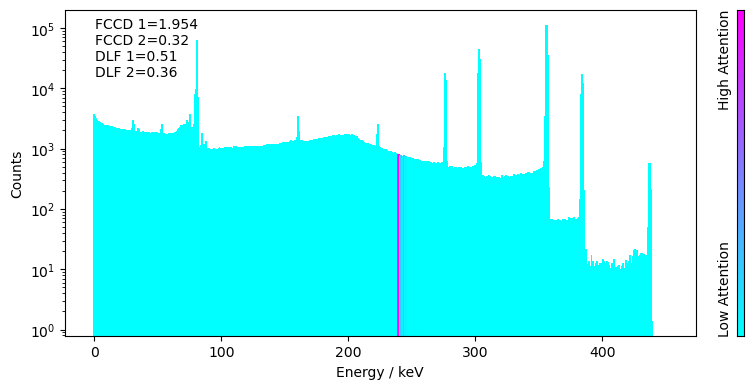

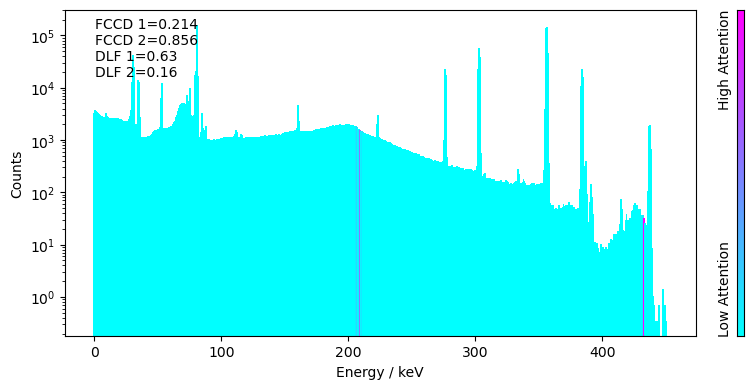

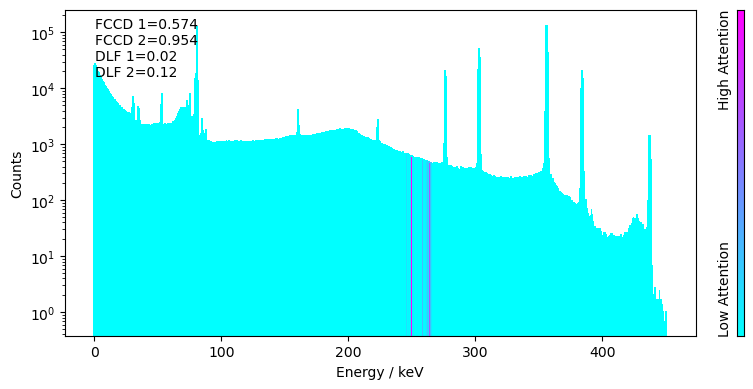

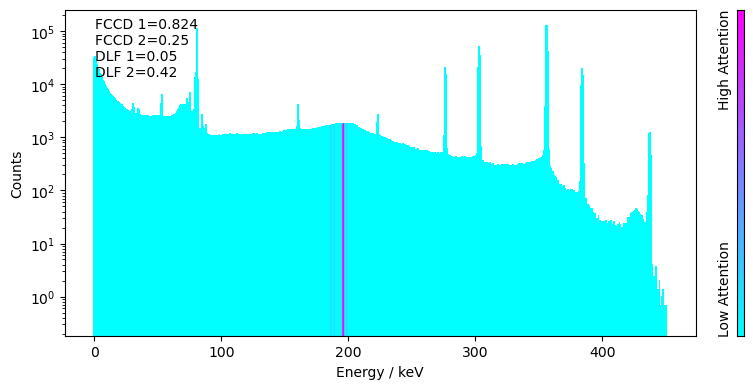

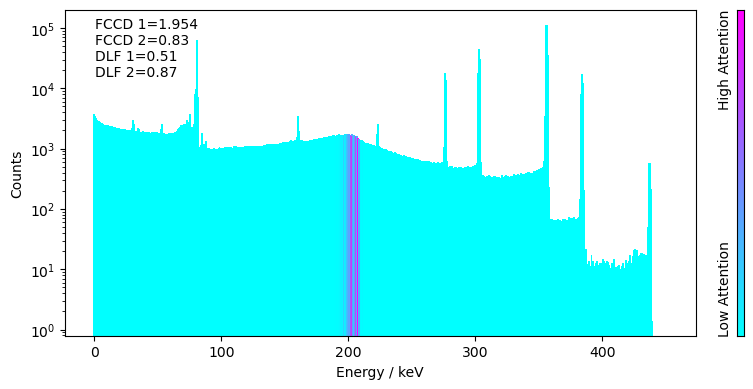

In [42]:
#Investigate Attention

#Make RNNinterpretor object and set get_attention to true
RNNinterpretor = RNN(dataset.get_histlen(),2)
RNNinterpretor.get_attention = True

#Load trained RNN dict to this
RNNinterpretor.load_state_dict(torch.load(model_path))
RNNinterpretor.eval()
RNNinterpretor.to(DEVICE)

import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages(CodePath+"/saved_models/"+RNN_ID+"/plots/test_attention_fulldataset.pdf")
   
for a in range (5):
    #Load a test events through interpretor
    test_spectrum_diff, test_FCCDLabel, test_DLFLabel, test_extras, test_spectrum = next(iter(test_loader))
    test_spectrum_diff = test_spectrum_diff.to(DEVICE).float()

    attention_score = RNNinterpretor(test_spectrum_diff)

    for i in range(BATCH_SIZE):
        attention = attention_score[i].cpu().detach().numpy()
        labels = {"FCCD1": test_extras["FCCD1"][i].item(), "FCCD2": test_extras["FCCD2"][i].item(), "DLF1": test_extras["DLF1"][i].item(), "DLF2": test_extras["DLF2"][i].item()}

        #plot attention score on spectrum
        fig = plot_attention(test_spectrum[i], attention, labels)
        pdf.savefig(fig)

pdf.close()

# TRAINING 5: restircted dataset - Max FCCD diff = 0.1 mm

In [39]:
NUM_EPOCHS = 20 #can try increasing
LEARNING_RATE = 0.005 #0.01 #try modifying learning rate #0.001 too low for 30 epochs, 0.01 may be too high
dataset_size = 10000

maxFCCDdiff = 0.1
maxDLFdiff = 1.0 #i.e. no restriction
RNN_ID ="RNN_"+str(NUM_EPOCHS)+"epochs_LR"+str(LEARNING_RATE)+"_maxFCCDdiff"+str(maxFCCDdiff)+"mm_"+str(dataset_size)+"trials"

#initialise directories to save
if not os.path.exists(CodePath+"/saved_models/"+RNN_ID+"/plots/"):
    os.makedirs(CodePath+"/saved_models/"+RNN_ID+"/plots/")


## Training - DO NOT RERUN UNLESS NECESARRY

In [ ]:
#Load dataset
BATCH_SIZE = 4 
restrict_dict = {"maxFCCDdiff": maxFCCDdiff, "maxDLFdiff": maxDLFdiff}
train_loader, test_loader, dataset = load_data(BATCH_SIZE, restrict_dataset=True, restrict_dict = restrict_dict, size=dataset_size)

#train RNN
FCCD_accuracy_values, DLF_accuracy_values, loss_values = train_RNN(dataset, train_loader, test_loader, NUM_EPOCHS, LEARNING_RATE, saveRNN=True, plot_training_results = True, RNN_ID = RNN_ID)

In [ ]:
#Training Results
training_results(NUM_EPOCHS, loss_values, FCCD_accuracy_values, DLF_accuracy_values, save_plots = False, RNN_ID = RNN_ID)


## Testing - on maxFCCDdiff=0.1mm

In [40]:
#load restricted dataset
BATCH_SIZE = 4 
restrict_dict = {"maxFCCDdiff": maxFCCDdiff, "maxDLFdiff": maxDLFdiff}
train_loader, test_loader, dataset = load_data(BATCH_SIZE, restrict_dataset=True, restrict_dict = restrict_dict, size=dataset_size)

100%|████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 174.64it/s]

(1000, 900)


In [41]:
# Load saved model
RNNclassifier_maxFCCDdiff0_1mm = RNN(dataset.get_histlen(),2)
model_path = CodePath+"/saved_models/"+RNN_ID+"/"+RNN_ID+".pkl"
RNNclassifier_maxFCCDdiff0_1mm.load_state_dict(torch.load(model_path))
RNNclassifier_maxFCCDdiff0_1mm.eval()

RNN(
  (RNNLayer): GRU(1, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fcnet): FCNet(
    (fcnet): Sequential(
      (0): Linear(in_features=1024, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=256, out_features=2, bias=True)
    )
  )
  (attention_weight): Linear(in_features=512, out_features=512, bias=False)
)

 46%|█████████████████████████████████████████▍                                                 | 342/750 [00:30<00:36, 11.29it/s]

DLF and FCCD misclassified for same trial:
j:  339 , i:  3
FCCD1:  0.536 , FCCD2:  0.618 , FCCD_diff:  -0.08199999999999996 , RNNoutput:  0.9282805
DLF1:  0.4 , DLF2:  0.4 , DLF_diff:  0.0 , RNNoutput:  0.005076315


 73%|██████████████████████████████████████████████████████████████████                         | 544/750 [00:49<00:18, 11.14it/s]

DLF and FCCD misclassified for same trial:
j:  542 , i:  1
FCCD1:  0.54 , FCCD2:  0.476 , FCCD_diff:  0.06400000000000006 , RNNoutput:  0.40921077
DLF1:  0.01 , DLF2:  0.01 , DLF_diff:  0.0 , RNNoutput:  0.04716025


100%|███████████████████████████████████████████████████████████████████████████████████████████| 750/750 [01:09<00:00, 10.85it/s]


FCCD accuracies: 
total:  3000
TP:  1473
FP:  92
TN:  1368
FN:  67
accuracy:  0.947
precision:  0.9412140575079873
recall:  0.9564935064935065

DLF accuracies: 
total:  3000
TP:  1492
FP:  16
TN:  1455
FN:  37
accuracy:  0.9823333333333333
precision:  0.9893899204244032
recall:  0.9758011772400261
Total # misclassified trials FCCD:  159  / 3000
Total # misclassified trials DLF:  53  / 3000


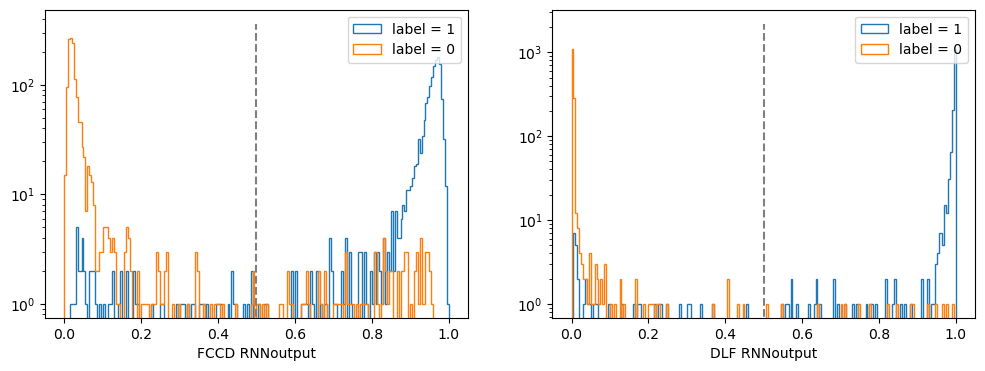

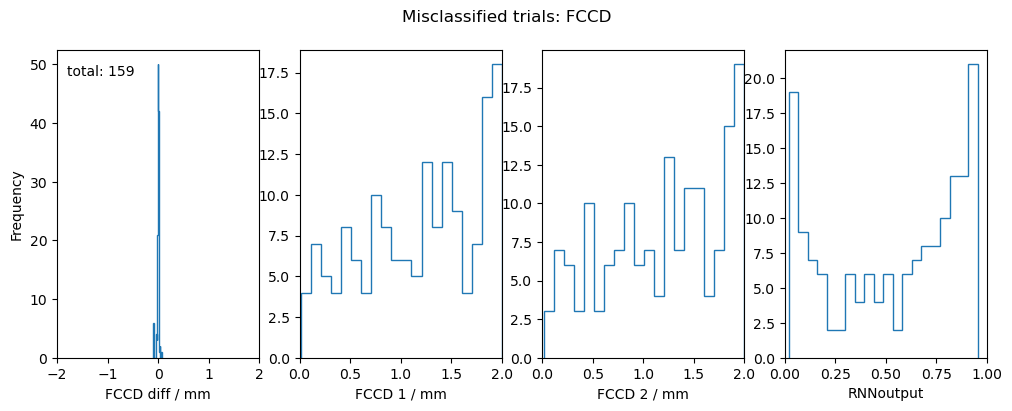

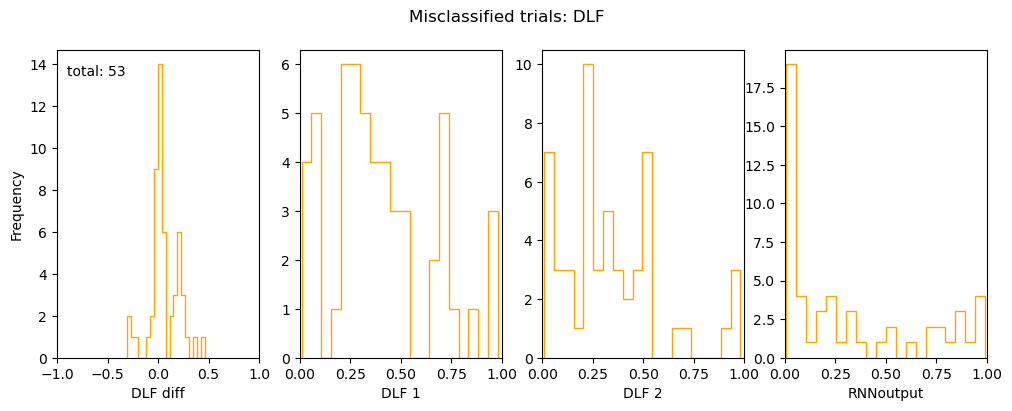

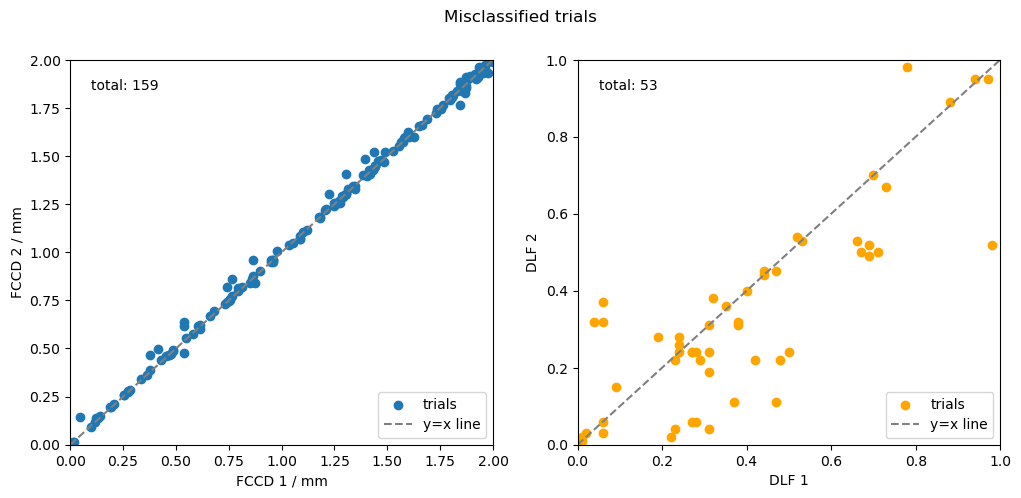

In [42]:
#testing
accuracies_maxFCCDdiff0_1mm = test_RNN(RNNclassifier_maxFCCDdiff0_1mm, test_loader, RNN_ID=RNN_ID, performance_plots = True, misclassified_trials_plots = True, save_results = True)


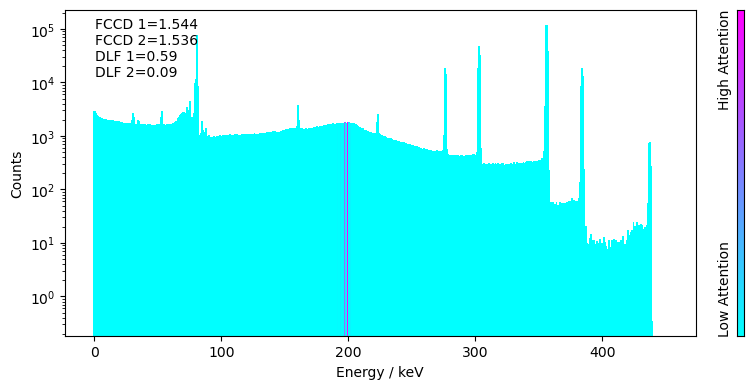

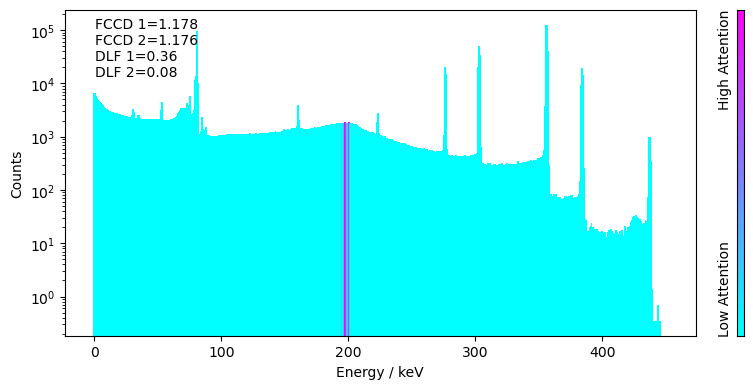

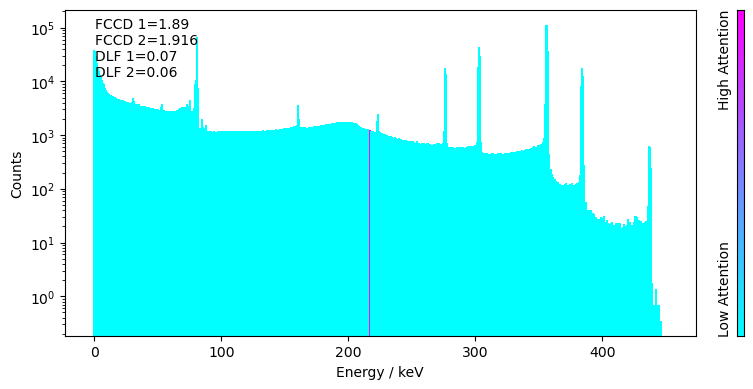

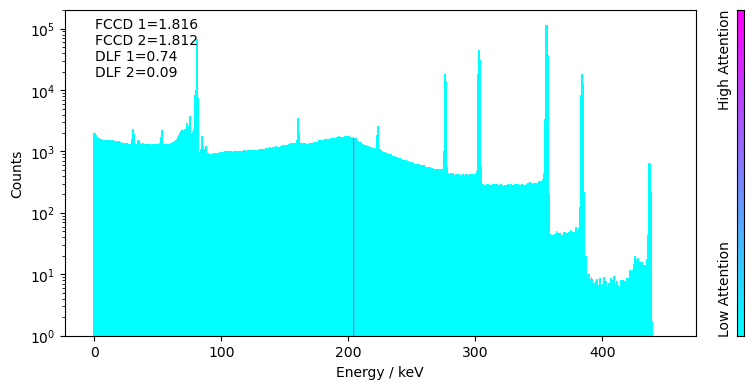

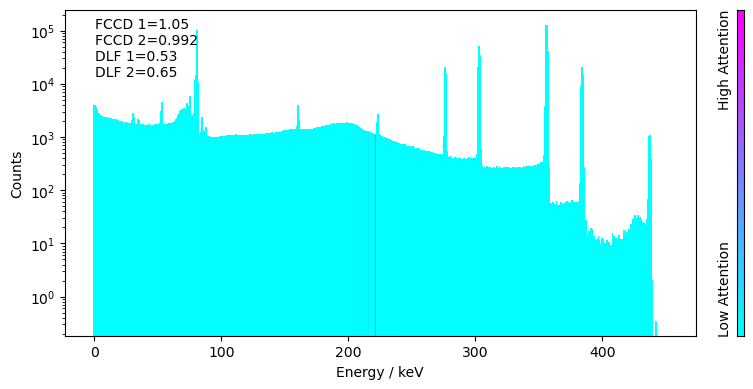

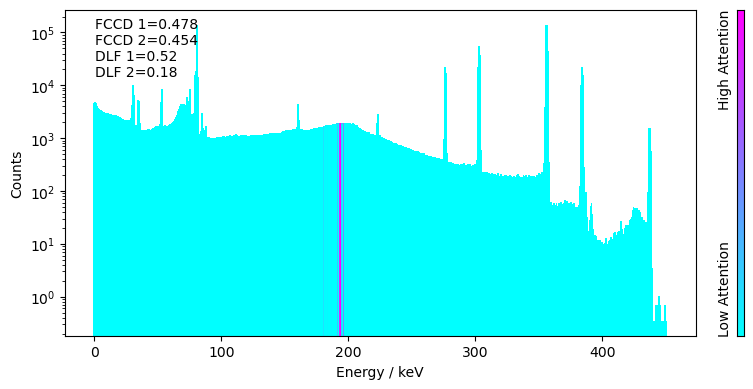

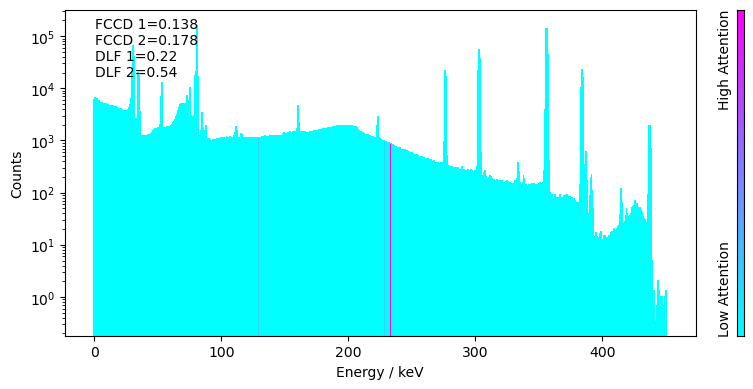

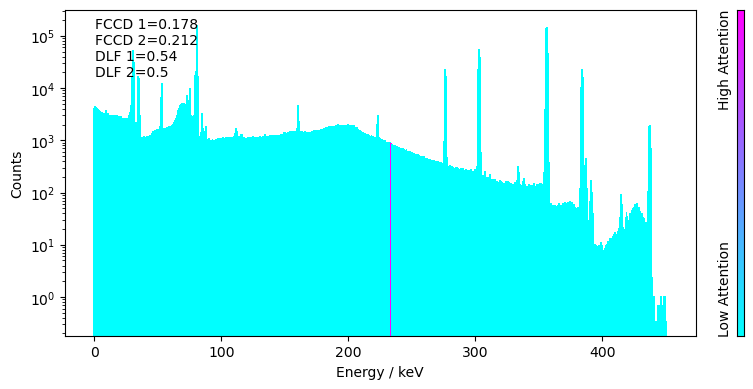

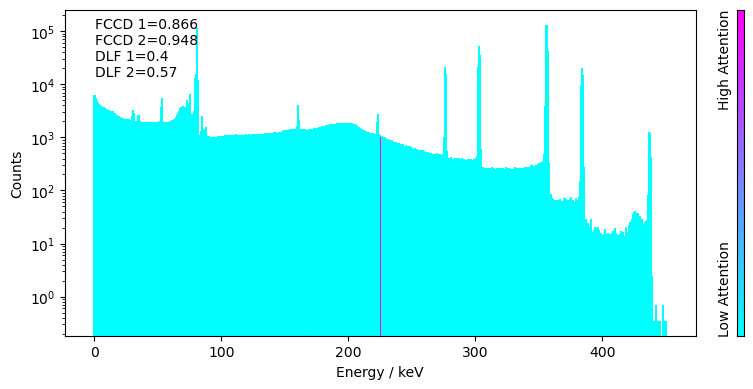

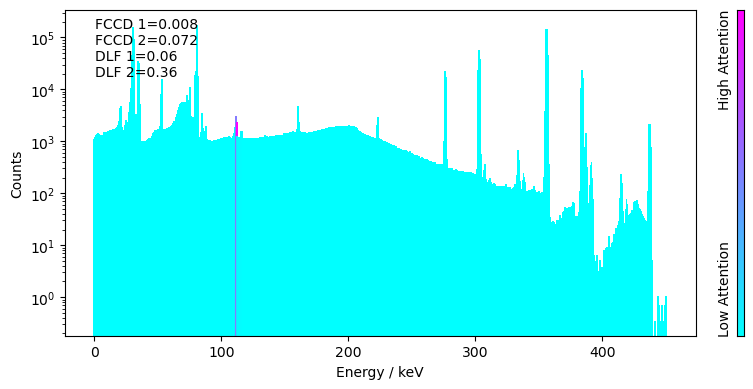

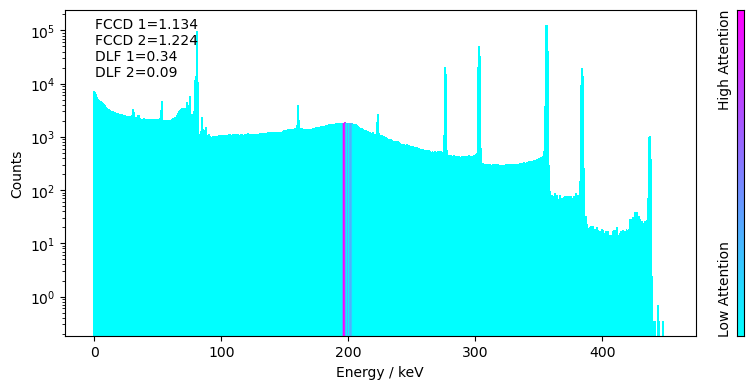

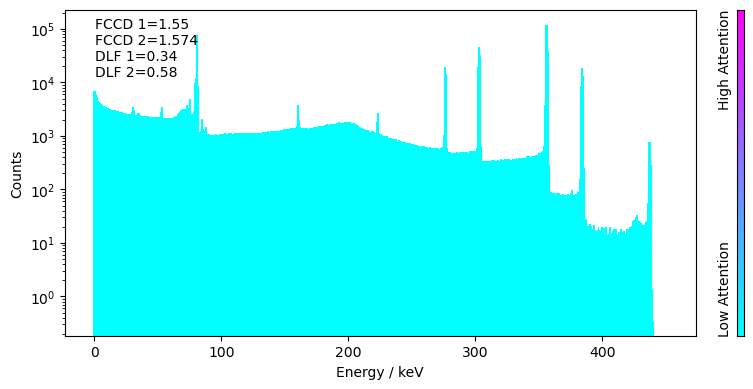

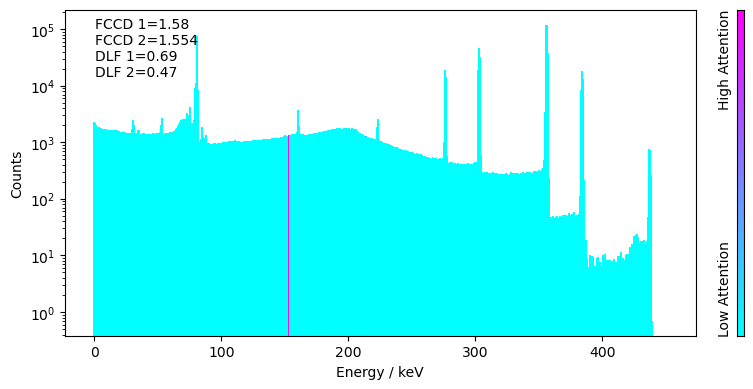

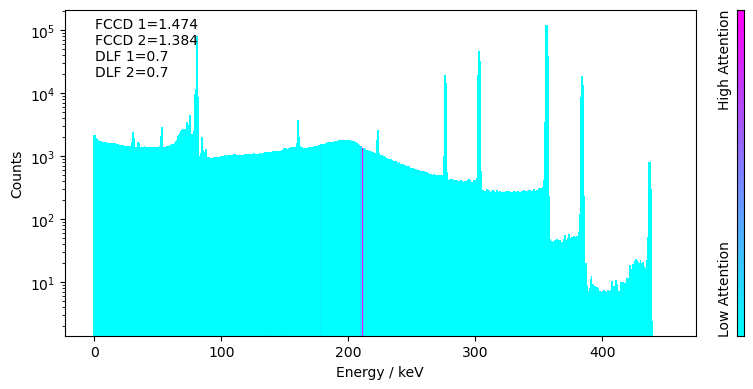

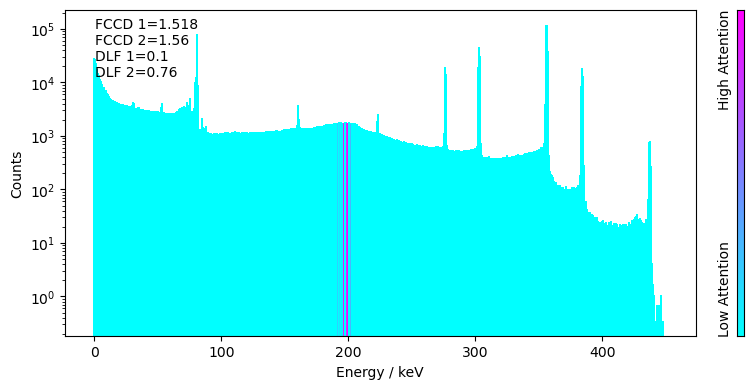

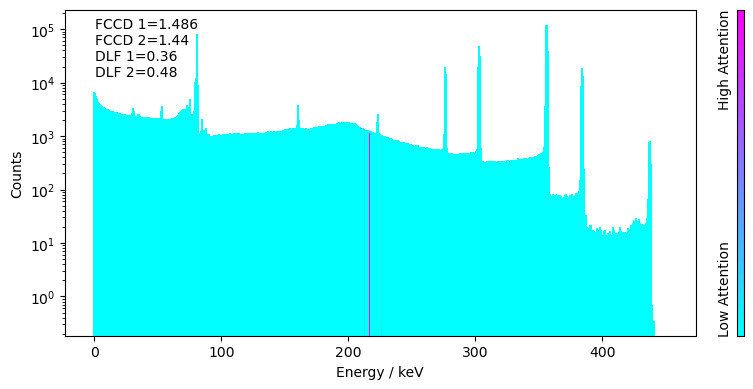

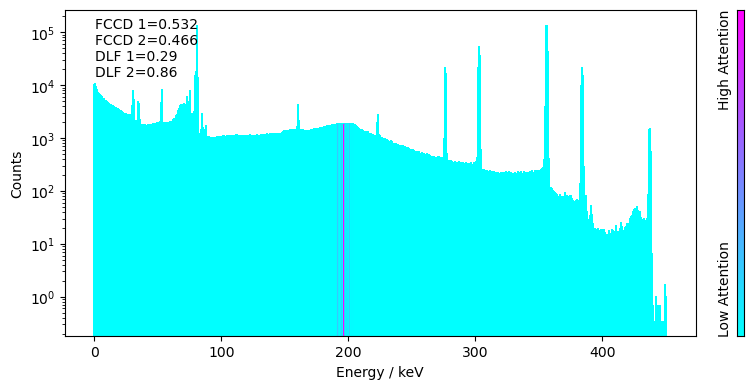

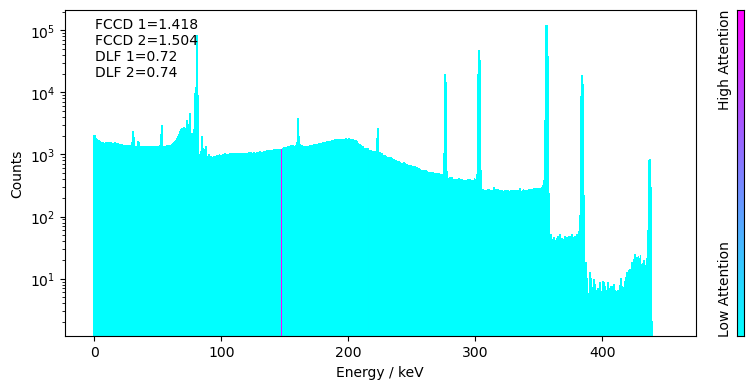

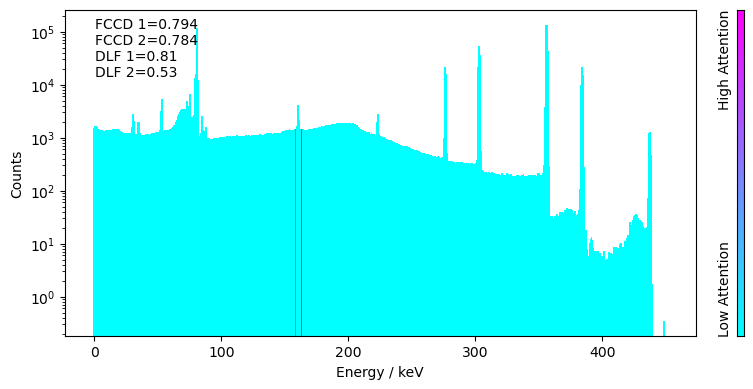

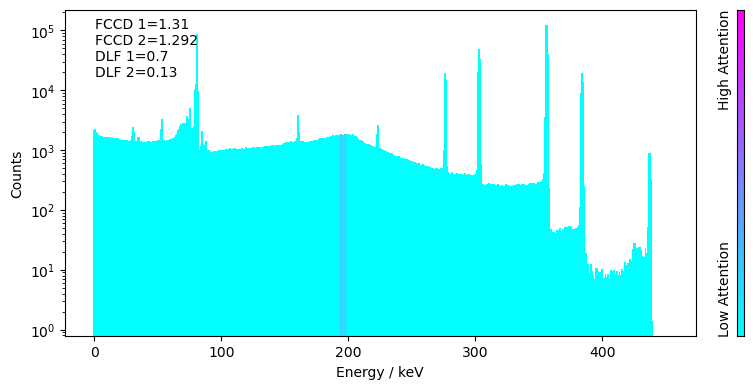

In [43]:
#Investigate Attention

#Make RNNinterpretor object and set get_attention to true
RNNinterpretor = RNN(dataset.get_histlen(),2)
RNNinterpretor.get_attention = True

#Load trained RNN dict to this
RNNinterpretor.load_state_dict(torch.load(model_path))
RNNinterpretor.eval()
RNNinterpretor.to(DEVICE)

import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages(CodePath+"/saved_models/"+RNN_ID+"/plots/test_attention.pdf")
   
for a in range (5):
    #Load a test events through interpretor
    test_spectrum_diff, test_FCCDLabel, test_DLFLabel, test_extras, test_spectrum = next(iter(test_loader))
    test_spectrum_diff = test_spectrum_diff.to(DEVICE).float()

    attention_score = RNNinterpretor(test_spectrum_diff)

    for i in range(BATCH_SIZE):
        attention = attention_score[i].cpu().detach().numpy()
        labels = {"FCCD1": test_extras["FCCD1"][i].item(), "FCCD2": test_extras["FCCD2"][i].item(), "DLF1": test_extras["DLF1"][i].item(), "DLF2": test_extras["DLF2"][i].item()}

        #plot attention score on spectrum
        fig = plot_attention(test_spectrum[i], attention, labels)
        pdf.savefig(fig)

pdf.close()

## Testing - on full dataset

In [44]:
#load full dataset
BATCH_SIZE = 4 
train_loader, test_loader, dataset = load_data(BATCH_SIZE, size=dataset_size)

100%|████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.55it/s]

(1000, 900)


  1%|▍                                                                                            | 4/750 [00:00<01:18,  9.53it/s]

DLF and FCCD misclassified for same trial:
j:  1 , i:  3
FCCD1:  1.992 , FCCD2:  0.212 , FCCD_diff:  1.78 , RNNoutput:  0.005708632
DLF1:  0.32 , DLF2:  0.29 , DLF_diff:  0.030000000000000027 , RNNoutput:  0.001114914


  1%|▉                                                                                            | 8/750 [00:00<01:13, 10.04it/s]

DLF and FCCD misclassified for same trial:
j:  5 , i:  2
FCCD1:  0.332 , FCCD2:  1.032 , FCCD_diff:  -0.7 , RNNoutput:  0.98294145
DLF1:  0.44 , DLF2:  0.45 , DLF_diff:  -0.010000000000000009 , RNNoutput:  0.5782983
DLF and FCCD misclassified for same trial:
j:  5 , i:  3
FCCD1:  1.114 , FCCD2:  0.364 , FCCD_diff:  0.7500000000000001 , RNNoutput:  0.008524491
DLF1:  0.47 , DLF2:  0.3 , DLF_diff:  0.16999999999999998 , RNNoutput:  0.049014777
DLF and FCCD misclassified for same trial:
j:  7 , i:  1
FCCD1:  1.912 , FCCD2:  0.89 , FCCD_diff:  1.0219999999999998 , RNNoutput:  0.009677947
DLF1:  0.66 , DLF2:  0.28 , DLF_diff:  0.38 , RNNoutput:  0.46617538
DLF and FCCD misclassified for same trial:
j:  7 , i:  3
FCCD1:  1.132 , FCCD2:  1.882 , FCCD_diff:  -0.75 , RNNoutput:  0.9838229
DLF1:  0.2 , DLF2:  0.22 , DLF_diff:  -0.01999999999999999 , RNNoutput:  0.5192


  1%|█▏                                                                                          | 10/750 [00:01<01:12, 10.16it/s]

DLF and FCCD misclassified for same trial:
j:  8 , i:  2
FCCD1:  1.472 , FCCD2:  0.554 , FCCD_diff:  0.9179999999999999 , RNNoutput:  0.019046813
DLF1:  0.61 , DLF2:  0.61 , DLF_diff:  0.0 , RNNoutput:  0.013169514
DLF and FCCD misclassified for same trial:
j:  10 , i:  3
FCCD1:  1.502 , FCCD2:  0.128 , FCCD_diff:  1.374 , RNNoutput:  0.009654853
DLF1:  0.68 , DLF2:  0.56 , DLF_diff:  0.12 , RNNoutput:  0.0041874005


  2%|█▉                                                                                          | 16/750 [00:01<01:08, 10.79it/s]

DLF and FCCD misclassified for same trial:
j:  14 , i:  3
FCCD1:  0.824 , FCCD2:  0.08 , FCCD_diff:  0.744 , RNNoutput:  0.012509847
DLF1:  0.61 , DLF2:  0.38 , DLF_diff:  0.22999999999999998 , RNNoutput:  0.020584548


  3%|██▍                                                                                         | 20/750 [00:01<01:06, 11.05it/s]

DLF and FCCD misclassified for same trial:
j:  18 , i:  0
FCCD1:  0.764 , FCCD2:  0.226 , FCCD_diff:  0.538 , RNNoutput:  0.012084913
DLF1:  0.49 , DLF2:  0.41 , DLF_diff:  0.08000000000000002 , RNNoutput:  0.09260587
DLF and FCCD misclassified for same trial:
j:  18 , i:  2
FCCD1:  1.776 , FCCD2:  0.102 , FCCD_diff:  1.674 , RNNoutput:  0.010401818
DLF1:  0.75 , DLF2:  0.66 , DLF_diff:  0.08999999999999997 , RNNoutput:  0.0030953682
DLF and FCCD misclassified for same trial:
j:  19 , i:  0
FCCD1:  1.63 , FCCD2:  0.646 , FCCD_diff:  0.9839999999999999 , RNNoutput:  0.00835193
DLF1:  0.6 , DLF2:  0.37 , DLF_diff:  0.22999999999999998 , RNNoutput:  0.04249358


  3%|██▉                                                                                         | 24/750 [00:02<01:04, 11.20it/s]

DLF and FCCD misclassified for same trial:
j:  21 , i:  3
FCCD1:  1.712 , FCCD2:  0.09 , FCCD_diff:  1.6219999999999999 , RNNoutput:  0.0100728795
DLF1:  0.81 , DLF2:  0.45 , DLF_diff:  0.36000000000000004 , RNNoutput:  0.010597804
DLF and FCCD misclassified for same trial:
j:  22 , i:  0
FCCD1:  1.828 , FCCD2:  0.438 , FCCD_diff:  1.3900000000000001 , RNNoutput:  0.00554908
DLF1:  0.73 , DLF2:  0.41 , DLF_diff:  0.32 , RNNoutput:  0.022171048
DLF and FCCD misclassified for same trial:
j:  23 , i:  0
FCCD1:  0.138 , FCCD2:  1.068 , FCCD_diff:  -0.93 , RNNoutput:  0.9831025
DLF1:  0.22 , DLF2:  0.38 , DLF_diff:  -0.16 , RNNoutput:  0.7441969


  4%|███▍                                                                                        | 28/750 [00:02<01:04, 11.26it/s]

DLF and FCCD misclassified for same trial:
j:  26 , i:  3
FCCD1:  0.946 , FCCD2:  0.438 , FCCD_diff:  0.508 , RNNoutput:  0.01636408
DLF1:  0.43 , DLF2:  0.41 , DLF_diff:  0.020000000000000018 , RNNoutput:  0.07211739
DLF and FCCD misclassified for same trial:
j:  27 , i:  3
FCCD1:  1.484 , FCCD2:  0.436 , FCCD_diff:  1.048 , RNNoutput:  0.004384672
DLF1:  0.51 , DLF2:  0.07 , DLF_diff:  0.44 , RNNoutput:  0.4750596


  5%|████▏                                                                                       | 34/750 [00:03<01:03, 11.31it/s]

DLF and FCCD misclassified for same trial:
j:  31 , i:  1
FCCD1:  0.14 , FCCD2:  1.54 , FCCD_diff:  -1.4 , RNNoutput:  0.98563206
DLF1:  0.12 , DLF2:  0.46 , DLF_diff:  -0.34 , RNNoutput:  0.7423521
DLF and FCCD misclassified for same trial:
j:  32 , i:  3
FCCD1:  0.13 , FCCD2:  1.418 , FCCD_diff:  -1.2879999999999998 , RNNoutput:  0.9883435
DLF1:  0.49 , DLF2:  0.72 , DLF_diff:  -0.22999999999999998 , RNNoutput:  0.57470936


  5%|████▍                                                                                       | 36/750 [00:03<01:03, 11.33it/s]

DLF and FCCD misclassified for same trial:
j:  34 , i:  2
FCCD1:  1.438 , FCCD2:  0.208 , FCCD_diff:  1.23 , RNNoutput:  0.008244261
DLF1:  0.73 , DLF2:  0.46 , DLF_diff:  0.26999999999999996 , RNNoutput:  0.01671264
DLF and FCCD misclassified for same trial:
j:  34 , i:  3
FCCD1:  1.716 , FCCD2:  0.95 , FCCD_diff:  0.766 , RNNoutput:  0.044039555
DLF1:  0.8 , DLF2:  0.76 , DLF_diff:  0.040000000000000036 , RNNoutput:  0.17031239
DLF and FCCD misclassified for same trial:
j:  35 , i:  0
FCCD1:  1.816 , FCCD2:  0.464 , FCCD_diff:  1.352 , RNNoutput:  0.016191695
DLF1:  0.91 , DLF2:  0.52 , DLF_diff:  0.39 , RNNoutput:  0.10709562
DLF and FCCD misclassified for same trial:
j:  35 , i:  2
FCCD1:  0.1 , FCCD2:  0.672 , FCCD_diff:  -0.5720000000000001 , RNNoutput:  0.976917
DLF1:  0.71 , DLF2:  0.71 , DLF_diff:  0.0 , RNNoutput:  0.3279363


  5%|████▉                                                                                       | 40/750 [00:03<01:02, 11.36it/s]

DLF and FCCD misclassified for same trial:
j:  37 , i:  0
FCCD1:  1.552 , FCCD2:  0.832 , FCCD_diff:  0.7200000000000001 , RNNoutput:  0.004857028
DLF1:  0.24 , DLF2:  0.09 , DLF_diff:  0.15 , RNNoutput:  0.10383186
DLF and FCCD misclassified for same trial:
j:  38 , i:  0
FCCD1:  1.478 , FCCD2:  0.596 , FCCD_diff:  0.882 , RNNoutput:  0.005844251
DLF1:  0.5 , DLF2:  0.23 , DLF_diff:  0.27 , RNNoutput:  0.24373919


  6%|█████▏                                                                                      | 42/750 [00:03<01:02, 11.37it/s]

DLF and FCCD misclassified for same trial:
j:  40 , i:  1
FCCD1:  1.996 , FCCD2:  0.348 , FCCD_diff:  1.6480000000000001 , RNNoutput:  0.012873451
DLF1:  0.83 , DLF2:  0.69 , DLF_diff:  0.14 , RNNoutput:  0.006993757
DLF and FCCD misclassified for same trial:
j:  41 , i:  0
FCCD1:  1.256 , FCCD2:  0.358 , FCCD_diff:  0.898 , RNNoutput:  0.013262388
DLF1:  0.64 , DLF2:  0.5 , DLF_diff:  0.14 , RNNoutput:  0.01865871
DLF and FCCD misclassified for same trial:
j:  42 , i:  3
FCCD1:  0.028 , FCCD2:  1.404 , FCCD_diff:  -1.376 , RNNoutput:  0.9886077
DLF1:  0.22 , DLF2:  0.67 , DLF_diff:  -0.45000000000000007 , RNNoutput:  0.8406898


  6%|█████▋                                                                                      | 46/750 [00:04<01:02, 11.28it/s]

DLF and FCCD misclassified for same trial:
j:  44 , i:  1
FCCD1:  1.56 , FCCD2:  0.676 , FCCD_diff:  0.884 , RNNoutput:  0.01791403
DLF1:  0.76 , DLF2:  0.48 , DLF_diff:  0.28 , RNNoutput:  0.25749665
DLF and FCCD misclassified for same trial:
j:  45 , i:  0
FCCD1:  1.008 , FCCD2:  0.532 , FCCD_diff:  0.476 , RNNoutput:  0.014483017
DLF1:  0.33 , DLF2:  0.29 , DLF_diff:  0.040000000000000036 , RNNoutput:  0.13558695
DLF and FCCD misclassified for same trial:
j:  46 , i:  3
FCCD1:  1.63 , FCCD2:  0.066 , FCCD_diff:  1.5639999999999998 , RNNoutput:  0.009856686
DLF1:  0.64 , DLF2:  0.47 , DLF_diff:  0.17000000000000004 , RNNoutput:  0.0021212394


  7%|██████▌                                                                                     | 54/750 [00:04<01:01, 11.24it/s]

DLF and FCCD misclassified for same trial:
j:  52 , i:  0
FCCD1:  1.996 , FCCD2:  0.416 , FCCD_diff:  1.58 , RNNoutput:  0.0030065132
DLF1:  0.43 , DLF2:  0.25 , DLF_diff:  0.18 , RNNoutput:  0.00382869
DLF and FCCD misclassified for same trial:
j:  52 , i:  1
FCCD1:  0.144 , FCCD2:  1.7 , FCCD_diff:  -1.556 , RNNoutput:  0.98929954
DLF1:  0.47 , DLF2:  0.63 , DLF_diff:  -0.16000000000000003 , RNNoutput:  0.74224126


  8%|███████                                                                                     | 58/750 [00:05<01:01, 11.20it/s]

DLF and FCCD misclassified for same trial:
j:  55 , i:  0
FCCD1:  1.62 , FCCD2:  0.616 , FCCD_diff:  1.004 , RNNoutput:  0.021413201
DLF1:  0.89 , DLF2:  0.67 , DLF_diff:  0.21999999999999997 , RNNoutput:  0.27020383
DLF and FCCD misclassified for same trial:
j:  55 , i:  3
FCCD1:  0.252 , FCCD2:  1.674 , FCCD_diff:  -1.422 , RNNoutput:  0.9881455
DLF1:  0.67 , DLF2:  0.7 , DLF_diff:  -0.029999999999999916 , RNNoutput:  0.72402745
DLF and FCCD misclassified for same trial:
j:  56 , i:  3
FCCD1:  1.704 , FCCD2:  0.19 , FCCD_diff:  1.514 , RNNoutput:  0.01834754
DLF1:  0.99 , DLF2:  0.84 , DLF_diff:  0.15000000000000002 , RNNoutput:  0.02185604


  8%|███████▎                                                                                    | 60/750 [00:05<01:01, 11.24it/s]

DLF and FCCD misclassified for same trial:
j:  58 , i:  2
FCCD1:  1.306 , FCCD2:  0.1 , FCCD_diff:  1.206 , RNNoutput:  0.014097679
DLF1:  0.92 , DLF2:  0.71 , DLF_diff:  0.21000000000000008 , RNNoutput:  0.024936678
DLF and FCCD misclassified for same trial:
j:  58 , i:  3
FCCD1:  0.942 , FCCD2:  0.412 , FCCD_diff:  0.53 , RNNoutput:  0.012163688
DLF1:  0.47 , DLF2:  0.35 , DLF_diff:  0.12 , RNNoutput:  0.12631063
DLF and FCCD misclassified for same trial:
j:  60 , i:  2
FCCD1:  0.106 , FCCD2:  1.794 , FCCD_diff:  -1.688 , RNNoutput:  0.99107975
DLF1:  0.49 , DLF2:  0.59 , DLF_diff:  -0.09999999999999998 , RNNoutput:  0.80666286


  9%|████████                                                                                    | 66/750 [00:05<01:00, 11.28it/s]

DLF and FCCD misclassified for same trial:
j:  63 , i:  0
FCCD1:  1.656 , FCCD2:  0.408 , FCCD_diff:  1.248 , RNNoutput:  0.0077649658
DLF1:  0.46 , DLF2:  0.44 , DLF_diff:  0.020000000000000018 , RNNoutput:  0.0031314716


  9%|████████▎                                                                                   | 68/750 [00:06<01:00, 11.22it/s]

DLF and FCCD misclassified for same trial:
j:  66 , i:  0
FCCD1:  1.504 , FCCD2:  0.754 , FCCD_diff:  0.75 , RNNoutput:  0.02408131
DLF1:  0.74 , DLF2:  0.58 , DLF_diff:  0.16000000000000003 , RNNoutput:  0.10867663


 10%|████████▊                                                                                   | 72/750 [00:06<01:00, 11.26it/s]

DLF and FCCD misclassified for same trial:
j:  70 , i:  2
FCCD1:  0.424 , FCCD2:  1.312 , FCCD_diff:  -0.8880000000000001 , RNNoutput:  0.99030626
DLF1:  0.44 , DLF2:  0.53 , DLF_diff:  -0.09000000000000002 , RNNoutput:  0.58741194


 10%|█████████▌                                                                                  | 78/750 [00:07<00:59, 11.30it/s]

DLF and FCCD misclassified for same trial:
j:  75 , i:  0
FCCD1:  1.978 , FCCD2:  0.344 , FCCD_diff:  1.634 , RNNoutput:  0.0028924868
DLF1:  0.4 , DLF2:  0.14 , DLF_diff:  0.26 , RNNoutput:  0.0068329093
DLF and FCCD misclassified for same trial:
j:  76 , i:  1
FCCD1:  0.872 , FCCD2:  1.954 , FCCD_diff:  -1.0819999999999999 , RNNoutput:  0.9894615
DLF1:  0.44 , DLF2:  0.51 , DLF_diff:  -0.07 , RNNoutput:  0.63275236
DLF and FCCD misclassified for same trial:
j:  77 , i:  3
FCCD1:  1.912 , FCCD2:  0.672 , FCCD_diff:  1.2399999999999998 , RNNoutput:  0.010082916
DLF1:  0.66 , DLF2:  0.42 , DLF_diff:  0.24000000000000005 , RNNoutput:  0.026830913


 11%|██████████                                                                                  | 82/750 [00:07<00:59, 11.30it/s]

DLF and FCCD misclassified for same trial:
j:  79 , i:  0
FCCD1:  1.712 , FCCD2:  0.364 , FCCD_diff:  1.3479999999999999 , RNNoutput:  0.0058430093
DLF1:  0.81 , DLF2:  0.3 , DLF_diff:  0.51 , RNNoutput:  0.31636629
DLF and FCCD misclassified for same trial:
j:  81 , i:  2
FCCD1:  1.76 , FCCD2:  0.23 , FCCD_diff:  1.53 , RNNoutput:  0.0040063965
DLF1:  0.69 , DLF2:  0.02 , DLF_diff:  0.6699999999999999 , RNNoutput:  0.08273144


 12%|███████████▎                                                                                | 92/750 [00:08<00:58, 11.23it/s]

DLF and FCCD misclassified for same trial:
j:  89 , i:  3
FCCD1:  1.42 , FCCD2:  0.352 , FCCD_diff:  1.068 , RNNoutput:  0.01478713
DLF1:  0.94 , DLF2:  0.51 , DLF_diff:  0.42999999999999994 , RNNoutput:  0.19502443
DLF and FCCD misclassified for same trial:
j:  91 , i:  3
FCCD1:  0.014 , FCCD2:  1.986 , FCCD_diff:  -1.972 , RNNoutput:  0.99163437
DLF1:  0.45 , DLF2:  0.85 , DLF_diff:  -0.39999999999999997 , RNNoutput:  0.85781795


 13%|███████████▌                                                                                | 94/750 [00:08<00:58, 11.20it/s]

DLF and FCCD misclassified for same trial:
j:  92 , i:  0
FCCD1:  1.846 , FCCD2:  0.28 , FCCD_diff:  1.566 , RNNoutput:  0.0032176003
DLF1:  0.37 , DLF2:  0.0 , DLF_diff:  0.37 , RNNoutput:  0.010580272
DLF and FCCD misclassified for same trial:
j:  94 , i:  2
FCCD1:  0.308 , FCCD2:  1.178 , FCCD_diff:  -0.8699999999999999 , RNNoutput:  0.98070186
DLF1:  0.29 , DLF2:  0.36 , DLF_diff:  -0.07 , RNNoutput:  0.5988386


 13%|████████████                                                                                | 98/750 [00:08<00:57, 11.24it/s]

DLF and FCCD misclassified for same trial:
j:  96 , i:  0
FCCD1:  1.816 , FCCD2:  0.646 , FCCD_diff:  1.17 , RNNoutput:  0.011166695
DLF1:  0.74 , DLF2:  0.37 , DLF_diff:  0.37 , RNNoutput:  0.09886401


 14%|████████████▌                                                                              | 104/750 [00:09<00:57, 11.19it/s]

DLF and FCCD misclassified for same trial:
j:  102 , i:  0
FCCD1:  2.0 , FCCD2:  0.82 , FCCD_diff:  1.1800000000000002 , RNNoutput:  0.02448962
DLF1:  0.96 , DLF2:  0.9 , DLF_diff:  0.05999999999999994 , RNNoutput:  0.18506715


 14%|█████████████                                                                              | 108/750 [00:09<00:57, 11.21it/s]

DLF and FCCD misclassified for same trial:
j:  106 , i:  2
FCCD1:  1.988 , FCCD2:  0.28 , FCCD_diff:  1.708 , RNNoutput:  0.003100848
DLF1:  0.63 , DLF2:  0.0 , DLF_diff:  0.63 , RNNoutput:  0.020907586


 15%|█████████████▌                                                                             | 112/750 [00:10<00:56, 11.29it/s]

DLF and FCCD misclassified for same trial:
j:  110 , i:  3
FCCD1:  1.086 , FCCD2:  0.376 , FCCD_diff:  0.7100000000000001 , RNNoutput:  0.00796407
DLF1:  0.42 , DLF2:  0.19 , DLF_diff:  0.22999999999999998 , RNNoutput:  0.4743943
DLF and FCCD misclassified for same trial:
j:  111 , i:  1
FCCD1:  0.14 , FCCD2:  1.812 , FCCD_diff:  -1.6720000000000002 , RNNoutput:  0.9913761
DLF1:  0.7 , DLF2:  0.76 , DLF_diff:  -0.06000000000000005 , RNNoutput:  0.738772
DLF and FCCD misclassified for same trial:
j:  112 , i:  3
FCCD1:  1.402 , FCCD2:  0.106 , FCCD_diff:  1.2959999999999998 , RNNoutput:  0.010565752
DLF1:  0.6 , DLF2:  0.49 , DLF_diff:  0.10999999999999999 , RNNoutput:  0.0041813087


 16%|██████████████▎                                                                            | 118/750 [00:10<00:55, 11.29it/s]

DLF and FCCD misclassified for same trial:
j:  115 , i:  2
FCCD1:  1.56 , FCCD2:  0.28 , FCCD_diff:  1.28 , RNNoutput:  0.014337993
DLF1:  0.76 , DLF2:  0.69 , DLF_diff:  0.07000000000000006 , RNNoutput:  0.0086076865


 17%|███████████████▎                                                                           | 126/750 [00:11<01:02,  9.92it/s]

DLF and FCCD misclassified for same trial:
j:  123 , i:  3
FCCD1:  0.846 , FCCD2:  0.056 , FCCD_diff:  0.7899999999999999 , RNNoutput:  0.015825639
DLF1:  0.81 , DLF2:  0.42 , DLF_diff:  0.39000000000000007 , RNNoutput:  0.08803344


 18%|████████████████                                                                           | 132/750 [00:12<00:59, 10.32it/s]

DLF and FCCD misclassified for same trial:
j:  129 , i:  0
FCCD1:  0.134 , FCCD2:  1.63 , FCCD_diff:  -1.496 , RNNoutput:  0.99060893
DLF1:  0.56 , DLF2:  0.6 , DLF_diff:  -0.039999999999999925 , RNNoutput:  0.81215155


 18%|████████████████▌                                                                          | 136/750 [00:12<00:58, 10.42it/s]

DLF and FCCD misclassified for same trial:
j:  134 , i:  0
FCCD1:  0.128 , FCCD2:  1.998 , FCCD_diff:  -1.87 , RNNoutput:  0.9925662
DLF1:  0.56 , DLF2:  0.77 , DLF_diff:  -0.20999999999999996 , RNNoutput:  0.7092185
DLF and FCCD misclassified for same trial:
j:  134 , i:  3
FCCD1:  1.87 , FCCD2:  0.634 , FCCD_diff:  1.2360000000000002 , RNNoutput:  0.019974498
DLF1:  0.82 , DLF2:  0.74 , DLF_diff:  0.07999999999999996 , RNNoutput:  0.035191275


 19%|█████████████████▍                                                                         | 144/750 [00:13<00:55, 10.97it/s]

DLF and FCCD misclassified for same trial:
j:  141 , i:  1
FCCD1:  1.76 , FCCD2:  0.146 , FCCD_diff:  1.614 , RNNoutput:  0.009505599
DLF1:  0.69 , DLF2:  0.61 , DLF_diff:  0.07999999999999996 , RNNoutput:  0.0036381327
DLF and FCCD misclassified for same trial:
j:  142 , i:  1
FCCD1:  0.052 , FCCD2:  1.082 , FCCD_diff:  -1.03 , RNNoutput:  0.9859833
DLF1:  0.32 , DLF2:  0.62 , DLF_diff:  -0.3 , RNNoutput:  0.66194594


 19%|█████████████████▋                                                                         | 146/750 [00:13<00:55, 10.98it/s]

DLF and FCCD misclassified for same trial:
j:  144 , i:  0
FCCD1:  0.154 , FCCD2:  1.936 , FCCD_diff:  -1.782 , RNNoutput:  0.9927947
DLF1:  0.67 , DLF2:  0.76 , DLF_diff:  -0.08999999999999997 , RNNoutput:  0.75441587
DLF and FCCD misclassified for same trial:
j:  145 , i:  1
FCCD1:  1.992 , FCCD2:  0.796 , FCCD_diff:  1.196 , RNNoutput:  0.0045269383
DLF1:  0.32 , DLF2:  0.23 , DLF_diff:  0.09 , RNNoutput:  0.0070115533


 21%|██████████████████▊                                                                        | 155/750 [00:14<01:07,  8.76it/s]

DLF and FCCD misclassified for same trial:
j:  153 , i:  3
FCCD1:  0.028 , FCCD2:  1.804 , FCCD_diff:  -1.776 , RNNoutput:  0.9908827
DLF1:  0.28 , DLF2:  0.84 , DLF_diff:  -0.5599999999999999 , RNNoutput:  0.7552416


 21%|███████████████████▍                                                                       | 160/750 [00:14<01:00,  9.82it/s]

DLF and FCCD misclassified for same trial:
j:  158 , i:  0
FCCD1:  1.828 , FCCD2:  0.232 , FCCD_diff:  1.596 , RNNoutput:  0.0057346765
DLF1:  0.73 , DLF2:  0.17 , DLF_diff:  0.5599999999999999 , RNNoutput:  0.07826992
DLF and FCCD misclassified for same trial:
j:  159 , i:  3
FCCD1:  0.498 , FCCD2:  1.988 , FCCD_diff:  -1.49 , RNNoutput:  0.9896707
DLF1:  0.54 , DLF2:  0.63 , DLF_diff:  -0.08999999999999997 , RNNoutput:  0.7423761


 22%|███████████████████▉                                                                       | 164/750 [00:15<00:58, 10.07it/s]

DLF and FCCD misclassified for same trial:
j:  162 , i:  0
FCCD1:  1.916 , FCCD2:  0.706 , FCCD_diff:  1.21 , RNNoutput:  0.002634731
DLF1:  0.25 , DLF2:  0.07 , DLF_diff:  0.18 , RNNoutput:  0.009820341


 22%|████████████████████▍                                                                      | 168/750 [00:15<00:56, 10.33it/s]

DLF and FCCD misclassified for same trial:
j:  166 , i:  0
FCCD1:  1.276 , FCCD2:  0.582 , FCCD_diff:  0.6940000000000001 , RNNoutput:  0.025398329
DLF1:  0.89 , DLF2:  0.69 , DLF_diff:  0.20000000000000007 , RNNoutput:  0.3615559
DLF and FCCD misclassified for same trial:
j:  166 , i:  1
FCCD1:  1.44 , FCCD2:  0.9 , FCCD_diff:  0.5399999999999999 , RNNoutput:  0.015990341
DLF1:  0.48 , DLF2:  0.33 , DLF_diff:  0.14999999999999997 , RNNoutput:  0.29351786


 23%|████████████████████▊                                                                      | 172/750 [00:15<00:53, 10.74it/s]

DLF and FCCD misclassified for same trial:
j:  169 , i:  2
FCCD1:  0.044 , FCCD2:  1.212 , FCCD_diff:  -1.168 , RNNoutput:  0.9856565
DLF1:  0.06 , DLF2:  0.59 , DLF_diff:  -0.53 , RNNoutput:  0.7521459


 24%|█████████████████████▊                                                                     | 180/750 [00:16<00:51, 11.11it/s]

DLF and FCCD misclassified for same trial:
j:  177 , i:  1
FCCD1:  0.02 , FCCD2:  1.42 , FCCD_diff:  -1.4 , RNNoutput:  0.99179286
DLF1:  0.71 , DLF2:  0.94 , DLF_diff:  -0.22999999999999998 , RNNoutput:  0.6866349
DLF and FCCD misclassified for same trial:
j:  179 , i:  0
FCCD1:  1.932 , FCCD2:  0.11 , FCCD_diff:  1.8219999999999998 , RNNoutput:  0.017570956
DLF1:  0.56 , DLF2:  0.05 , DLF_diff:  0.51 , RNNoutput:  0.0082366


 24%|██████████████████████                                                                     | 182/750 [00:16<00:50, 11.16it/s]

DLF and FCCD misclassified for same trial:
j:  180 , i:  3
FCCD1:  1.816 , FCCD2:  0.19 , FCCD_diff:  1.6260000000000001 , RNNoutput:  0.015231531
DLF1:  0.91 , DLF2:  0.74 , DLF_diff:  0.17000000000000004 , RNNoutput:  0.017060112
DLF and FCCD misclassified for same trial:
j:  182 , i:  0
FCCD1:  1.67 , FCCD2:  0.352 , FCCD_diff:  1.318 , RNNoutput:  0.007890846
DLF1:  0.24 , DLF2:  0.24 , DLF_diff:  0.0 , RNNoutput:  0.001172077


 25%|██████████████████████▌                                                                    | 186/750 [00:17<00:50, 11.14it/s]

DLF and FCCD misclassified for same trial:
j:  184 , i:  3
FCCD1:  2.0 , FCCD2:  0.876 , FCCD_diff:  1.124 , RNNoutput:  0.0028848355
DLF1:  0.18 , DLF2:  0.01 , DLF_diff:  0.16999999999999998 , RNNoutput:  0.012643372


 26%|███████████████████████▊                                                                   | 196/750 [00:18<00:49, 11.11it/s]

DLF and FCCD misclassified for same trial:
j:  194 , i:  0
FCCD1:  1.822 , FCCD2:  0.134 , FCCD_diff:  1.6880000000000002 , RNNoutput:  0.018086798
DLF1:  0.95 , DLF2:  0.82 , DLF_diff:  0.13 , RNNoutput:  0.013387186
DLF and FCCD misclassified for same trial:
j:  195 , i:  2
FCCD1:  0.066 , FCCD2:  1.046 , FCCD_diff:  -0.98 , RNNoutput:  0.9848171
DLF1:  0.47 , DLF2:  0.56 , DLF_diff:  -0.09000000000000008 , RNNoutput:  0.88743687
DLF and FCCD misclassified for same trial:
j:  195 , i:  3
FCCD1:  1.776 , FCCD2:  0.022 , FCCD_diff:  1.754 , RNNoutput:  0.011635774
DLF1:  0.75 , DLF2:  0.26 , DLF_diff:  0.49 , RNNoutput:  0.0028219754
DLF and FCCD misclassified for same trial:
j:  196 , i:  3
FCCD1:  1.014 , FCCD2:  0.366 , FCCD_diff:  0.648 , RNNoutput:  0.019385867
DLF1:  0.67 , DLF2:  0.66 , DLF_diff:  0.010000000000000009 , RNNoutput:  0.054995287


 27%|████████████████████████▎                                                                  | 200/750 [00:18<00:49, 11.19it/s]

DLF and FCCD misclassified for same trial:
j:  197 , i:  3
FCCD1:  1.454 , FCCD2:  0.02 , FCCD_diff:  1.434 , RNNoutput:  0.020082764
DLF1:  0.98 , DLF2:  0.02 , DLF_diff:  0.96 , RNNoutput:  0.05270884
DLF and FCCD misclassified for same trial:
j:  199 , i:  0
FCCD1:  0.812 , FCCD2:  1.69 , FCCD_diff:  -0.8779999999999999 , RNNoutput:  0.98484355
DLF1:  0.36 , DLF2:  0.42 , DLF_diff:  -0.06 , RNNoutput:  0.5357152
DLF and FCCD misclassified for same trial:
j:  199 , i:  2
FCCD1:  1.454 , FCCD2:  0.5 , FCCD_diff:  0.954 , RNNoutput:  0.028284866
DLF1:  0.98 , DLF2:  0.9 , DLF_diff:  0.07999999999999996 , RNNoutput:  0.13741472


 27%|████████████████████████▌                                                                  | 202/750 [00:18<00:49, 11.11it/s]

DLF and FCCD misclassified for same trial:
j:  200 , i:  1
FCCD1:  0.598 , FCCD2:  1.836 , FCCD_diff:  -1.238 , RNNoutput:  0.9868081
DLF1:  0.39 , DLF2:  0.59 , DLF_diff:  -0.19999999999999996 , RNNoutput:  0.53303725


 28%|█████████████████████████▋                                                                 | 212/750 [00:19<00:48, 11.15it/s]

DLF and FCCD misclassified for same trial:
j:  209 , i:  1
FCCD1:  0.074 , FCCD2:  1.676 , FCCD_diff:  -1.6019999999999999 , RNNoutput:  0.99148566
DLF1:  0.73 , DLF2:  1.0 , DLF_diff:  -0.27 , RNNoutput:  0.5237828


 29%|██████████████████████████▏                                                                | 216/750 [00:19<00:47, 11.15it/s]

DLF and FCCD misclassified for same trial:
j:  213 , i:  1
FCCD1:  0.02 , FCCD2:  1.73 , FCCD_diff:  -1.71 , RNNoutput:  0.9932239
DLF1:  0.06 , DLF2:  0.89 , DLF_diff:  -0.8300000000000001 , RNNoutput:  0.701986


 29%|██████████████████████████▍                                                                | 218/750 [00:20<00:47, 11.18it/s]

DLF and FCCD misclassified for same trial:
j:  216 , i:  2
FCCD1:  1.828 , FCCD2:  0.212 , FCCD_diff:  1.616 , RNNoutput:  0.0060266284
DLF1:  0.73 , DLF2:  0.5 , DLF_diff:  0.22999999999999998 , RNNoutput:  0.008964752


 30%|██████████████████████████▉                                                                | 222/750 [00:20<00:47, 11.11it/s]

DLF and FCCD misclassified for same trial:
j:  220 , i:  1
FCCD1:  1.526 , FCCD2:  0.308 , FCCD_diff:  1.218 , RNNoutput:  0.006862692
DLF1:  0.3 , DLF2:  0.29 , DLF_diff:  0.010000000000000009 , RNNoutput:  0.0020266366
DLF and FCCD misclassified for same trial:
j:  220 , i:  2
FCCD1:  1.556 , FCCD2:  0.226 , FCCD_diff:  1.33 , RNNoutput:  0.007342354
DLF1:  0.76 , DLF2:  0.41 , DLF_diff:  0.35000000000000003 , RNNoutput:  0.027386267
DLF and FCCD misclassified for same trial:
j:  220 , i:  3
FCCD1:  1.312 , FCCD2:  0.056 , FCCD_diff:  1.256 , RNNoutput:  0.0141664175
DLF1:  0.53 , DLF2:  0.42 , DLF_diff:  0.11000000000000004 , RNNoutput:  0.0017001445


 30%|███████████████████████████▍                                                               | 226/750 [00:20<00:47, 11.09it/s]

DLF and FCCD misclassified for same trial:
j:  224 , i:  1
FCCD1:  1.694 , FCCD2:  0.266 , FCCD_diff:  1.428 , RNNoutput:  0.009288618
DLF1:  0.68 , DLF2:  0.55 , DLF_diff:  0.13 , RNNoutput:  0.0063182553


 31%|████████████████████████████▏                                                              | 232/750 [00:21<00:46, 11.13it/s]

DLF and FCCD misclassified for same trial:
j:  230 , i:  1
FCCD1:  0.604 , FCCD2:  1.694 , FCCD_diff:  -1.0899999999999999 , RNNoutput:  0.97892237
DLF1:  0.55 , DLF2:  0.68 , DLF_diff:  -0.13 , RNNoutput:  0.55327255


 31%|████████████████████████████▋                                                              | 236/750 [00:21<00:45, 11.27it/s]

DLF and FCCD misclassified for same trial:
j:  233 , i:  1
FCCD1:  0.466 , FCCD2:  1.828 , FCCD_diff:  -1.362 , RNNoutput:  0.99189055
DLF1:  0.52 , DLF2:  0.73 , DLF_diff:  -0.20999999999999996 , RNNoutput:  0.59700304
DLF and FCCD misclassified for same trial:
j:  235 , i:  1
FCCD1:  1.602 , FCCD2:  0.754 , FCCD_diff:  0.8480000000000001 , RNNoutput:  0.023001354
DLF1:  0.75 , DLF2:  0.58 , DLF_diff:  0.17000000000000004 , RNNoutput:  0.11202665


 32%|█████████████████████████████▎                                                             | 242/750 [00:22<00:45, 11.22it/s]

DLF and FCCD misclassified for same trial:
j:  239 , i:  1
FCCD1:  0.056 , FCCD2:  1.408 , FCCD_diff:  -1.3519999999999999 , RNNoutput:  0.98917514
DLF1:  0.74 , DLF2:  0.81 , DLF_diff:  -0.07000000000000006 , RNNoutput:  0.787619


 33%|█████████████████████████████▊                                                             | 246/750 [00:22<00:45, 11.20it/s]

DLF and FCCD misclassified for same trial:
j:  244 , i:  1
FCCD1:  1.454 , FCCD2:  0.168 , FCCD_diff:  1.286 , RNNoutput:  0.017679028
DLF1:  0.98 , DLF2:  0.69 , DLF_diff:  0.29000000000000004 , RNNoutput:  0.082672246


 33%|██████████████████████████████▎                                                            | 250/750 [00:22<00:44, 11.19it/s]

DLF and FCCD misclassified for same trial:
j:  248 , i:  0
FCCD1:  1.332 , FCCD2:  0.198 , FCCD_diff:  1.1340000000000001 , RNNoutput:  0.016874544
DLF1:  0.91 , DLF2:  0.53 , DLF_diff:  0.38 , RNNoutput:  0.33848315
DLF and FCCD misclassified for same trial:
j:  249 , i:  2
FCCD1:  1.114 , FCCD2:  0.448 , FCCD_diff:  0.6660000000000001 , RNNoutput:  0.01232239
DLF1:  0.47 , DLF2:  0.37 , DLF_diff:  0.09999999999999998 , RNNoutput:  0.030004276


 34%|███████████████████████████████                                                            | 256/750 [00:23<00:44, 11.18it/s]

DLF and FCCD misclassified for same trial:
j:  254 , i:  2
FCCD1:  1.9 , FCCD2:  0.74 , FCCD_diff:  1.16 , RNNoutput:  0.004873729
DLF1:  0.53 , DLF2:  0.23 , DLF_diff:  0.30000000000000004 , RNNoutput:  0.13713335
DLF and FCCD misclassified for same trial:
j:  255 , i:  2
FCCD1:  1.46 , FCCD2:  0.362 , FCCD_diff:  1.0979999999999999 , RNNoutput:  0.004859324
DLF1:  0.67 , DLF2:  0.34 , DLF_diff:  0.33 , RNNoutput:  0.05205636


 35%|████████████████████████████████▎                                                          | 266/750 [00:24<00:43, 11.22it/s]

DLF and FCCD misclassified for same trial:
j:  264 , i:  3
FCCD1:  1.67 , FCCD2:  0.344 , FCCD_diff:  1.326 , RNNoutput:  0.059841458
DLF1:  0.24 , DLF2:  0.14 , DLF_diff:  0.09999999999999998 , RNNoutput:  0.29155573


 36%|████████████████████████████████▊                                                          | 270/750 [00:24<00:43, 11.09it/s]

DLF and FCCD misclassified for same trial:
j:  267 , i:  1
FCCD1:  1.326 , FCCD2:  0.38 , FCCD_diff:  0.9460000000000001 , RNNoutput:  0.008850754
DLF1:  0.67 , DLF2:  0.42 , DLF_diff:  0.25000000000000006 , RNNoutput:  0.04129474


 37%|█████████████████████████████████▏                                                         | 274/750 [00:25<00:42, 11.14it/s]

DLF and FCCD misclassified for same trial:
j:  271 , i:  0
FCCD1:  1.694 , FCCD2:  0.596 , FCCD_diff:  1.0979999999999999 , RNNoutput:  0.020322364
DLF1:  0.68 , DLF2:  0.6 , DLF_diff:  0.08000000000000007 , RNNoutput:  0.021792872
DLF and FCCD misclassified for same trial:
j:  271 , i:  1
FCCD1:  0.098 , FCCD2:  1.194 , FCCD_diff:  -1.0959999999999999 , RNNoutput:  0.9868911
DLF1:  0.4 , DLF2:  0.7 , DLF_diff:  -0.29999999999999993 , RNNoutput:  0.5213508


 37%|█████████████████████████████████▍                                                         | 276/750 [00:25<00:42, 11.12it/s]

DLF and FCCD misclassified for same trial:
j:  274 , i:  1
FCCD1:  0.4 , FCCD2:  1.268 , FCCD_diff:  -0.868 , RNNoutput:  0.97551674
DLF1:  0.17 , DLF2:  0.27 , DLF_diff:  -0.1 , RNNoutput:  0.51511014


 38%|██████████████████████████████████▏                                                        | 282/750 [00:25<00:41, 11.23it/s]

DLF and FCCD misclassified for same trial:
j:  279 , i:  1
FCCD1:  0.044 , FCCD2:  1.304 , FCCD_diff:  -1.26 , RNNoutput:  0.9871947
DLF1:  0.06 , DLF2:  0.64 , DLF_diff:  -0.5800000000000001 , RNNoutput:  0.7439027
DLF and FCCD misclassified for same trial:
j:  279 , i:  3
FCCD1:  1.682 , FCCD2:  0.808 , FCCD_diff:  0.8739999999999999 , RNNoutput:  0.012111478
DLF1:  0.37 , DLF2:  0.31 , DLF_diff:  0.06 , RNNoutput:  0.012159988


 39%|███████████████████████████████████▏                                                       | 290/750 [00:26<00:47,  9.74it/s]

DLF and FCCD misclassified for same trial:
j:  288 , i:  2
FCCD1:  1.312 , FCCD2:  0.416 , FCCD_diff:  0.8960000000000001 , RNNoutput:  0.0057522994
DLF1:  0.53 , DLF2:  0.25 , DLF_diff:  0.28 , RNNoutput:  0.09428069


 40%|████████████████████████████████████▏                                                      | 298/750 [00:27<00:43, 10.37it/s]

DLF and FCCD misclassified for same trial:
j:  296 , i:  1
FCCD1:  0.5 , FCCD2:  1.634 , FCCD_diff:  -1.134 , RNNoutput:  0.9889416
DLF1:  0.48 , DLF2:  0.51 , DLF_diff:  -0.030000000000000027 , RNNoutput:  0.7582382
DLF and FCCD misclassified for same trial:
j:  297 , i:  3
FCCD1:  1.656 , FCCD2:  0.988 , FCCD_diff:  0.6679999999999999 , RNNoutput:  0.013054973
DLF1:  0.46 , DLF2:  0.27 , DLF_diff:  0.19 , RNNoutput:  0.20842232


 40%|████████████████████████████████████▋                                                      | 302/750 [00:27<00:41, 10.70it/s]

DLF and FCCD misclassified for same trial:
j:  300 , i:  0
FCCD1:  1.602 , FCCD2:  0.3 , FCCD_diff:  1.302 , RNNoutput:  0.016212657
DLF1:  0.75 , DLF2:  0.71 , DLF_diff:  0.040000000000000036 , RNNoutput:  0.007014568
DLF and FCCD misclassified for same trial:
j:  301 , i:  2
FCCD1:  1.616 , FCCD2:  0.116 , FCCD_diff:  1.5 , RNNoutput:  0.01923294
DLF1:  0.96 , DLF2:  0.52 , DLF_diff:  0.43999999999999995 , RNNoutput:  0.16974775


 41%|█████████████████████████████████████▏                                                     | 306/750 [00:28<00:40, 10.93it/s]

DLF and FCCD misclassified for same trial:
j:  303 , i:  3
FCCD1:  0.124 , FCCD2:  1.102 , FCCD_diff:  -0.9780000000000001 , RNNoutput:  0.97790295
DLF1:  0.13 , DLF2:  0.4 , DLF_diff:  -0.27 , RNNoutput:  0.65450174


 41%|█████████████████████████████████████▌                                                     | 310/750 [00:28<00:40, 10.99it/s]

DLF and FCCD misclassified for same trial:
j:  308 , i:  0
FCCD1:  1.69 , FCCD2:  0.38 , FCCD_diff:  1.31 , RNNoutput:  0.006522409
DLF1:  0.42 , DLF2:  0.42 , DLF_diff:  0.0 , RNNoutput:  0.0023378949
DLF and FCCD misclassified for same trial:
j:  309 , i:  3
FCCD1:  0.016 , FCCD2:  1.482 , FCCD_diff:  -1.466 , RNNoutput:  0.991488
DLF1:  0.31 , DLF2:  0.88 , DLF_diff:  -0.5700000000000001 , RNNoutput:  0.69607633
DLF and FCCD misclassified for same trial:
j:  310 , i:  1
FCCD1:  0.178 , FCCD2:  1.996 , FCCD_diff:  -1.818 , RNNoutput:  0.9922386
DLF1:  0.54 , DLF2:  0.62 , DLF_diff:  -0.07999999999999996 , RNNoutput:  0.80892897


 42%|██████████████████████████████████████▎                                                    | 316/750 [00:29<00:39, 11.10it/s]

DLF and FCCD misclassified for same trial:
j:  313 , i:  1
FCCD1:  1.398 , FCCD2:  0.444 , FCCD_diff:  0.954 , RNNoutput:  0.020934857
DLF1:  0.72 , DLF2:  0.7 , DLF_diff:  0.020000000000000018 , RNNoutput:  0.016328413


 43%|██████████████████████████████████████▊                                                    | 320/750 [00:29<00:38, 11.18it/s]

DLF and FCCD misclassified for same trial:
j:  317 , i:  0
FCCD1:  0.746 , FCCD2:  0.124 , FCCD_diff:  0.622 , RNNoutput:  0.012197269
DLF1:  0.63 , DLF2:  0.53 , DLF_diff:  0.09999999999999998 , RNNoutput:  0.065173164


 43%|███████████████████████████████████████▎                                                   | 324/750 [00:29<00:38, 11.18it/s]

DLF and FCCD misclassified for same trial:
j:  321 , i:  0
FCCD1:  1.818 , FCCD2:  0.696 , FCCD_diff:  1.122 , RNNoutput:  0.0039173644
DLF1:  0.36 , DLF2:  0.17 , DLF_diff:  0.18999999999999997 , RNNoutput:  0.06888428
DLF and FCCD misclassified for same trial:
j:  321 , i:  2
FCCD1:  1.326 , FCCD2:  0.074 , FCCD_diff:  1.252 , RNNoutput:  0.015839169
DLF1:  0.67 , DLF2:  0.28 , DLF_diff:  0.39 , RNNoutput:  0.008587491
DLF and FCCD misclassified for same trial:
j:  321 , i:  3
FCCD1:  0.11 , FCCD2:  1.816 , FCCD_diff:  -1.706 , RNNoutput:  0.9952335
DLF1:  0.47 , DLF2:  0.91 , DLF_diff:  -0.44000000000000006 , RNNoutput:  0.53437245
DLF and FCCD misclassified for same trial:
j:  322 , i:  0
FCCD1:  0.142 , FCCD2:  0.898 , FCCD_diff:  -0.756 , RNNoutput:  0.97993314
DLF1:  0.83 , DLF2:  0.8 , DLF_diff:  0.029999999999999916 , RNNoutput:  0.37484935


 44%|███████████████████████████████████████▊                                                   | 328/750 [00:30<00:37, 11.27it/s]

DLF and FCCD misclassified for same trial:
j:  326 , i:  2
FCCD1:  0.13 , FCCD2:  1.918 , FCCD_diff:  -1.7879999999999998 , RNNoutput:  0.9936506
DLF1:  0.49 , DLF2:  0.8 , DLF_diff:  -0.31000000000000005 , RNNoutput:  0.65799195
DLF and FCCD misclassified for same trial:
j:  327 , i:  0
FCCD1:  0.428 , FCCD2:  0.944 , FCCD_diff:  -0.516 , RNNoutput:  0.96057224
DLF1:  0.79 , DLF2:  0.7 , DLF_diff:  0.09000000000000008 , RNNoutput:  0.4745257


 44%|████████████████████████████████████████▎                                                  | 332/750 [00:30<00:37, 11.26it/s]

DLF and FCCD misclassified for same trial:
j:  329 , i:  1
FCCD1:  0.294 , FCCD2:  1.15 , FCCD_diff:  -0.8559999999999999 , RNNoutput:  0.9802325
DLF1:  0.26 , DLF2:  0.36 , DLF_diff:  -0.09999999999999998 , RNNoutput:  0.587752


 45%|████████████████████████████████████████▊                                                  | 336/750 [00:30<00:36, 11.25it/s]

DLF and FCCD misclassified for same trial:
j:  333 , i:  1
FCCD1:  0.506 , FCCD2:  1.432 , FCCD_diff:  -0.9259999999999999 , RNNoutput:  0.983527
DLF1:  0.84 , DLF2:  0.82 , DLF_diff:  0.020000000000000018 , RNNoutput:  0.41748518


 45%|█████████████████████████████████████████▎                                                 | 340/750 [00:31<00:36, 11.25it/s]

DLF and FCCD misclassified for same trial:
j:  338 , i:  2
FCCD1:  0.194 , FCCD2:  1.556 , FCCD_diff:  -1.362 , RNNoutput:  0.98934036
DLF1:  0.51 , DLF2:  0.76 , DLF_diff:  -0.25 , RNNoutput:  0.555043


 46%|█████████████████████████████████████████▉                                                 | 346/750 [00:31<00:36, 11.20it/s]

DLF and FCCD misclassified for same trial:
j:  344 , i:  3
FCCD1:  2.0 , FCCD2:  0.592 , FCCD_diff:  1.408 , RNNoutput:  0.021177737
DLF1:  0.96 , DLF2:  0.85 , DLF_diff:  0.10999999999999999 , RNNoutput:  0.079160824
DLF and FCCD misclassified for same trial:
j:  346 , i:  0
FCCD1:  0.12 , FCCD2:  1.268 , FCCD_diff:  -1.1480000000000001 , RNNoutput:  0.9867068
DLF1:  0.71 , DLF2:  0.87 , DLF_diff:  -0.16000000000000003 , RNNoutput:  0.50146306
DLF and FCCD misclassified for same trial:
j:  346 , i:  3
FCCD1:  1.598 , FCCD2:  0.72 , FCCD_diff:  0.8780000000000001 , RNNoutput:  0.021860616
DLF1:  0.92 , DLF2:  0.84 , DLF_diff:  0.08000000000000007 , RNNoutput:  0.24670258


 47%|██████████████████████████████████████████▍                                                | 350/750 [00:32<00:35, 11.18it/s]

DLF and FCCD misclassified for same trial:
j:  347 , i:  1
FCCD1:  0.264 , FCCD2:  1.704 , FCCD_diff:  -1.44 , RNNoutput:  0.98973817
DLF1:  0.53 , DLF2:  0.55 , DLF_diff:  -0.020000000000000018 , RNNoutput:  0.7585217
DLF and FCCD misclassified for same trial:
j:  348 , i:  1
FCCD1:  1.57 , FCCD2:  0.376 , FCCD_diff:  1.194 , RNNoutput:  0.004082682
DLF1:  0.37 , DLF2:  0.19 , DLF_diff:  0.18 , RNNoutput:  0.0073811784
DLF and FCCD misclassified for same trial:
j:  349 , i:  1
FCCD1:  0.246 , FCCD2:  1.59 , FCCD_diff:  -1.344 , RNNoutput:  0.98683363
DLF1:  0.38 , DLF2:  0.51 , DLF_diff:  -0.13 , RNNoutput:  0.7148773


 48%|███████████████████████████████████████████▉                                               | 362/750 [00:33<00:45,  8.59it/s]

DLF and FCCD misclassified for same trial:
j:  359 , i:  2
FCCD1:  1.954 , FCCD2:  0.612 , FCCD_diff:  1.342 , RNNoutput:  0.0074066557
DLF1:  0.17 , DLF2:  0.16 , DLF_diff:  0.010000000000000009 , RNNoutput:  0.0015631255


 49%|████████████████████████████████████████████▍                                              | 366/750 [00:34<00:40,  9.58it/s]

DLF and FCCD misclassified for same trial:
j:  363 , i:  1
FCCD1:  0.264 , FCCD2:  1.676 , FCCD_diff:  -1.412 , RNNoutput:  0.9746294
DLF1:  0.99 , DLF2:  1.0 , DLF_diff:  -0.010000000000000009 , RNNoutput:  0.6919054
DLF and FCCD misclassified for same trial:
j:  364 , i:  0
FCCD1:  1.218 , FCCD2:  0.694 , FCCD_diff:  0.524 , RNNoutput:  0.022465743
DLF1:  0.52 , DLF2:  0.48 , DLF_diff:  0.040000000000000036 , RNNoutput:  0.102585405
DLF and FCCD misclassified for same trial:
j:  364 , i:  3
FCCD1:  1.556 , FCCD2:  0.856 , FCCD_diff:  0.7000000000000001 , RNNoutput:  0.007038406
DLF1:  0.39 , DLF2:  0.2 , DLF_diff:  0.19 , RNNoutput:  0.39879963
DLF and FCCD misclassified for same trial:
j:  365 , i:  3
FCCD1:  1.46 , FCCD2:  0.498 , FCCD_diff:  0.962 , RNNoutput:  0.016133895
DLF1:  0.67 , DLF2:  0.54 , DLF_diff:  0.13 , RNNoutput:  0.023750342


 49%|████████████████████████████████████████████▋                                              | 368/750 [00:34<00:38,  9.86it/s]

DLF and FCCD misclassified for same trial:
j:  366 , i:  1
FCCD1:  1.574 , FCCD2:  0.582 , FCCD_diff:  0.9920000000000001 , RNNoutput:  0.015268247
DLF1:  0.68 , DLF2:  0.66 , DLF_diff:  0.020000000000000018 , RNNoutput:  0.022539971


 50%|█████████████████████████████████████████████▌                                             | 376/750 [00:35<00:35, 10.49it/s]

DLF and FCCD misclassified for same trial:
j:  373 , i:  3
FCCD1:  1.046 , FCCD2:  0.534 , FCCD_diff:  0.512 , RNNoutput:  0.021721242
DLF1:  0.56 , DLF2:  0.45 , DLF_diff:  0.11000000000000004 , RNNoutput:  0.19785388


 51%|██████████████████████████████████████████████                                             | 380/750 [00:35<00:33, 11.00it/s]

DLF and FCCD misclassified for same trial:
j:  378 , i:  0
FCCD1:  1.89 , FCCD2:  0.47 , FCCD_diff:  1.42 , RNNoutput:  0.012683657
DLF1:  0.85 , DLF2:  0.56 , DLF_diff:  0.2899999999999999 , RNNoutput:  0.03111845
DLF and FCCD misclassified for same trial:
j:  378 , i:  2
FCCD1:  1.244 , FCCD2:  0.352 , FCCD_diff:  0.892 , RNNoutput:  0.015888048
DLF1:  0.9 , DLF2:  0.51 , DLF_diff:  0.39 , RNNoutput:  0.35788664
DLF and FCCD misclassified for same trial:
j:  380 , i:  1
FCCD1:  0.246 , FCCD2:  1.324 , FCCD_diff:  -1.078 , RNNoutput:  0.98628753
DLF1:  0.48 , DLF2:  0.54 , DLF_diff:  -0.06000000000000005 , RNNoutput:  0.675365


 51%|██████████████████████████████████████████████▊                                            | 386/750 [00:35<00:31, 11.40it/s]

DLF and FCCD misclassified for same trial:
j:  383 , i:  3
FCCD1:  0.96 , FCCD2:  1.3 , FCCD_diff:  -0.3400000000000001 , RNNoutput:  0.95555073
DLF1:  0.35 , DLF2:  0.35 , DLF_diff:  0.0 , RNNoutput:  0.16351213


 52%|███████████████████████████████████████████████▎                                           | 390/750 [00:36<00:31, 11.48it/s]

DLF and FCCD misclassified for same trial:
j:  387 , i:  0
FCCD1:  1.564 , FCCD2:  0.028 , FCCD_diff:  1.536 , RNNoutput:  0.012851468
DLF1:  0.86 , DLF2:  0.22 , DLF_diff:  0.64 , RNNoutput:  0.009342292
DLF and FCCD misclassified for same trial:
j:  388 , i:  1
FCCD1:  1.178 , FCCD2:  0.056 , FCCD_diff:  1.1219999999999999 , RNNoutput:  0.013265003
DLF1:  0.92 , DLF2:  0.42 , DLF_diff:  0.5 , RNNoutput:  0.041309863
DLF and FCCD misclassified for same trial:
j:  388 , i:  3
FCCD1:  1.838 , FCCD2:  0.38 , FCCD_diff:  1.4580000000000002 , RNNoutput:  0.005154652
DLF1:  0.58 , DLF2:  0.42 , DLF_diff:  0.15999999999999998 , RNNoutput:  0.004916462


 53%|███████████████████████████████████████████████▊                                           | 394/750 [00:36<00:30, 11.51it/s]

DLF and FCCD misclassified for same trial:
j:  392 , i:  1
FCCD1:  1.996 , FCCD2:  0.168 , FCCD_diff:  1.828 , RNNoutput:  0.0102240015
DLF1:  0.86 , DLF2:  0.69 , DLF_diff:  0.17000000000000004 , RNNoutput:  0.007923051
DLF and FCCD misclassified for same trial:
j:  392 , i:  2
FCCD1:  1.244 , FCCD2:  0.466 , FCCD_diff:  0.778 , RNNoutput:  0.028091505
DLF1:  0.9 , DLF2:  0.86 , DLF_diff:  0.040000000000000036 , RNNoutput:  0.105052
DLF and FCCD misclassified for same trial:
j:  394 , i:  3
FCCD1:  1.236 , FCCD2:  0.468 , FCCD_diff:  0.768 , RNNoutput:  0.011276075
DLF1:  0.67 , DLF2:  0.39 , DLF_diff:  0.28 , RNNoutput:  0.16172954


 53%|████████████████████████████████████████████████▎                                          | 398/750 [00:36<00:30, 11.48it/s]

DLF and FCCD misclassified for same trial:
j:  395 , i:  0
FCCD1:  1.086 , FCCD2:  0.438 , FCCD_diff:  0.6480000000000001 , RNNoutput:  0.015042064
DLF1:  0.45 , DLF2:  0.41 , DLF_diff:  0.040000000000000036 , RNNoutput:  0.020106092
DLF and FCCD misclassified for same trial:
j:  395 , i:  1
FCCD1:  1.952 , FCCD2:  1.068 , FCCD_diff:  0.8839999999999999 , RNNoutput:  0.0046830135
DLF1:  0.31 , DLF2:  0.12 , DLF_diff:  0.19 , RNNoutput:  0.21796764


 54%|█████████████████████████████████████████████████                                          | 404/750 [00:37<00:30, 11.52it/s]

DLF and FCCD misclassified for same trial:
j:  402 , i:  1
FCCD1:  0.14 , FCCD2:  1.938 , FCCD_diff:  -1.798 , RNNoutput:  0.99303705
DLF1:  0.7 , DLF2:  0.9 , DLF_diff:  -0.20000000000000007 , RNNoutput:  0.6532848


 55%|█████████████████████████████████████████████████▋                                         | 410/750 [00:38<00:29, 11.56it/s]

DLF and FCCD misclassified for same trial:
j:  407 , i:  2
FCCD1:  1.15 , FCCD2:  0.276 , FCCD_diff:  0.8739999999999999 , RNNoutput:  0.012932161
DLF1:  0.36 , DLF2:  0.24 , DLF_diff:  0.12 , RNNoutput:  0.0201015


 55%|██████████████████████████████████████████████████▏                                        | 414/750 [00:38<00:28, 11.60it/s]

DLF and FCCD misclassified for same trial:
j:  412 , i:  0
FCCD1:  0.018 , FCCD2:  1.986 , FCCD_diff:  -1.968 , RNNoutput:  0.994514
DLF1:  0.11 , DLF2:  0.98 , DLF_diff:  -0.87 , RNNoutput:  0.647046


 56%|██████████████████████████████████████████████████▋                                        | 418/750 [00:38<00:28, 11.66it/s]

DLF and FCCD misclassified for same trial:
j:  416 , i:  1
FCCD1:  1.998 , FCCD2:  0.392 , FCCD_diff:  1.6059999999999999 , RNNoutput:  0.004160428
DLF1:  0.77 , DLF2:  0.26 , DLF_diff:  0.51 , RNNoutput:  0.098926306
DLF and FCCD misclassified for same trial:
j:  418 , i:  2
FCCD1:  0.134 , FCCD2:  1.816 , FCCD_diff:  -1.682 , RNNoutput:  0.9946042
DLF1:  0.56 , DLF2:  0.91 , DLF_diff:  -0.35 , RNNoutput:  0.5487085


 57%|███████████████████████████████████████████████████▋                                       | 426/750 [00:39<00:27, 11.64it/s]

DLF and FCCD misclassified for same trial:
j:  424 , i:  3
FCCD1:  0.506 , FCCD2:  0.898 , FCCD_diff:  -0.392 , RNNoutput:  0.6194142
DLF1:  0.84 , DLF2:  0.8 , DLF_diff:  0.039999999999999925 , RNNoutput:  0.01029861
DLF and FCCD misclassified for same trial:
j:  426 , i:  1
FCCD1:  1.75 , FCCD2:  0.086 , FCCD_diff:  1.664 , RNNoutput:  0.009413888
DLF1:  0.83 , DLF2:  0.5 , DLF_diff:  0.32999999999999996 , RNNoutput:  0.007617212


 57%|████████████████████████████████████████████████████▏                                      | 430/750 [00:39<00:27, 11.64it/s]

DLF and FCCD misclassified for same trial:
j:  428 , i:  0
FCCD1:  0.988 , FCCD2:  1.7 , FCCD_diff:  -0.712 , RNNoutput:  0.9830374
DLF1:  0.18 , DLF2:  0.19 , DLF_diff:  -0.010000000000000009 , RNNoutput:  0.6121387
DLF and FCCD misclassified for same trial:
j:  429 , i:  2
FCCD1:  1.836 , FCCD2:  0.184 , FCCD_diff:  1.6520000000000001 , RNNoutput:  0.0049914545
DLF1:  0.59 , DLF2:  0.2 , DLF_diff:  0.38999999999999996 , RNNoutput:  0.05112757


 58%|████████████████████████████████████████████████████▉                                      | 436/750 [00:40<00:27, 11.62it/s]

DLF and FCCD misclassified for same trial:
j:  433 , i:  0
FCCD1:  0.38 , FCCD2:  1.402 , FCCD_diff:  -1.0219999999999998 , RNNoutput:  0.9862109
DLF1:  0.42 , DLF2:  0.6 , DLF_diff:  -0.18 , RNNoutput:  0.5262892
DLF and FCCD misclassified for same trial:
j:  434 , i:  2
FCCD1:  1.856 , FCCD2:  0.898 , FCCD_diff:  0.9580000000000001 , RNNoutput:  0.0026670953
DLF1:  0.35 , DLF2:  0.03 , DLF_diff:  0.31999999999999995 , RNNoutput:  0.1916875


 58%|█████████████████████████████████████████████████████▏                                     | 438/750 [00:40<00:26, 11.61it/s]

DLF and FCCD misclassified for same trial:
j:  436 , i:  3
FCCD1:  1.618 , FCCD2:  0.348 , FCCD_diff:  1.27 , RNNoutput:  0.014727078
DLF1:  0.83 , DLF2:  0.69 , DLF_diff:  0.14 , RNNoutput:  0.015570926
DLF and FCCD misclassified for same trial:
j:  437 , i:  2
FCCD1:  1.794 , FCCD2:  1.132 , FCCD_diff:  0.6620000000000001 , RNNoutput:  0.028727546
DLF1:  0.59 , DLF2:  0.53 , DLF_diff:  0.05999999999999994 , RNNoutput:  0.16893788


 59%|█████████████████████████████████████████████████████▋                                     | 442/750 [00:40<00:26, 11.49it/s]

DLF and FCCD misclassified for same trial:
j:  439 , i:  2
FCCD1:  1.294 , FCCD2:  0.468 , FCCD_diff:  0.8260000000000001 , RNNoutput:  0.011753054
DLF1:  0.75 , DLF2:  0.39 , DLF_diff:  0.36 , RNNoutput:  0.18405335
DLF and FCCD misclassified for same trial:
j:  439 , i:  3
FCCD1:  1.134 , FCCD2:  0.34 , FCCD_diff:  0.7939999999999998 , RNNoutput:  0.016253656
DLF1:  0.34 , DLF2:  0.29 , DLF_diff:  0.050000000000000044 , RNNoutput:  0.01810298


 59%|█████████████████████████████████████████████████████▊                                     | 444/750 [00:40<00:26, 11.50it/s]

DLF and FCCD misclassified for same trial:
j:  442 , i:  1
FCCD1:  1.05 , FCCD2:  0.122 , FCCD_diff:  0.928 , RNNoutput:  0.03667382
DLF1:  0.53 , DLF2:  0.44 , DLF_diff:  0.09000000000000002 , RNNoutput:  0.027295481
DLF and FCCD misclassified for same trial:
j:  442 , i:  3
FCCD1:  1.662 , FCCD2:  1.088 , FCCD_diff:  0.5739999999999998 , RNNoutput:  0.018462805
DLF1:  0.31 , DLF2:  0.24 , DLF_diff:  0.07 , RNNoutput:  0.06759164
DLF and FCCD misclassified for same trial:
j:  444 , i:  3
FCCD1:  2.0 , FCCD2:  0.846 , FCCD_diff:  1.154 , RNNoutput:  0.015050558
DLF1:  0.56 , DLF2:  0.53 , DLF_diff:  0.030000000000000027 , RNNoutput:  0.010504926


 60%|██████████████████████████████████████████████████████▊                                    | 452/750 [00:41<00:25, 11.59it/s]

DLF and FCCD misclassified for same trial:
j:  450 , i:  2
FCCD1:  1.954 , FCCD2:  0.734 , FCCD_diff:  1.22 , RNNoutput:  0.0023949621
DLF1:  0.51 , DLF2:  0.06 , DLF_diff:  0.45 , RNNoutput:  0.18497966
DLF and FCCD misclassified for same trial:
j:  452 , i:  1
FCCD1:  0.668 , FCCD2:  1.692 , FCCD_diff:  -1.024 , RNNoutput:  0.98466104
DLF1:  0.83 , DLF2:  0.81 , DLF_diff:  0.019999999999999907 , RNNoutput:  0.44934615


 61%|███████████████████████████████████████████████████████▎                                   | 456/750 [00:41<00:25, 11.65it/s]

DLF and FCCD misclassified for same trial:
j:  453 , i:  0
FCCD1:  1.836 , FCCD2:  0.862 , FCCD_diff:  0.9740000000000001 , RNNoutput:  0.012819246
DLF1:  0.59 , DLF2:  0.31 , DLF_diff:  0.27999999999999997 , RNNoutput:  0.12895784


 62%|████████████████████████████████████████████████████████                                   | 462/750 [00:42<00:24, 11.68it/s]

DLF and FCCD misclassified for same trial:
j:  460 , i:  2
FCCD1:  1.548 , FCCD2:  0.134 , FCCD_diff:  1.4140000000000001 , RNNoutput:  0.21103421
DLF1:  0.84 , DLF2:  0.82 , DLF_diff:  0.020000000000000018 , RNNoutput:  0.06956795


 63%|█████████████████████████████████████████████████████████▌                                 | 474/750 [00:43<00:27,  9.92it/s]

DLF and FCCD misclassified for same trial:
j:  472 , i:  0
FCCD1:  1.178 , FCCD2:  0.438 , FCCD_diff:  0.74 , RNNoutput:  0.012838232
DLF1:  0.56 , DLF2:  0.41 , DLF_diff:  0.15000000000000008 , RNNoutput:  0.046177972
DLF and FCCD misclassified for same trial:
j:  472 , i:  3
FCCD1:  1.906 , FCCD2:  0.556 , FCCD_diff:  1.3499999999999999 , RNNoutput:  0.002873901
DLF1:  0.46 , DLF2:  0.06 , DLF_diff:  0.4 , RNNoutput:  0.03242419
DLF and FCCD misclassified for same trial:
j:  473 , i:  3
FCCD1:  0.372 , FCCD2:  1.818 , FCCD_diff:  -1.4460000000000002 , RNNoutput:  0.98568785
DLF1:  0.22 , DLF2:  0.48 , DLF_diff:  -0.26 , RNNoutput:  0.5316203


 63%|█████████████████████████████████████████████████████████▊                                 | 476/750 [00:43<00:27,  9.83it/s]

DLF and FCCD misclassified for same trial:
j:  474 , i:  1
FCCD1:  1.762 , FCCD2:  0.088 , FCCD_diff:  1.674 , RNNoutput:  0.010199056
DLF1:  0.7 , DLF2:  0.38 , DLF_diff:  0.31999999999999995 , RNNoutput:  0.0053897873
DLF and FCCD misclassified for same trial:
j:  474 , i:  2
FCCD1:  1.63 , FCCD2:  0.204 , FCCD_diff:  1.426 , RNNoutput:  0.0057141967
DLF1:  0.6 , DLF2:  0.15 , DLF_diff:  0.44999999999999996 , RNNoutput:  0.041249286


 64%|██████████████████████████████████████████████████████████▏                                | 480/750 [00:44<00:30,  8.94it/s]

DLF and FCCD misclassified for same trial:
j:  478 , i:  2
FCCD1:  1.63 , FCCD2:  0.882 , FCCD_diff:  0.7479999999999999 , RNNoutput:  0.012006707
DLF1:  0.6 , DLF2:  0.49 , DLF_diff:  0.10999999999999999 , RNNoutput:  0.0773365


 64%|██████████████████████████████████████████████████████████▌                                | 483/750 [00:44<00:28,  9.49it/s]

DLF and FCCD misclassified for same trial:
j:  480 , i:  3
FCCD1:  1.62 , FCCD2:  0.748 , FCCD_diff:  0.8720000000000001 , RNNoutput:  0.020701326
DLF1:  0.77 , DLF2:  0.66 , DLF_diff:  0.10999999999999999 , RNNoutput:  0.095589556


 65%|███████████████████████████████████████████████████████████                                | 487/750 [00:44<00:26, 10.07it/s]

DLF and FCCD misclassified for same trial:
j:  484 , i:  1
FCCD1:  1.472 , FCCD2:  0.672 , FCCD_diff:  0.7999999999999999 , RNNoutput:  0.014637511
DLF1:  0.61 , DLF2:  0.42 , DLF_diff:  0.19 , RNNoutput:  0.06824314
DLF and FCCD misclassified for same trial:
j:  486 , i:  0
FCCD1:  1.544 , FCCD2:  0.908 , FCCD_diff:  0.636 , RNNoutput:  0.023640672
DLF1:  0.59 , DLF2:  0.42 , DLF_diff:  0.16999999999999998 , RNNoutput:  0.25245047


 66%|████████████████████████████████████████████████████████████▎                              | 497/750 [00:45<00:23, 10.81it/s]

DLF and FCCD misclassified for same trial:
j:  495 , i:  1
FCCD1:  0.12 , FCCD2:  1.91 , FCCD_diff:  -1.79 , RNNoutput:  0.99029785
DLF1:  0.3 , DLF2:  0.64 , DLF_diff:  -0.34 , RNNoutput:  0.7576999


 67%|████████████████████████████████████████████████████████████▊                              | 501/750 [00:46<00:22, 11.04it/s]

DLF and FCCD misclassified for same trial:
j:  499 , i:  1
FCCD1:  1.336 , FCCD2:  0.246 , FCCD_diff:  1.09 , RNNoutput:  0.026775103
DLF1:  0.94 , DLF2:  0.91 , DLF_diff:  0.029999999999999916 , RNNoutput:  0.023083596


 67%|█████████████████████████████████████████████████████████████▎                             | 505/750 [00:46<00:21, 11.26it/s]

DLF and FCCD misclassified for same trial:
j:  502 , i:  0
FCCD1:  1.694 , FCCD2:  0.468 , FCCD_diff:  1.226 , RNNoutput:  0.012637604
DLF1:  0.75 , DLF2:  0.59 , DLF_diff:  0.16000000000000003 , RNNoutput:  0.0151966335
DLF and FCCD misclassified for same trial:
j:  502 , i:  1
FCCD1:  1.618 , FCCD2:  0.198 , FCCD_diff:  1.4200000000000002 , RNNoutput:  0.008971614
DLF1:  0.83 , DLF2:  0.53 , DLF_diff:  0.29999999999999993 , RNNoutput:  0.031698182
DLF and FCCD misclassified for same trial:
j:  504 , i:  1
FCCD1:  0.876 , FCCD2:  1.844 , FCCD_diff:  -0.9680000000000001 , RNNoutput:  0.7480653
DLF1:  1.0 , DLF2:  1.0 , DLF_diff:  0.0 , RNNoutput:  0.023323864


 68%|█████████████████████████████████████████████████████████████▌                             | 507/750 [00:46<00:21, 11.32it/s]

DLF and FCCD misclassified for same trial:
j:  505 , i:  0
FCCD1:  1.45 , FCCD2:  0.924 , FCCD_diff:  0.5259999999999999 , RNNoutput:  0.019385424
DLF1:  0.32 , DLF2:  0.28 , DLF_diff:  0.03999999999999998 , RNNoutput:  0.06796998
DLF and FCCD misclassified for same trial:
j:  507 , i:  3
FCCD1:  0.848 , FCCD2:  1.818 , FCCD_diff:  -0.9700000000000001 , RNNoutput:  0.98457646
DLF1:  0.4 , DLF2:  0.48 , DLF_diff:  -0.07999999999999996 , RNNoutput:  0.55949634


 68%|██████████████████████████████████████████████████████████████                             | 511/750 [00:47<00:21, 11.38it/s]

DLF and FCCD misclassified for same trial:
j:  508 , i:  1
FCCD1:  0.156 , FCCD2:  1.272 , FCCD_diff:  -1.116 , RNNoutput:  0.9883591
DLF1:  0.54 , DLF2:  0.69 , DLF_diff:  -0.1499999999999999 , RNNoutput:  0.6032919
DLF and FCCD misclassified for same trial:
j:  508 , i:  2
FCCD1:  1.808 , FCCD2:  0.64 , FCCD_diff:  1.1680000000000001 , RNNoutput:  0.0021983993
DLF1:  0.49 , DLF2:  0.04 , DLF_diff:  0.45 , RNNoutput:  0.11065129


 69%|██████████████████████████████████████████████████████████████▍                            | 515/750 [00:47<00:20, 11.39it/s]

DLF and FCCD misclassified for same trial:
j:  512 , i:  2
FCCD1:  1.474 , FCCD2:  0.352 , FCCD_diff:  1.1219999999999999 , RNNoutput:  0.00902351
DLF1:  0.7 , DLF2:  0.51 , DLF_diff:  0.18999999999999995 , RNNoutput:  0.01455311


 69%|██████████████████████████████████████████████████████████████▉                            | 519/750 [00:47<00:20, 11.33it/s]

DLF and FCCD misclassified for same trial:
j:  516 , i:  0
FCCD1:  1.704 , FCCD2:  0.288 , FCCD_diff:  1.416 , RNNoutput:  0.004248442
DLF1:  0.55 , DLF2:  0.27 , DLF_diff:  0.28 , RNNoutput:  0.008843801
DLF and FCCD misclassified for same trial:
j:  516 , i:  1
FCCD1:  1.694 , FCCD2:  0.7 , FCCD_diff:  0.994 , RNNoutput:  0.017413279
DLF1:  0.68 , DLF2:  0.46 , DLF_diff:  0.22000000000000003 , RNNoutput:  0.07135767


 70%|███████████████████████████████████████████████████████████████▍                           | 523/750 [00:48<00:19, 11.41it/s]

DLF and FCCD misclassified for same trial:
j:  520 , i:  1
FCCD1:  1.71 , FCCD2:  0.212 , FCCD_diff:  1.498 , RNNoutput:  0.005401535
DLF1:  0.67 , DLF2:  0.29 , DLF_diff:  0.38000000000000006 , RNNoutput:  0.020696225


 70%|███████████████████████████████████████████████████████████████▋                           | 525/750 [00:48<00:19, 11.35it/s]

DLF and FCCD misclassified for same trial:
j:  523 , i:  2
FCCD1:  1.602 , FCCD2:  0.1 , FCCD_diff:  1.502 , RNNoutput:  0.015196641
DLF1:  0.75 , DLF2:  0.71 , DLF_diff:  0.040000000000000036 , RNNoutput:  0.0032054514


 71%|████████████████████████████████████████████████████████████████▋                          | 533/750 [00:49<00:19, 11.34it/s]

DLF and FCCD misclassified for same trial:
j:  530 , i:  3
FCCD1:  1.402 , FCCD2:  0.308 , FCCD_diff:  1.0939999999999999 , RNNoutput:  0.019363845
DLF1:  0.92 , DLF2:  0.74 , DLF_diff:  0.18000000000000005 , RNNoutput:  0.039886955


 73%|██████████████████████████████████████████████████████████████████▌                        | 549/750 [00:50<00:17, 11.28it/s]

DLF and FCCD misclassified for same trial:
j:  547 , i:  1
FCCD1:  1.118 , FCCD2:  0.492 , FCCD_diff:  0.6260000000000001 , RNNoutput:  0.009644021
DLF1:  0.2 , DLF2:  0.14 , DLF_diff:  0.06 , RNNoutput:  0.013264447


 74%|███████████████████████████████████████████████████████████████████                        | 553/750 [00:50<00:17, 11.36it/s]

DLF and FCCD misclassified for same trial:
j:  550 , i:  0
FCCD1:  1.618 , FCCD2:  0.494 , FCCD_diff:  1.124 , RNNoutput:  0.019984093
DLF1:  0.83 , DLF2:  0.79 , DLF_diff:  0.039999999999999925 , RNNoutput:  0.020272199


 74%|███████████████████████████████████████████████████████████████████▌                       | 557/750 [00:51<00:17, 11.28it/s]

DLF and FCCD misclassified for same trial:
j:  555 , i:  2
FCCD1:  0.102 , FCCD2:  1.574 , FCCD_diff:  -1.472 , RNNoutput:  0.9894112
DLF1:  0.66 , DLF2:  0.68 , DLF_diff:  -0.020000000000000018 , RNNoutput:  0.80294424


 76%|█████████████████████████████████████████████████████████████████████                      | 569/750 [00:52<00:15, 11.33it/s]

DLF and FCCD misclassified for same trial:
j:  566 , i:  2
FCCD1:  1.788 , FCCD2:  0.602 , FCCD_diff:  1.186 , RNNoutput:  0.0035416111
DLF1:  0.16 , DLF2:  0.0 , DLF_diff:  0.16 , RNNoutput:  0.0069687394
DLF and FCCD misclassified for same trial:
j:  567 , i:  1
FCCD1:  0.992 , FCCD2:  0.208 , FCCD_diff:  0.784 , RNNoutput:  0.012074068
DLF1:  0.65 , DLF2:  0.46 , DLF_diff:  0.19 , RNNoutput:  0.06232029


 76%|█████████████████████████████████████████████████████████████████████▌                     | 573/750 [00:52<00:15, 11.34it/s]

DLF and FCCD misclassified for same trial:
j:  570 , i:  2
FCCD1:  1.932 , FCCD2:  0.214 , FCCD_diff:  1.718 , RNNoutput:  0.0036473451
DLF1:  0.55 , DLF2:  0.09 , DLF_diff:  0.4600000000000001 , RNNoutput:  0.0067640143
DLF and FCCD misclassified for same trial:
j:  571 , i:  2
FCCD1:  0.016 , FCCD2:  1.488 , FCCD_diff:  -1.472 , RNNoutput:  0.98842514
DLF1:  0.31 , DLF2:  0.79 , DLF_diff:  -0.48000000000000004 , RNNoutput:  0.80545765
DLF and FCCD misclassified for same trial:
j:  571 , i:  3
FCCD1:  0.754 , FCCD2:  1.272 , FCCD_diff:  -0.518 , RNNoutput:  0.9655387
DLF1:  0.58 , DLF2:  0.58 , DLF_diff:  0.0 , RNNoutput:  0.21916354


 77%|██████████████████████████████████████████████████████████████████████                     | 577/750 [00:52<00:15, 11.39it/s]

DLF and FCCD misclassified for same trial:
j:  574 , i:  0
FCCD1:  1.936 , FCCD2:  0.38 , FCCD_diff:  1.556 , RNNoutput:  0.0077098063
DLF1:  0.76 , DLF2:  0.54 , DLF_diff:  0.21999999999999997 , RNNoutput:  0.0077352417
DLF and FCCD misclassified for same trial:
j:  574 , i:  2
FCCD1:  1.618 , FCCD2:  0.184 , FCCD_diff:  1.4340000000000002 , RNNoutput:  0.0056652566
DLF1:  0.62 , DLF2:  0.2 , DLF_diff:  0.42 , RNNoutput:  0.26685965
DLF and FCCD misclassified for same trial:
j:  574 , i:  3
FCCD1:  0.376 , FCCD2:  1.118 , FCCD_diff:  -0.7420000000000001 , RNNoutput:  0.9791018
DLF1:  0.19 , DLF2:  0.2 , DLF_diff:  -0.010000000000000009 , RNNoutput:  0.910631
DLF and FCCD misclassified for same trial:
j:  575 , i:  0
FCCD1:  1.096 , FCCD2:  0.22 , FCCD_diff:  0.8760000000000001 , RNNoutput:  0.013834635
DLF1:  0.47 , DLF2:  0.42 , DLF_diff:  0.04999999999999999 , RNNoutput:  0.011529383


 77%|██████████████████████████████████████████████████████████████████████▍                    | 581/750 [00:53<00:14, 11.35it/s]

DLF and FCCD misclassified for same trial:
j:  578 , i:  0
FCCD1:  1.694 , FCCD2:  1.056 , FCCD_diff:  0.6379999999999999 , RNNoutput:  0.019732013
DLF1:  0.36 , DLF2:  0.33 , DLF_diff:  0.02999999999999997 , RNNoutput:  0.020664146
DLF and FCCD misclassified for same trial:
j:  578 , i:  3
FCCD1:  0.424 , FCCD2:  1.912 , FCCD_diff:  -1.488 , RNNoutput:  0.99223197
DLF1:  0.52 , DLF2:  0.66 , DLF_diff:  -0.14 , RNNoutput:  0.7014603
DLF and FCCD misclassified for same trial:
j:  580 , i:  2
FCCD1:  1.522 , FCCD2:  0.028 , FCCD_diff:  1.494 , RNNoutput:  0.013952929
DLF1:  0.94 , DLF2:  0.22 , DLF_diff:  0.72 , RNNoutput:  0.024222305


 79%|███████████████████████████████████████████████████████████████████████▍                   | 589/750 [00:54<00:14, 11.28it/s]

DLF and FCCD misclassified for same trial:
j:  586 , i:  2
FCCD1:  1.54 , FCCD2:  0.872 , FCCD_diff:  0.668 , RNNoutput:  0.020230396
DLF1:  0.46 , DLF2:  0.44 , DLF_diff:  0.020000000000000018 , RNNoutput:  0.021453867


 79%|███████████████████████████████████████████████████████████████████████▉                   | 593/750 [00:54<00:13, 11.34it/s]

DLF and FCCD misclassified for same trial:
j:  591 , i:  2
FCCD1:  1.912 , FCCD2:  0.454 , FCCD_diff:  1.458 , RNNoutput:  0.0039451667
DLF1:  0.75 , DLF2:  0.18 , DLF_diff:  0.5700000000000001 , RNNoutput:  0.1779975


 80%|████████████████████████████████████████████████████████████████████████▋                  | 599/750 [00:54<00:13, 11.41it/s]

DLF and FCCD misclassified for same trial:
j:  596 , i:  1
FCCD1:  0.02 , FCCD2:  1.816 , FCCD_diff:  -1.796 , RNNoutput:  0.9909519
DLF1:  0.71 , DLF2:  0.91 , DLF_diff:  -0.20000000000000007 , RNNoutput:  0.84204763
DLF and FCCD misclassified for same trial:
j:  597 , i:  3
FCCD1:  1.044 , FCCD2:  0.388 , FCCD_diff:  0.656 , RNNoutput:  0.01609092
DLF1:  0.78 , DLF2:  0.48 , DLF_diff:  0.30000000000000004 , RNNoutput:  0.45232272
DLF and FCCD misclassified for same trial:
j:  598 , i:  3
FCCD1:  0.176 , FCCD2:  1.522 , FCCD_diff:  -1.346 , RNNoutput:  0.98810995
DLF1:  0.86 , DLF2:  0.94 , DLF_diff:  -0.07999999999999996 , RNNoutput:  0.5463005


 81%|█████████████████████████████████████████████████████████████████████████▍                 | 605/750 [00:55<00:12, 11.35it/s]

DLF and FCCD misclassified for same trial:
j:  602 , i:  1
FCCD1:  1.63 , FCCD2:  0.674 , FCCD_diff:  0.9559999999999998 , RNNoutput:  0.012086314
DLF1:  0.64 , DLF2:  0.38 , DLF_diff:  0.26 , RNNoutput:  0.09949106
DLF and FCCD misclassified for same trial:
j:  602 , i:  3
FCCD1:  1.256 , FCCD2:  0.66 , FCCD_diff:  0.596 , RNNoutput:  0.02479933
DLF1:  0.64 , DLF2:  0.61 , DLF_diff:  0.030000000000000027 , RNNoutput:  0.0668034


 81%|█████████████████████████████████████████████████████████████████████████▋                 | 607/750 [00:55<00:12, 11.36it/s]

DLF and FCCD misclassified for same trial:
j:  605 , i:  1
FCCD1:  1.73 , FCCD2:  0.266 , FCCD_diff:  1.464 , RNNoutput:  0.011849318
DLF1:  0.89 , DLF2:  0.55 , DLF_diff:  0.33999999999999997 , RNNoutput:  0.039779693
DLF and FCCD misclassified for same trial:
j:  606 , i:  3
FCCD1:  1.262 , FCCD2:  0.3 , FCCD_diff:  0.962 , RNNoutput:  0.017163511
DLF1:  0.91 , DLF2:  0.62 , DLF_diff:  0.29000000000000004 , RNNoutput:  0.12073703
DLF and FCCD misclassified for same trial:
j:  607 , i:  1
FCCD1:  1.816 , FCCD2:  0.632 , FCCD_diff:  1.1840000000000002 , RNNoutput:  0.011631547
DLF1:  0.74 , DLF2:  0.68 , DLF_diff:  0.05999999999999994 , RNNoutput:  0.033880938


 81%|██████████████████████████████████████████████████████████████████████████▏                | 611/750 [00:55<00:12, 11.36it/s]

DLF and FCCD misclassified for same trial:
j:  608 , i:  1
FCCD1:  0.28 , FCCD2:  1.828 , FCCD_diff:  -1.548 , RNNoutput:  0.9915108
DLF1:  0.65 , DLF2:  0.73 , DLF_diff:  -0.07999999999999996 , RNNoutput:  0.7138604
DLF and FCCD misclassified for same trial:
j:  609 , i:  0
FCCD1:  0.918 , FCCD2:  0.086 , FCCD_diff:  0.8320000000000001 , RNNoutput:  0.013437569
DLF1:  0.63 , DLF2:  0.5 , DLF_diff:  0.13 , RNNoutput:  0.014423762
DLF and FCCD misclassified for same trial:
j:  610 , i:  0
FCCD1:  0.708 , FCCD2:  1.502 , FCCD_diff:  -0.794 , RNNoutput:  0.9805368
DLF1:  0.68 , DLF2:  0.68 , DLF_diff:  0.0 , RNNoutput:  0.348626
DLF and FCCD misclassified for same trial:
j:  610 , i:  1
FCCD1:  1.488 , FCCD2:  0.372 , FCCD_diff:  1.116 , RNNoutput:  0.0055407714
DLF1:  0.37 , DLF2:  0.22 , DLF_diff:  0.15 , RNNoutput:  0.0075547886


 82%|██████████████████████████████████████████████████████████████████████████▉                | 618/750 [00:56<00:15,  8.79it/s]

DLF and FCCD misclassified for same trial:
j:  616 , i:  0
FCCD1:  1.384 , FCCD2:  0.37 , FCCD_diff:  1.0139999999999998 , RNNoutput:  0.0048988764
DLF1:  0.7 , DLF2:  0.23 , DLF_diff:  0.47 , RNNoutput:  0.26294973
DLF and FCCD misclassified for same trial:
j:  617 , i:  3
FCCD1:  1.554 , FCCD2:  0.468 , FCCD_diff:  1.086 , RNNoutput:  0.00785451
DLF1:  0.47 , DLF2:  0.39 , DLF_diff:  0.07999999999999996 , RNNoutput:  0.005182303


 83%|███████████████████████████████████████████████████████████████████████████▍               | 622/750 [00:57<00:13,  9.55it/s]

DLF and FCCD misclassified for same trial:
j:  620 , i:  1
FCCD1:  1.912 , FCCD2:  0.146 , FCCD_diff:  1.766 , RNNoutput:  0.007993347
DLF1:  0.66 , DLF2:  0.61 , DLF_diff:  0.050000000000000044 , RNNoutput:  0.0024193402
DLF and FCCD misclassified for same trial:
j:  621 , i:  0
FCCD1:  1.478 , FCCD2:  0.246 , FCCD_diff:  1.232 , RNNoutput:  0.0067982012
DLF1:  0.5 , DLF2:  0.38 , DLF_diff:  0.12 , RNNoutput:  0.00475606
DLF and FCCD misclassified for same trial:
j:  621 , i:  1
FCCD1:  1.168 , FCCD2:  0.572 , FCCD_diff:  0.596 , RNNoutput:  0.03721228
DLF1:  0.78 , DLF2:  0.78 , DLF_diff:  0.0 , RNNoutput:  0.25744307


 84%|████████████████████████████████████████████████████████████████████████████▍              | 630/750 [00:57<00:12,  9.26it/s]

DLF and FCCD misclassified for same trial:
j:  628 , i:  2
FCCD1:  1.89 , FCCD2:  0.124 , FCCD_diff:  1.766 , RNNoutput:  0.007802987
DLF1:  0.85 , DLF2:  0.53 , DLF_diff:  0.31999999999999995 , RNNoutput:  0.009266853
DLF and FCCD misclassified for same trial:
j:  629 , i:  3
FCCD1:  1.0 , FCCD2:  0.612 , FCCD_diff:  0.388 , RNNoutput:  0.015567444
DLF1:  0.18 , DLF2:  0.16 , DLF_diff:  0.01999999999999999 , RNNoutput:  0.11284876


 85%|█████████████████████████████████████████████████████████████████████████████▌             | 639/750 [00:58<00:11,  9.97it/s]

DLF and FCCD misclassified for same trial:
j:  636 , i:  1
FCCD1:  1.438 , FCCD2:  0.11 , FCCD_diff:  1.3279999999999998 , RNNoutput:  0.02024801
DLF1:  0.73 , DLF2:  0.05 , DLF_diff:  0.6799999999999999 , RNNoutput:  0.41095746
DLF and FCCD misclassified for same trial:
j:  638 , i:  1
FCCD1:  1.536 , FCCD2:  1.13 , FCCD_diff:  0.40600000000000014 , RNNoutput:  0.01052055
DLF1:  0.09 , DLF2:  0.06 , DLF_diff:  0.03 , RNNoutput:  0.23833396


 86%|██████████████████████████████████████████████████████████████████████████████             | 643/750 [00:59<00:10, 10.28it/s]

DLF and FCCD misclassified for same trial:
j:  640 , i:  3
FCCD1:  0.154 , FCCD2:  1.776 , FCCD_diff:  -1.622 , RNNoutput:  0.9915666
DLF1:  0.67 , DLF2:  0.75 , DLF_diff:  -0.07999999999999996 , RNNoutput:  0.7388576
DLF and FCCD misclassified for same trial:
j:  641 , i:  0
FCCD1:  1.814 , FCCD2:  0.846 , FCCD_diff:  0.9680000000000001 , RNNoutput:  0.021040386
DLF1:  0.56 , DLF2:  0.53 , DLF_diff:  0.030000000000000027 , RNNoutput:  0.018830959


 86%|██████████████████████████████████████████████████████████████████████████████▌            | 647/750 [00:59<00:09, 10.71it/s]

DLF and FCCD misclassified for same trial:
j:  645 , i:  2
FCCD1:  1.674 , FCCD2:  0.736 , FCCD_diff:  0.938 , RNNoutput:  0.018488063
DLF1:  0.7 , DLF2:  0.44 , DLF_diff:  0.25999999999999995 , RNNoutput:  0.112703435
DLF and FCCD misclassified for same trial:
j:  645 , i:  3
FCCD1:  0.12 , FCCD2:  1.482 , FCCD_diff:  -1.362 , RNNoutput:  0.9900684
DLF1:  0.71 , DLF2:  0.88 , DLF_diff:  -0.17000000000000004 , RNNoutput:  0.5999951


 87%|███████████████████████████████████████████████████████████████████████████████▏           | 653/750 [01:00<00:08, 11.05it/s]

DLF and FCCD misclassified for same trial:
j:  651 , i:  3
FCCD1:  0.138 , FCCD2:  1.338 , FCCD_diff:  -1.2000000000000002 , RNNoutput:  0.9836533
DLF1:  0.22 , DLF2:  0.55 , DLF_diff:  -0.33000000000000007 , RNNoutput:  0.584524
DLF and FCCD misclassified for same trial:
j:  652 , i:  0
FCCD1:  0.254 , FCCD2:  0.976 , FCCD_diff:  -0.722 , RNNoutput:  0.9776814
DLF1:  0.17 , DLF2:  0.27 , DLF_diff:  -0.1 , RNNoutput:  0.66806626
DLF and FCCD misclassified for same trial:
j:  652 , i:  2
FCCD1:  1.91 , FCCD2:  0.146 , FCCD_diff:  1.764 , RNNoutput:  0.007898954
DLF1:  0.64 , DLF2:  0.61 , DLF_diff:  0.030000000000000027 , RNNoutput:  0.002189641


 88%|███████████████████████████████████████████████████████████████████████████████▋           | 657/750 [01:00<00:08, 11.15it/s]

DLF and FCCD misclassified for same trial:
j:  655 , i:  0
FCCD1:  1.64 , FCCD2:  0.288 , FCCD_diff:  1.3519999999999999 , RNNoutput:  0.0046130107
DLF1:  0.45 , DLF2:  0.27 , DLF_diff:  0.18 , RNNoutput:  0.0045353654


 88%|████████████████████████████████████████████████████████████████████████████████▍          | 663/750 [01:01<00:07, 11.21it/s]

DLF and FCCD misclassified for same trial:
j:  660 , i:  0
FCCD1:  0.362 , FCCD2:  1.836 , FCCD_diff:  -1.4740000000000002 , RNNoutput:  0.99008965
DLF1:  0.34 , DLF2:  0.52 , DLF_diff:  -0.18 , RNNoutput:  0.7218805


 89%|█████████████████████████████████████████████████████████████████████████████████▏         | 669/750 [01:01<00:07, 11.21it/s]

DLF and FCCD misclassified for same trial:
j:  667 , i:  3
FCCD1:  0.762 , FCCD2:  1.74 , FCCD_diff:  -0.978 , RNNoutput:  0.97968197
DLF1:  0.58 , DLF2:  0.63 , DLF_diff:  -0.050000000000000044 , RNNoutput:  0.5105805


 90%|█████████████████████████████████████████████████████████████████████████████████▋         | 673/750 [01:02<00:06, 11.24it/s]

DLF and FCCD misclassified for same trial:
j:  670 , i:  2
FCCD1:  1.566 , FCCD2:  0.696 , FCCD_diff:  0.8700000000000001 , RNNoutput:  0.005689332
DLF1:  0.34 , DLF2:  0.17 , DLF_diff:  0.17 , RNNoutput:  0.48411688
DLF and FCCD misclassified for same trial:
j:  671 , i:  3
FCCD1:  1.666 , FCCD2:  0.616 , FCCD_diff:  1.0499999999999998 , RNNoutput:  0.0044842274
DLF1:  0.19 , DLF2:  0.09 , DLF_diff:  0.1 , RNNoutput:  0.0103535475
DLF and FCCD misclassified for same trial:
j:  672 , i:  0
FCCD1:  1.554 , FCCD2:  0.496 , FCCD_diff:  1.058 , RNNoutput:  0.003519005
DLF1:  0.47 , DLF2:  0.06 , DLF_diff:  0.41 , RNNoutput:  0.07672132
DLF and FCCD misclassified for same trial:
j:  672 , i:  1
FCCD1:  1.522 , FCCD2:  0.316 , FCCD_diff:  1.206 , RNNoutput:  0.01886318
DLF1:  0.94 , DLF2:  0.74 , DLF_diff:  0.19999999999999996 , RNNoutput:  0.040553212


 91%|██████████████████████████████████████████████████████████████████████████████████▍        | 679/750 [01:02<00:06, 11.26it/s]

DLF and FCCD misclassified for same trial:
j:  677 , i:  2
FCCD1:  1.44 , FCCD2:  0.372 , FCCD_diff:  1.068 , RNNoutput:  0.008662638
DLF1:  0.27 , DLF2:  0.22 , DLF_diff:  0.05000000000000002 , RNNoutput:  0.0031188237
DLF and FCCD misclassified for same trial:
j:  677 , i:  3
FCCD1:  1.128 , FCCD2:  0.134 , FCCD_diff:  0.9939999999999999 , RNNoutput:  0.016093155
DLF1:  0.92 , DLF2:  0.56 , DLF_diff:  0.36 , RNNoutput:  0.1228643


 91%|███████████████████████████████████████████████████████████████████████████████████        | 685/750 [01:03<00:05, 11.24it/s]

DLF and FCCD misclassified for same trial:
j:  682 , i:  0
FCCD1:  1.438 , FCCD2:  0.282 , FCCD_diff:  1.156 , RNNoutput:  0.016603911
DLF1:  0.73 , DLF2:  0.73 , DLF_diff:  0.0 , RNNoutput:  0.0066494597
DLF and FCCD misclassified for same trial:
j:  682 , i:  3
FCCD1:  0.708 , FCCD2:  1.792 , FCCD_diff:  -1.084 , RNNoutput:  0.9865307
DLF1:  0.16 , DLF2:  0.18 , DLF_diff:  -0.01999999999999999 , RNNoutput:  0.74465144


 93%|████████████████████████████████████████████████████████████████████████████████████▎      | 695/750 [01:03<00:04, 11.44it/s]

DLF and FCCD misclassified for same trial:
j:  693 , i:  0
FCCD1:  1.63 , FCCD2:  0.73 , FCCD_diff:  0.8999999999999999 , RNNoutput:  0.01884201
DLF1:  0.64 , DLF2:  0.55 , DLF_diff:  0.08999999999999997 , RNNoutput:  0.02936292
DLF and FCCD misclassified for same trial:
j:  693 , i:  1
FCCD1:  0.044 , FCCD2:  1.25 , FCCD_diff:  -1.206 , RNNoutput:  0.989141
DLF1:  0.06 , DLF2:  0.76 , DLF_diff:  -0.7 , RNNoutput:  0.556001


 93%|█████████████████████████████████████████████████████████████████████████████████████      | 701/750 [01:04<00:04, 11.39it/s]

DLF and FCCD misclassified for same trial:
j:  698 , i:  1
FCCD1:  1.7 , FCCD2:  0.352 , FCCD_diff:  1.3479999999999999 , RNNoutput:  0.004836065
DLF1:  0.63 , DLF2:  0.24 , DLF_diff:  0.39 , RNNoutput:  0.04294153
DLF and FCCD misclassified for same trial:
j:  699 , i:  0
FCCD1:  1.996 , FCCD2:  0.9 , FCCD_diff:  1.096 , RNNoutput:  0.017672645
DLF1:  0.83 , DLF2:  0.57 , DLF_diff:  0.26 , RNNoutput:  0.4038677
DLF and FCCD misclassified for same trial:
j:  700 , i:  0
FCCD1:  0.582 , FCCD2:  1.998 , FCCD_diff:  -1.416 , RNNoutput:  0.9908745
DLF1:  0.69 , DLF2:  0.77 , DLF_diff:  -0.08000000000000007 , RNNoutput:  0.60866064
DLF and FCCD misclassified for same trial:
j:  700 , i:  1
FCCD1:  1.812 , FCCD2:  0.618 , FCCD_diff:  1.194 , RNNoutput:  0.010815525
DLF1:  0.76 , DLF2:  0.4 , DLF_diff:  0.36 , RNNoutput:  0.04521136


 94%|█████████████████████████████████████████████████████████████████████████████████████▌     | 705/750 [01:04<00:03, 11.27it/s]

DLF and FCCD misclassified for same trial:
j:  703 , i:  3
FCCD1:  1.602 , FCCD2:  0.148 , FCCD_diff:  1.4540000000000002 , RNNoutput:  0.016133241
DLF1:  0.99 , DLF2:  0.79 , DLF_diff:  0.19999999999999996 , RNNoutput:  0.029951753
DLF and FCCD misclassified for same trial:
j:  704 , i:  1
FCCD1:  0.93 , FCCD2:  0.37 , FCCD_diff:  0.56 , RNNoutput:  0.008614949
DLF1:  0.29 , DLF2:  0.23 , DLF_diff:  0.05999999999999997 , RNNoutput:  0.018698338
DLF and FCCD misclassified for same trial:
j:  705 , i:  0
FCCD1:  1.288 , FCCD2:  0.338 , FCCD_diff:  0.95 , RNNoutput:  0.013198145
DLF1:  0.83 , DLF2:  0.45 , DLF_diff:  0.37999999999999995 , RNNoutput:  0.4045098


 95%|██████████████████████████████████████████████████████████████████████████████████████     | 709/750 [01:05<00:03, 10.68it/s]

DLF and FCCD misclassified for same trial:
j:  707 , i:  0
FCCD1:  1.238 , FCCD2:  0.224 , FCCD_diff:  1.014 , RNNoutput:  0.017841827
DLF1:  0.75 , DLF2:  0.73 , DLF_diff:  0.020000000000000018 , RNNoutput:  0.015369202
DLF and FCCD misclassified for same trial:
j:  708 , i:  0
FCCD1:  0.944 , FCCD2:  0.502 , FCCD_diff:  0.44199999999999995 , RNNoutput:  0.09467386
DLF1:  0.7 , DLF2:  0.65 , DLF_diff:  0.04999999999999993 , RNNoutput:  0.36944196


 95%|██████████████████████████████████████████████████████████████████████████████████████▎    | 711/750 [01:05<00:03, 10.06it/s]

DLF and FCCD misclassified for same trial:
j:  709 , i:  1
FCCD1:  0.212 , FCCD2:  1.63 , FCCD_diff:  -1.418 , RNNoutput:  0.9860291
DLF1:  0.29 , DLF2:  0.6 , DLF_diff:  -0.31 , RNNoutput:  0.5090165


 95%|██████████████████████████████████████████████████████████████████████████████████████▊    | 715/750 [01:05<00:03, 10.30it/s]

DLF and FCCD misclassified for same trial:
j:  713 , i:  3
FCCD1:  1.694 , FCCD2:  0.358 , FCCD_diff:  1.3359999999999999 , RNNoutput:  0.0071283905
DLF1:  0.75 , DLF2:  0.5 , DLF_diff:  0.25 , RNNoutput:  0.016240738
DLF and FCCD misclassified for same trial:
j:  714 , i:  0
FCCD1:  1.986 , FCCD2:  0.494 , FCCD_diff:  1.492 , RNNoutput:  0.01228869
DLF1:  0.85 , DLF2:  0.52 , DLF_diff:  0.32999999999999996 , RNNoutput:  0.04192986


 96%|███████████████████████████████████████████████████████████████████████████████████████▏   | 719/750 [01:06<00:02, 10.47it/s]

DLF and FCCD misclassified for same trial:
j:  716 , i:  2
FCCD1:  1.574 , FCCD2:  0.632 , FCCD_diff:  0.9420000000000001 , RNNoutput:  0.012684051
DLF1:  0.68 , DLF2:  0.68 , DLF_diff:  0.0 , RNNoutput:  0.028881397


 97%|████████████████████████████████████████████████████████████████████████████████████████▍  | 729/750 [01:07<00:01, 11.42it/s]

DLF and FCCD misclassified for same trial:
j:  727 , i:  3
FCCD1:  0.75 , FCCD2:  0.056 , FCCD_diff:  0.694 , RNNoutput:  0.016676273
DLF1:  0.92 , DLF2:  0.42 , DLF_diff:  0.5 , RNNoutput:  0.4597417
DLF and FCCD misclassified for same trial:
j:  728 , i:  0
FCCD1:  0.49 , FCCD2:  1.76 , FCCD_diff:  -1.27 , RNNoutput:  0.99085593
DLF1:  0.44 , DLF2:  0.69 , DLF_diff:  -0.24999999999999994 , RNNoutput:  0.5006686
DLF and FCCD misclassified for same trial:
j:  729 , i:  0
FCCD1:  1.602 , FCCD2:  0.49 , FCCD_diff:  1.112 , RNNoutput:  0.011487246
DLF1:  0.75 , DLF2:  0.44 , DLF_diff:  0.31 , RNNoutput:  0.06813139


 98%|████████████████████████████████████████████████████████████████████████████████████████▉  | 733/750 [01:07<00:01, 11.51it/s]

DLF and FCCD misclassified for same trial:
j:  731 , i:  2
FCCD1:  0.124 , FCCD2:  1.662 , FCCD_diff:  -1.5379999999999998 , RNNoutput:  0.88226795
DLF1:  0.13 , DLF2:  0.31 , DLF_diff:  -0.18 , RNNoutput:  0.5178491
DLF and FCCD misclassified for same trial:
j:  733 , i:  3
FCCD1:  1.7 , FCCD2:  0.11 , FCCD_diff:  1.5899999999999999 , RNNoutput:  0.009720123
DLF1:  0.63 , DLF2:  0.05 , DLF_diff:  0.58 , RNNoutput:  0.017296609


 98%|█████████████████████████████████████████████████████████████████████████████████████████▍ | 737/750 [01:07<00:01, 11.54it/s]

DLF and FCCD misclassified for same trial:
j:  734 , i:  0
FCCD1:  0.406 , FCCD2:  0.992 , FCCD_diff:  -0.586 , RNNoutput:  0.9803689
DLF1:  0.73 , DLF2:  0.65 , DLF_diff:  0.07999999999999996 , RNNoutput:  0.42566487
DLF and FCCD misclassified for same trial:
j:  736 , i:  3
FCCD1:  1.05 , FCCD2:  0.264 , FCCD_diff:  0.786 , RNNoutput:  0.055965867
DLF1:  0.53 , DLF2:  0.53 , DLF_diff:  0.0 , RNNoutput:  0.0625507


 99%|█████████████████████████████████████████████████████████████████████████████████████████▋ | 739/750 [01:08<00:01,  9.72it/s]

DLF and FCCD misclassified for same trial:
j:  737 , i:  0
FCCD1:  1.522 , FCCD2:  0.498 , FCCD_diff:  1.024 , RNNoutput:  0.02117261
DLF1:  0.94 , DLF2:  0.61 , DLF_diff:  0.32999999999999996 , RNNoutput:  0.29220203
DLF and FCCD misclassified for same trial:
j:  738 , i:  1
FCCD1:  1.544 , FCCD2:  0.276 , FCCD_diff:  1.268 , RNNoutput:  0.009652391
DLF1:  0.59 , DLF2:  0.45 , DLF_diff:  0.13999999999999996 , RNNoutput:  0.008247268


 99%|██████████████████████████████████████████████████████████████████████████████████████████▍| 745/750 [01:08<00:00, 10.05it/s]

DLF and FCCD misclassified for same trial:
j:  743 , i:  3
FCCD1:  0.832 , FCCD2:  1.876 , FCCD_diff:  -1.044 , RNNoutput:  0.9853601
DLF1:  0.09 , DLF2:  0.11 , DLF_diff:  -0.020000000000000004 , RNNoutput:  0.7957164
DLF and FCCD misclassified for same trial:
j:  745 , i:  0
FCCD1:  0.752 , FCCD2:  0.338 , FCCD_diff:  0.414 , RNNoutput:  0.015647491
DLF1:  0.39 , DLF2:  0.39 , DLF_diff:  0.0 , RNNoutput:  0.11052231


100%|███████████████████████████████████████████████████████████████████████████████████████████| 750/750 [01:09<00:00, 10.85it/s]


DLF and FCCD misclassified for same trial:
j:  749 , i:  3
FCCD1:  0.368 , FCCD2:  1.986 , FCCD_diff:  -1.6179999999999999 , RNNoutput:  0.9910857
DLF1:  0.39 , DLF2:  0.51 , DLF_diff:  -0.12 , RNNoutput:  0.7833153
FCCD accuracies: 
total:  3000
TP:  1067
FP:  516
TN:  998
FN:  419
accuracy:  0.6883333333333334
precision:  0.6740366392924826
recall:  0.7180349932705249

DLF accuracies: 
total:  3000
TP:  794
FP:  321
TN:  1177
FN:  708
accuracy:  0.657
precision:  0.7121076233183856
recall:  0.5286284953395473
Total # misclassified trials FCCD:  935  / 3000
Total # misclassified trials DLF:  1029  / 3000


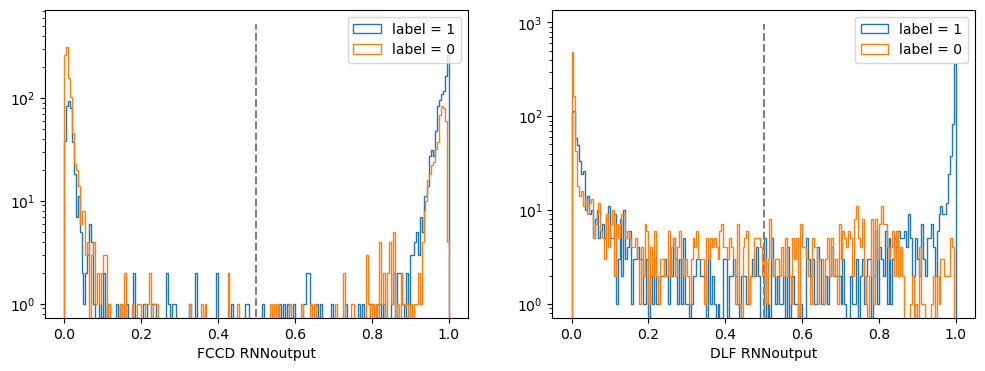

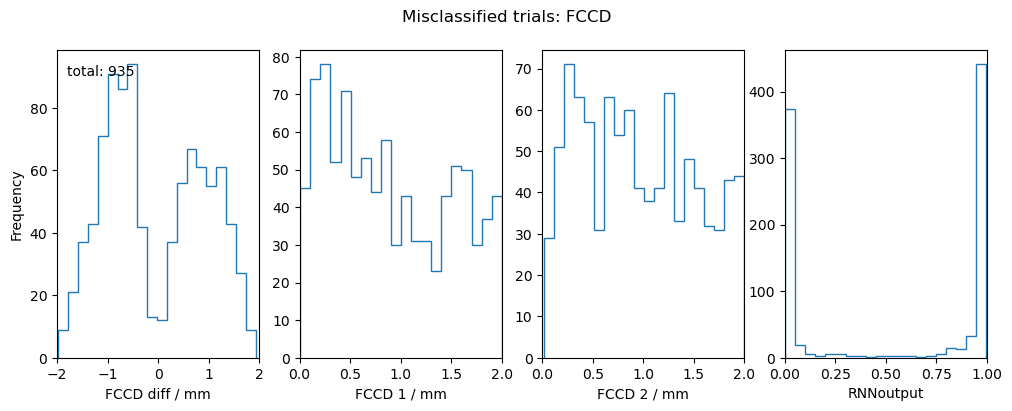

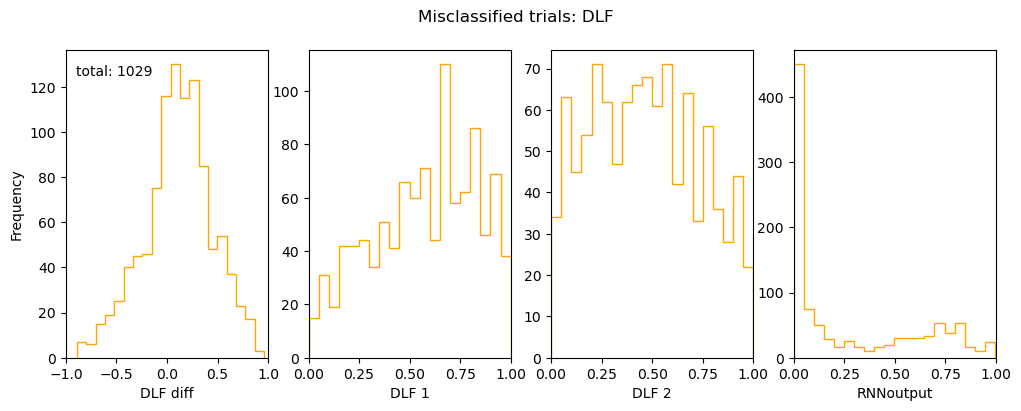

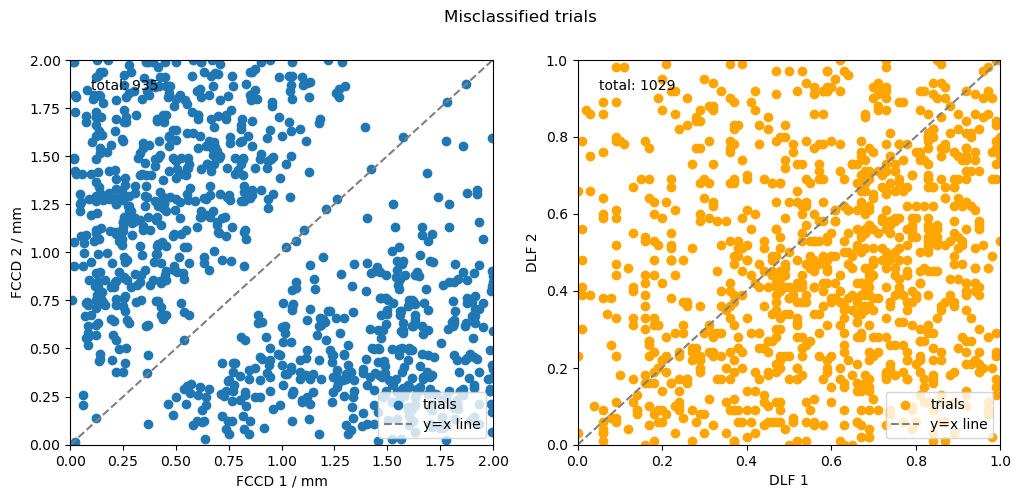

In [45]:
#testing
accuracies_maxFCCDdiff0_1mm = test_RNN(RNNclassifier_maxFCCDdiff0_1mm, test_loader, RNN_ID=RNN_ID, performance_plots = True, misclassified_trials_plots = True, save_results = True, train_restricted_test_fulldataset = True)


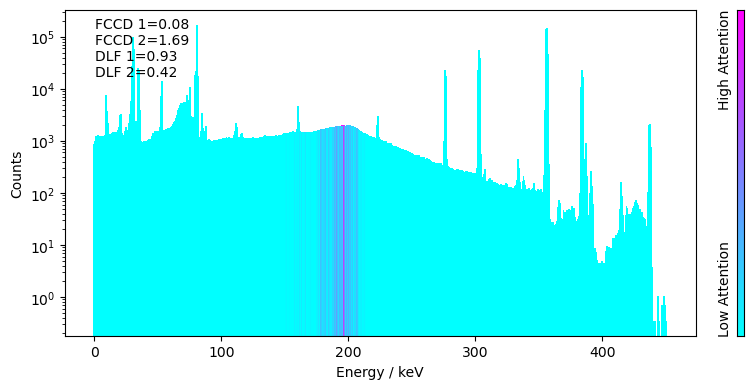

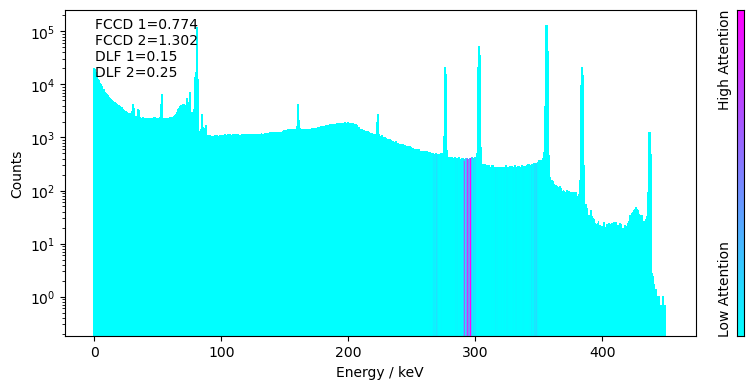

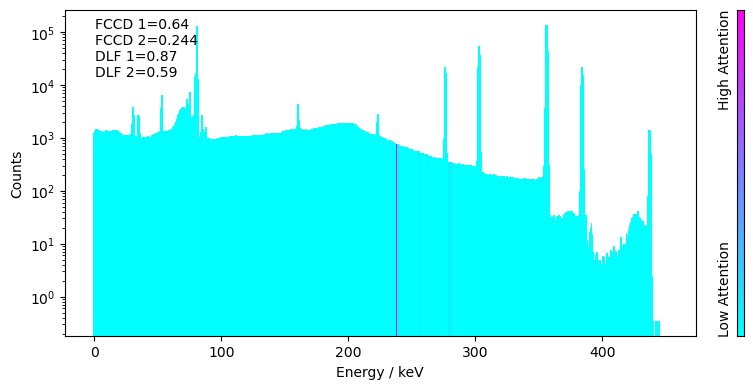

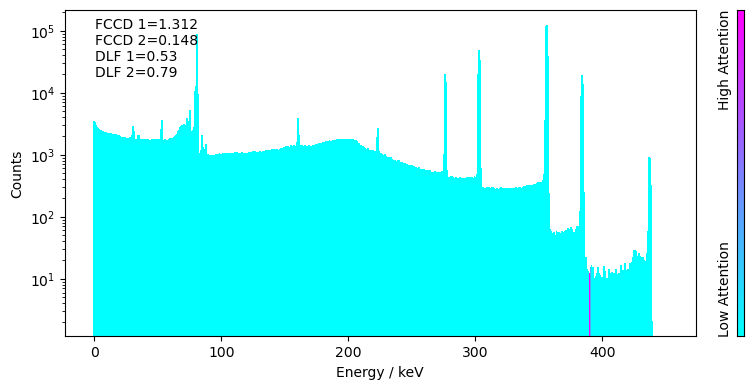

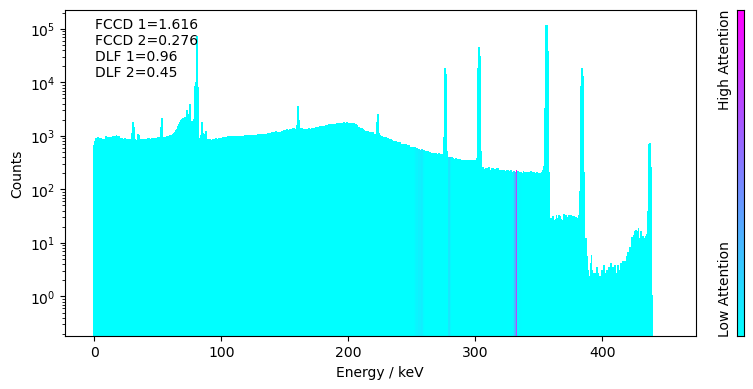

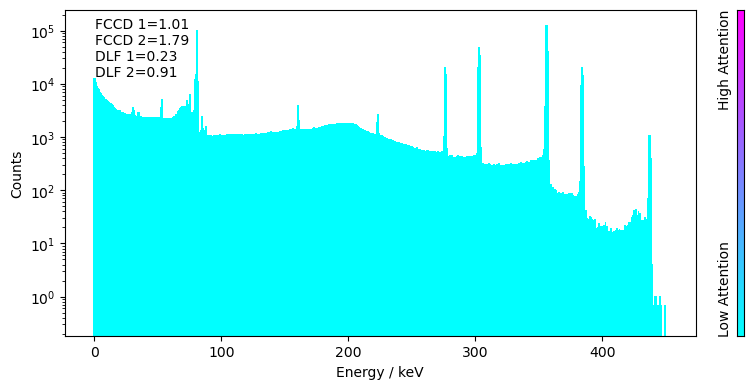

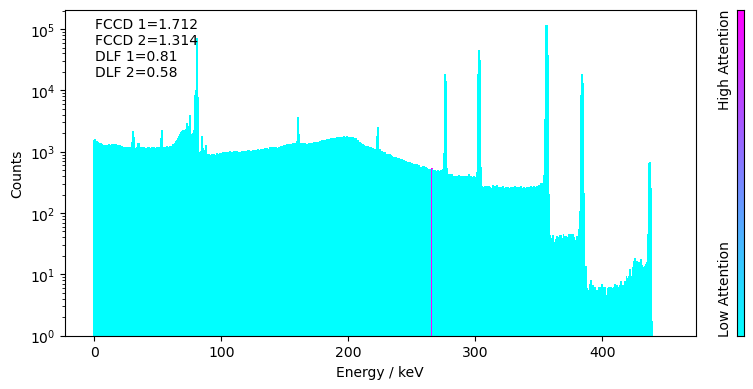

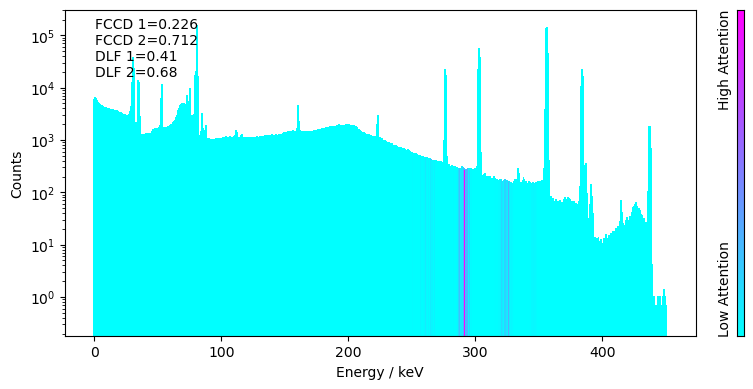

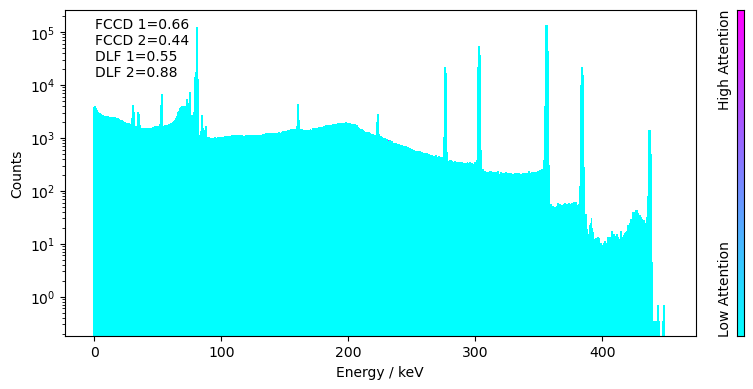

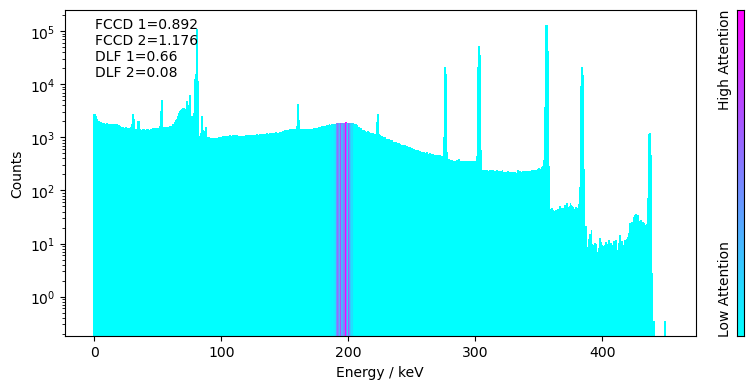

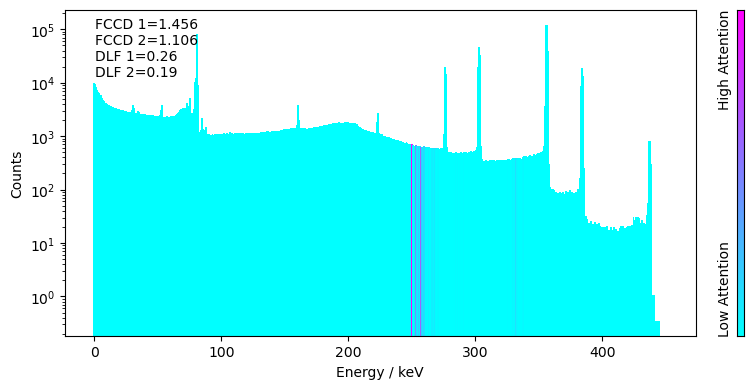

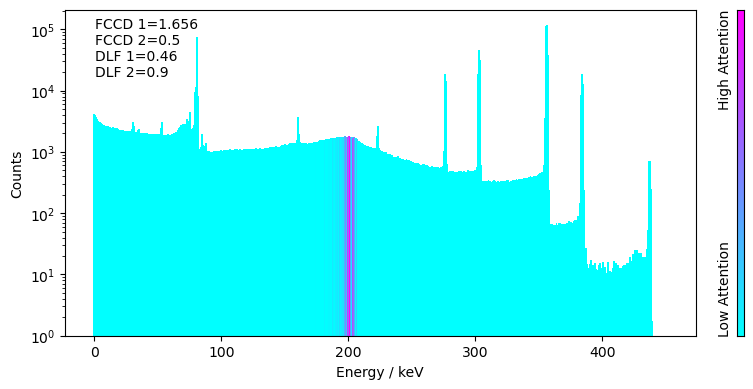

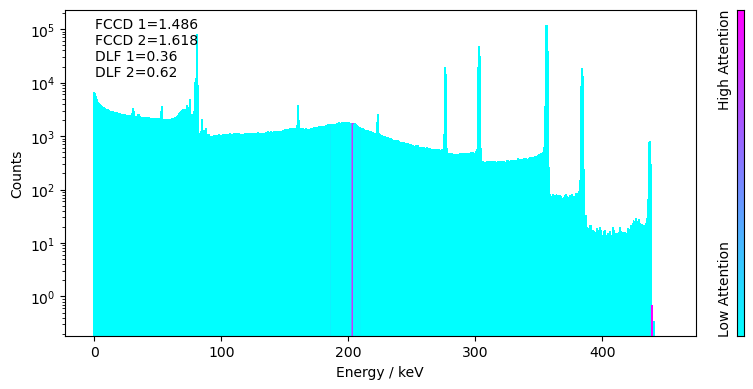

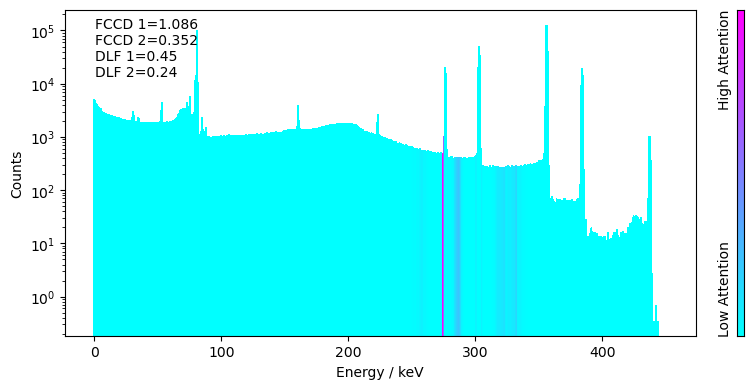

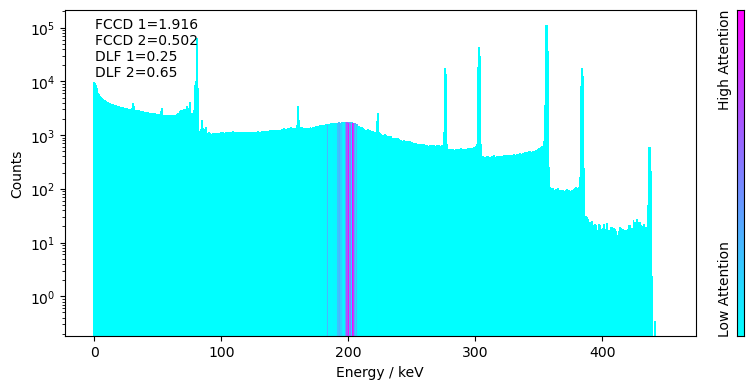

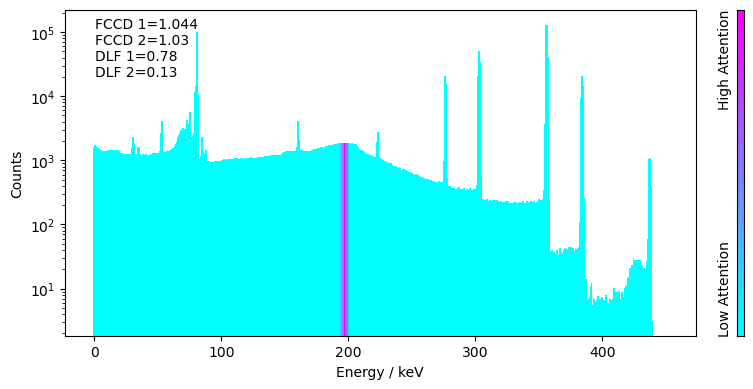

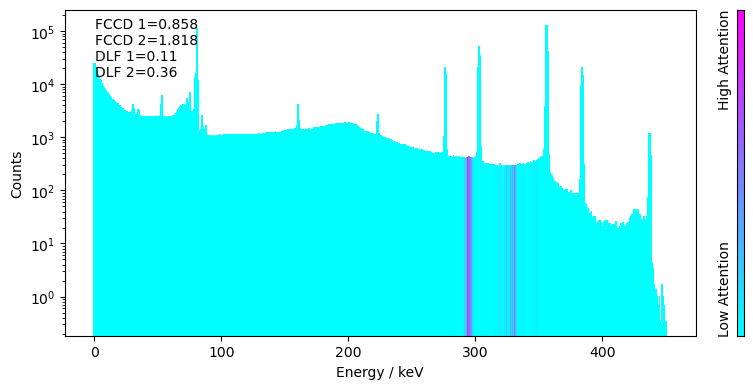

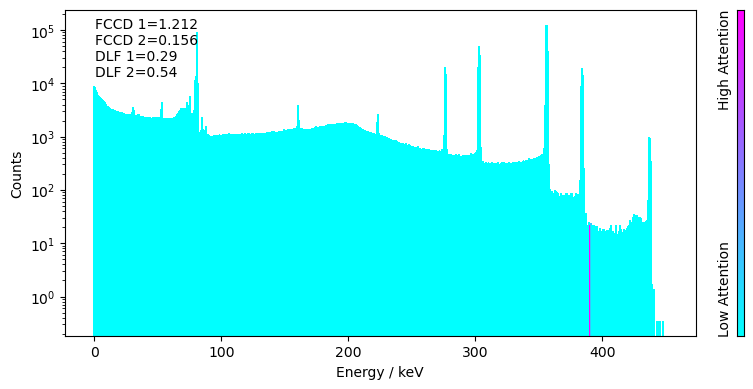

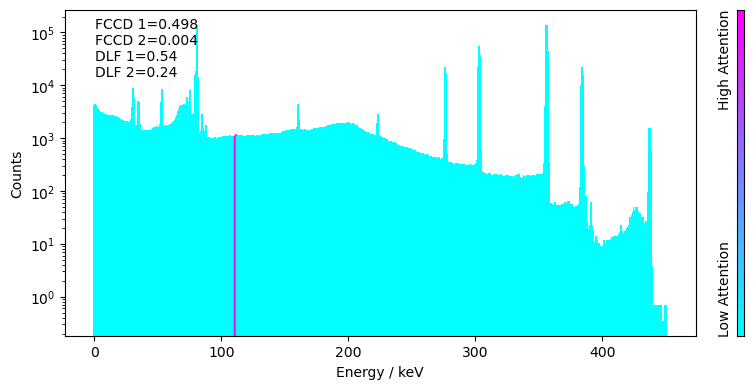

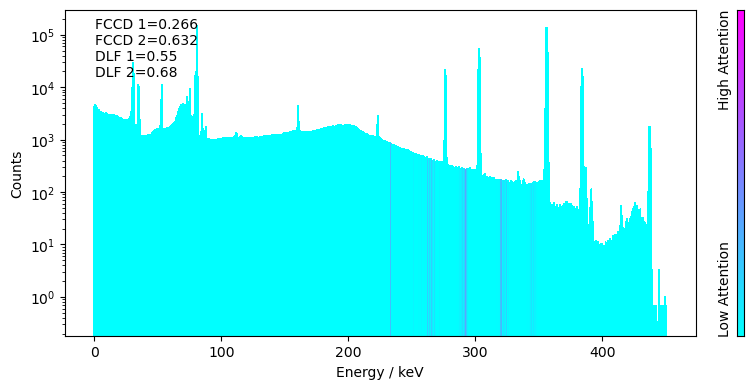

In [46]:
#Investigate Attention

#Make RNNinterpretor object and set get_attention to true
RNNinterpretor = RNN(dataset.get_histlen(),2)
RNNinterpretor.get_attention = True

#Load trained RNN dict to this
RNNinterpretor.load_state_dict(torch.load(model_path))
RNNinterpretor.eval()
RNNinterpretor.to(DEVICE)

import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages(CodePath+"/saved_models/"+RNN_ID+"/plots/test_attention_fulldataset.pdf")
   
for a in range (5):
    #Load a test events through interpretor
    test_spectrum_diff, test_FCCDLabel, test_DLFLabel, test_extras, test_spectrum = next(iter(test_loader))
    test_spectrum_diff = test_spectrum_diff.to(DEVICE).float()

    attention_score = RNNinterpretor(test_spectrum_diff)

    for i in range(BATCH_SIZE):
        attention = attention_score[i].cpu().detach().numpy()
        labels = {"FCCD1": test_extras["FCCD1"][i].item(), "FCCD2": test_extras["FCCD2"][i].item(), "DLF1": test_extras["DLF1"][i].item(), "DLF2": test_extras["DLF2"][i].item()}

        #plot attention score on spectrum
        fig = plot_attention(test_spectrum[i], attention, labels)
        pdf.savefig(fig)

pdf.close()

# ------------------------------------------
# Comparing RNNs
# ------------------------------------------

### -----------------------------------------------------------
# Questions to ask:

- **Why warm up attention mechanism?:**

*Answer: This is a special treatment for attention mechanism. The idea of warmup is to use very low learning rate at the beginning and then gradually increase the learning rate to nominal value. If we do this, the attention mechanism will be able to get a first sense of how the data looks like with those very low learning rate epochs. There are some papers you can read, but I think they are too technical and I don’t want you to get too deep into those technical details.*


- **Why does binary cross entropy loss value oscillate between epochs?**

*Answer: the main reason of oscillation is because of the stochastic training behavior. Stochastic Gradient Descent (SGD) is the base template of all ML optimizers. The idea of SGD is to randomly draw mini-batches from the entire dataset and train. Since the drawing is random, everytime it will introduce some stochasticity into the training, that’s the main reason your loss is oscillating. To me it looks very normal.*



- **Saving trained model -> how do you also save the train/test split/seed so that we dont test on data that was used for training?**

*Answer: I think for your case you don’t quite need to worry about overlapping between training/testing dataset just yet, because each of your data is a residual of subtraction of two spectrums. The probability that you have subtracted exactly two identical spectrums is low.*


- **Should there be an attention score for DLF and FCCD?**

*Answer: There is only one set of attention score, because the RNN is making a joint decisions to determine DLF and FCCD simultaneously. So ideally the attention score would show the part that both indicates FCCD and DLF differences.*


- **Attention plots: should I plot spectrum 1 and 2 for each sample? Should I average over multiple spectra so we can observe the overall trends?**



- **Restricted training: on both FCCD and DLF? Take in turns?**



- **After training on restricted dataset (e.g. maxFCCDdiff=0.5mm), should the testing/accuracy evaluation be performed on the test_loader of this restricted dataset, or the test_loader of the full dataset? Note that the performance on the whole dataset when trained on a restircted dataset is generally worse**


- **Restricted training: When maxFCCDdiff is restricted to 0.25mm, the RNN performs worse. Should I edit training parameters (i.e. increase no epochs, LR, etc) in order to try to improve the performance?**



Notes:
- make 2 attention plots, 1 like the one i already have, and one power spectrum/stacked histogram of all the attention scores in one -> just plot multiple attention on same graph
- just restrict FCCD (not DLF) and make as small as possible - i.e. to the resolution of traditional method
- to increase statistics, repetitively call testloader
- try training with 10,000 events instead
- try other attention mechanisam - compare graphs and see which makes more physical sense




In [ ]:

#     binwidth = 0.5 #keV
#     bins = np.arange(0,450+binwidth,binwidth)
#     bins_centres = np.delete(bins+binwidth/2,-1)


#     # data values
#     data_spectrum = torch.tensor(dataset.get_data()).to(DEVICE).float()
#     data_outputs = RNNclassifier(data_spectrum)
#     data_outputs = data_outputs.cpu().data.numpy()#.flatten()
#     data_out_index = np.argmax(data_outputs)